# Steel Plate Detection Prediction

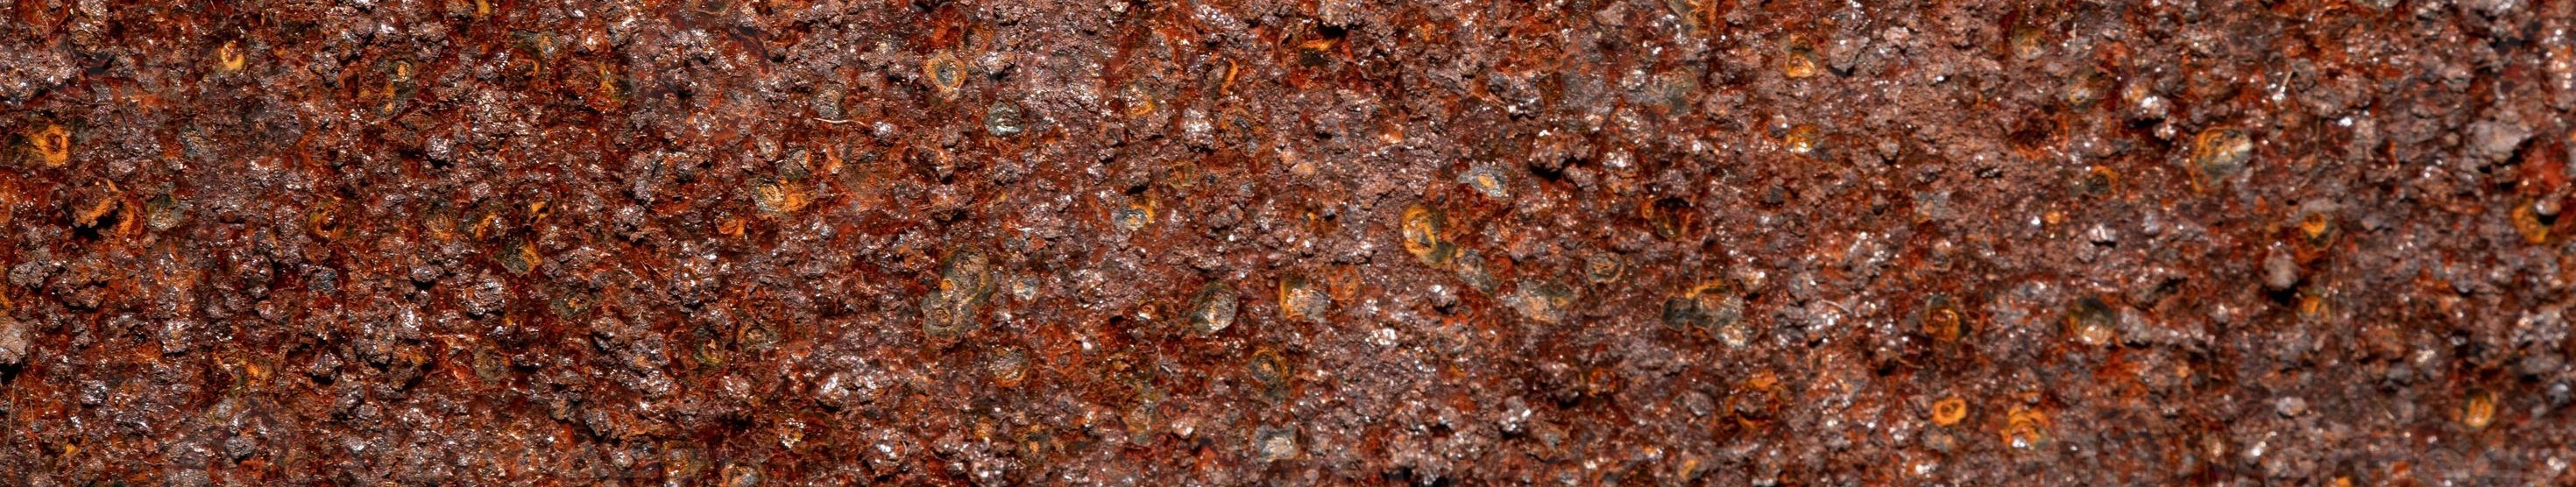

1. __Dataset Description__
The dataset for this competition (both train and test) was generated from a deep learning model trained on the Steel Plates Faults dataset from UCI. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

2. __Files__
`train.csv` - the training dataset; there are 7 binary targets: `Pastry`, `Z_Scratch`, `K_Scatch`, `Stains`, `Dirtiness`, `Bumps`, `Other_Faults`
`test.csv` - the test dataset; your objective is to predict the probability of each of the 7 binary targets
`sample_submission.csv` - a sample submission file in the correct format

3. __Evaluation__
Submissions are evaluated using area under the ROC curve using the predicted probabilities and the ground truth targets.
To calculate the final score, AUC is calculated for each of the 7 defect categories and then averaged. In other words, the score is the average of the individual AUC of each predicted column.

4. __Submission File__
For each id in the test set, you must predict the probability for each of 7 defect categories: Pastry, Z_Scratch, K_Scatch, Stains, Dirtiness, Bumps, Other_Faults. The file should contain a header and have the following format:

    ```python
    id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
    19219,0.5,0.5,0.5,0.5,0.5,0.5,0.5
    19220,0.5,0.5,0.5,0.5,0.5,0.5,0.5
    19221,0.5,0.5,0.5,0.5,0.5,0.5,0.5
    etc.
    ```

5. __Citation__
    * <a href="https://kaggle.com/competitions/playground-series-s4e3">Walter Reade, Ashley Chow, Steel Plate Defect Prediction, Kaggle, 2024</a>

## Import Dependencies

In [1]:
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from math import ceil
from scipy.stats import randint, uniform
import json
import os
import optuna

## Helper Functions

In [2]:
# Save model parameters
def save_params(params, filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, 'w') as file:
        json.dump(params, file)
    print(f"Best parameters saved to: '{filename}'.")
 
 
    
# Load model parameters
def load_params(filename):
    try:
        with open(filename, 'r') as file:
            params = json.load(file)
    except json.JSONDecodeError:
        raise ValueError(f"Error: '{filename}' is not a valid JSON file or is empty.")
    else:
        print(f"Parameters loaded from: '{filename}'.")
        
    return params




# Load optuna study
def load_study(db_name, study_name):
    study = optuna.load_study(study_name=study_name, storage=f'sqlite:///{db_name}')
    print(f"Study loaded from {db_name}")
    return study



# Remove all-zero rows
def remove_all_zero_columns(df:pd.DataFrame):
    all_zero_rows = df.sum(axis=1)==0
    print(f'Removing {len(all_zero_rows)} rows ...')
    return df[~all_zero_rows].reset_index(drop=True)



def compute_lower_upper_bounds(df:pd.DataFrame, col:str, method:str='IQR', **kwargs) -> tuple:
    """

    Args:
        df (pd.DataFrame): dataframe to compute the lower and upper bounds
        col (str): column in 'df' to compute the bounds
        method (str, optional): method to use for outlier detection. Choose from 'Percentile', ZScore', 'IQR'. Defaults to 'IQR'.
        **kwargs:
            limits (tuple, optional): limits for outlier detection, only used when method='Percentile'. Defaults to (0.01, 0.99).

    Returns:
        tuple: (lower_bound, upper_bound) - lower and upper bounds for the column 'col' in 'df'
    """
    
    try:
        if method == 'IQR':
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
        elif method == 'ZScore':
            mean = df[col].mean()
            std = df[col].std()
            lower_bound = mean - 3 * std
            upper_bound = mean + 3 * std
        elif method == 'Percentile':
            limits = kwargs.get('limits', (0.01, 0.99))
            lower_bound = df[col].quantile(limits[0])
            upper_bound = df[col].quantile(limits[1])
    except Exception as e:
        print(f'Error: {e}')
        return None, None
    return lower_bound, upper_bound
    
    
    
def mask_outliers(df: pd.DataFrame, col:str, method:str='Percentile', **kwargs) -> pd.Series:
    """_summary_

    Args:
        df (pd.DataFrame): dataframe to mask the outliers
        col (str): column in 'df' to check for outliers
        method (str, optional): method to use for outlier detection. Choose from 'Percentile', ZScore', 'IQR'. Defaults to 'Percentile'.
        **kwargs:
            limits (tuple, optional): limits for outlier detection, only used when method='Percentile'. Defaults to (0.01, 0.99).

    Returns:
        pd.Series: provide outlier mask for the column 'col' in 'df'
    """
    outlier_mask = pd.Series(False, index=df.index)
    lower_bound, upper_bound = compute_lower_upper_bounds(df, col, method, limits=kwargs.get('limits', (0.01, 0.99)))
    outlier_mask = outlier_mask | ((df[col] < lower_bound) | (df[col] > upper_bound))
    return outlier_mask



# Remove outliers rows
def remove_outliers(df:pd.DataFrame, y:pd.DataFrame=None, cols=[], **kwargs) -> tuple:
    """_summary_

    Args:
        df (pd.DataFrame): dataframe to remove outliers from
        y (pd.DataFrame, optional): target dataframe. Defaults to None.
        cols (list, optional): columns in 'df' to check for outliers. Defaults to [].
        **kwargs:
            method (str, optional): method to use for outlier detection. Choose from 'Percentile', ZScore', 'IQR'. Defaults to 'Percentile'.
            limits (tuple, optional): limits for outlier detection, only used when method='Percentile'. Defaults to (0.0005, 0.9995).

    Returns:
        tuple: (df_cleaned, y_cleaned) - cleaned dataframes
    """
    
    method = kwargs.get('method', 'Percentile')
    limits = kwargs.get('limits', (0.0005, 0.9995))
    cols = df.columns if cols==[] else cols
    
    outlier_mask = np.zeros(df.shape[0], dtype=bool)
    for col in cols:
        mask = mask_outliers(X, col, method=method, limits=(0.0005, 0.9995))
        outlier_mask |= mask # Combine masks for all columns
    return df[~outlier_mask], (y[~outlier_mask] if y is not None else None)



def count_outliers(df: pd.DataFrame, cols=[], method='Percentile', **kwargs) -> pd.Series:
    """

    Args:
        df (pd.DataFrame): dataframe to count the outliers
        cols (list, optional): columns in 'df' to count its outliers. Defaults to [].
        method (str, optional): method to use for outlier detection. Choose from 'Percentile', ZScore', 'IQR'. Defaults to 'Percentile'.
        **kwargs:
            limits (tuple, optional): limits for outlier detection, only used when method='Percentile'. Defaults to (0.01, 0.99).

    Returns:
        pd.Series: number of outliers for each column in 'cols'
    """
    if cols==[]: cols = df.columns
    outlier_counts = pd.Series(index=cols, dtype='float64')
    for col in cols:
        lower_bound, upper_bound = compute_lower_upper_bounds(df, col, method=method, limits=kwargs.get('limits', (0.01, 0.99)))
        outlier_counts[col] = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    return outlier_counts

#### Outliers

Outliers can affect model accuracy, especially for models that are sensitive to the range of the data, such as regression models. Here are some common methods to detect outliers in one-dimensional (univariate) data:

1. __Z-Score:__
Outliers are typically defined as points that have a Z-score greater than 3 or less than -3

2. __Interquartile Range (IQR):__
The IQR method defines outliers as points that fall below the first quartile (Q1) or above the third quartile (Q3) by a certain multiple of the IQR (commonly 1.5 times).

3. __Percentile-Based Method:__
This method flags values that fall beyond a specified percentile range, such as the 1st and 99th percentiles.
<br><br>


| Method               | Data Type              | Distribution Suitability       | Best For                   | Not Recommended When                  |
|----------------------|------------------------|--------------------------------|----------------------------|----------------------------------------|
| **Z-Score**          | Continuous             | Normal (Gaussian)              | Large datasets, quick detection | Skewed distributions, extreme outliers|
| **IQR**              | Continuous             | Any (especially non-normal)    | Skewed data, small datasets  | Uniform data, when mild outliers matter|
| **Percentile-Based** | Continuous             | Skewed or non-normal           | Large datasets, extreme outliers | Normally distributed data|



## Import Datasets

In [240]:
# Read csv files
data = pd.read_csv('./data/train.csv', header=0, index_col=0)
test = pd.read_csv('./data/test.csv', header=0, index_col=0)

# Create target and train dataframes
target_columns = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
target = data[target_columns]
train = data.drop(target_columns, axis=1)

print(f'tarin: {train.shape}')
print(f'target: {target.shape}')
print(f'test: {test.shape}')

tarin: (19219, 27)
target: (19219, 7)
test: (12814, 27)


### 1. Target (Labels)

In [242]:
# Intances with at least one defect
positive_class = []
negative_class = []
for col in target_columns:
    percent = target[col].value_counts(normalize=True).round(3)*100
    negative_class.append(percent[0])
    positive_class.append(percent[1])
target_min1 = pd.DataFrame({'Class': target_columns, 'Negative': negative_class, 'Positive': positive_class}).sort_values(by='Positive', ascending=False)


# Intances with more than one defect
target_1plus = target[target.sum(axis=1)>1].value_counts().sum()


# Intances with no defect
target_0 = target[target.sum(axis=1)==0].value_counts().sum()


print(f'Instances with more than one defect: {target_1plus} ({target_1plus/len(target)*100:.2f}%)')
print(f'Instances with no defect: {target_0} ({target_0/len(target)*100:.2f}%)')

Instances with more than one defect: 21 (0.11%)
Instances with no defect: 818 (4.26%)


In [255]:
target_min1

Class  Negative  Positive
6  Other_Faults      65.9      34.1
5         Bumps      75.2      24.8
2      K_Scatch      82.1      17.9
0        Pastry      92.4       7.6
1     Z_Scratch      94.0       6.0
3        Stains      97.0       3.0
4     Dirtiness      97.5       2.5

The rows with all-zero labels (i.e., no defect) represent a significant imbalance in the data, removing them could potentially improve performance, especially when models are struggling to learn patterns for the minority classes because the removed instances may contribute less valuable information to the model’s decision-making process. However, this could also introduce a bias if those all-zero instances have important relationships with features that the model should learn. Here, I do not remove these insances.

Additionally, there are instances that have more than one defect. This make the probelm a multi-label classification, because the labels are not mutually exclusive. Here, I will also keep these instances.

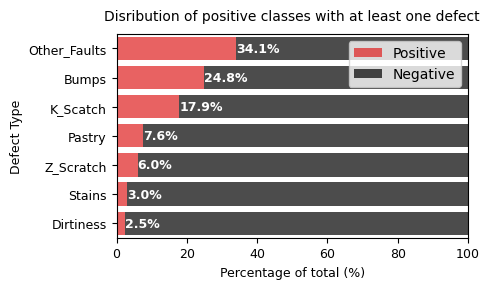

In [243]:
plt.figure(figsize=(5, 3))
ax = sns.barplot(x='Positive', y='Class', data=target_min1, width=.8, color='red', alpha=0.7, orient='h', label='Positive')
ax.bar_label(ax.containers[0], fmt="%.1f%%", fontsize=9, color='white', weight='bold')
sns.barplot(x='Negative', y='Class', data=target_min1, width=.8, color='black', alpha=0.7, orient='h', left=target_min1['Positive'], label='Negative')
ax.set_xlim(0, 100)
plt.xlabel('Percentage of total (%)', fontsize=9)
plt.ylabel('Defect Type', fontsize=9)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
# plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.0), ncols=2, fontsize=9)
plt.title('Disribution of positive classes with at least one defect', fontsize=10, pad=10)
plt.tight_layout()
plt.savefig('./images/target_positive_classes.png', dpi=300)
plt.show()

### 1.2. Target Correlation

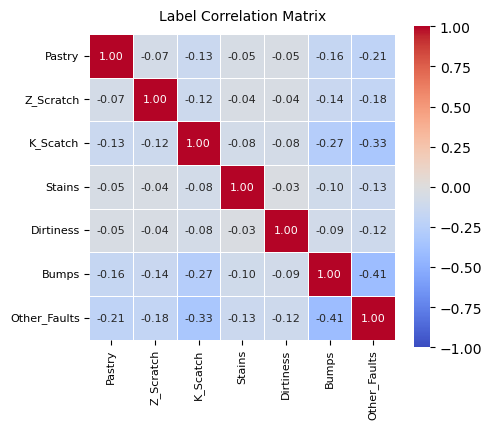

In [ ]:
target_corr = target.corr(method='spearman') 

plt.figure(figsize=(5, 5))
ax = sns.heatmap(target_corr, annot=True, fmt=".2f", annot_kws={'fontsize': 8}, cmap='coolwarm', square=True, linewidths=0.5, cbar_kws={'shrink': 0.75}, vmin=-1, vmax=1)
plt.title("Label Correlation Matrix", fontsize=10, pad=10)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
plt.tight_layout()
plt.savefig('./images/target_correlation_matrix.png', dpi=300)
plt.show()


#### Conditional Probability Analysis

It is the conditional probability of one label being positive given that another label is positive. This can highlight direct dependencies. If P(Label A∣Label B) is high, Label A is likely to occur whenever Label B does, suggesting dependency.

The line `np.mean(target[label_a][target[label_b] == 1])` computes the conditional probability P(A=1∣B=1), where:

* A is the event that `label_a` is 1.
* B is the event that `label_b` is 1.

__Conditional Probability__

The conditional probability of A given B is defined as:

$$P(A=1|B=1)=\frac{\text{Number of occurences where A=1 and B=1}}{\text{Number of occurences where B=1}}$$

This represents the proportion of cases where A is 1 among the cases where B is 1.

* `target[label_b] == 1` creates a boolean mask, selecting only rows where `label_b` is 1.
* `target[label_a][...]` uses this mask to select the values of `label_a` only for the rows where `label_b` is 1.
* `np.mean(...)` calculates the average of this filtered subset.
* Since `label_a` is a binary variable (0 or 1), taking the mean of this subset is equivalent to calculating the proportion of rows where `label_a` is 1 among the rows where `label_b` is 1.


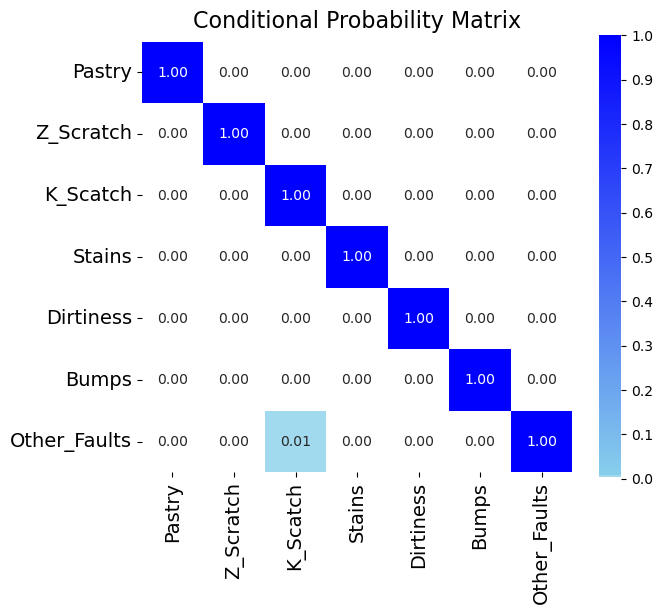

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

colors = [(0, "white"),
                # (0.0005, "lightblue"),
                (0.005, "skyblue"),
                # (0.05, "royalblue"),
                (1, "blue")] 

cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

conditional_prob_matrix = pd.DataFrame(index=target.columns, columns=target.columns)

for label_a in target.columns:
    for label_b in target.columns:
        conditional_prob = np.mean(target[label_a][target[label_b] == 1])
        conditional_prob_matrix.loc[label_a, label_b] = conditional_prob

plt.figure(figsize=(7, 7))
ax = sns.heatmap(conditional_prob_matrix.astype(float), annot=True, fmt='.2f', 
                 annot_kws={'fontsize': 10}, square=True, cmap=cmap,
                 cbar_kws={'shrink': 0.75, 'ticks': np.arange(0, 1.1, 0.1)})
plt.title("Conditional Probability Matrix", fontsize=16, pad=10)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
plt.tight_layout()
plt.savefig('./images/target_conditional_probability_matrix.png', dpi=300)
plt.show()


### 2. Features

#### 2.1. Distribution

* `Train` and `Test` datasets have coparable distributions
* Not all features are notmally distributed
* There are outliers in dataset

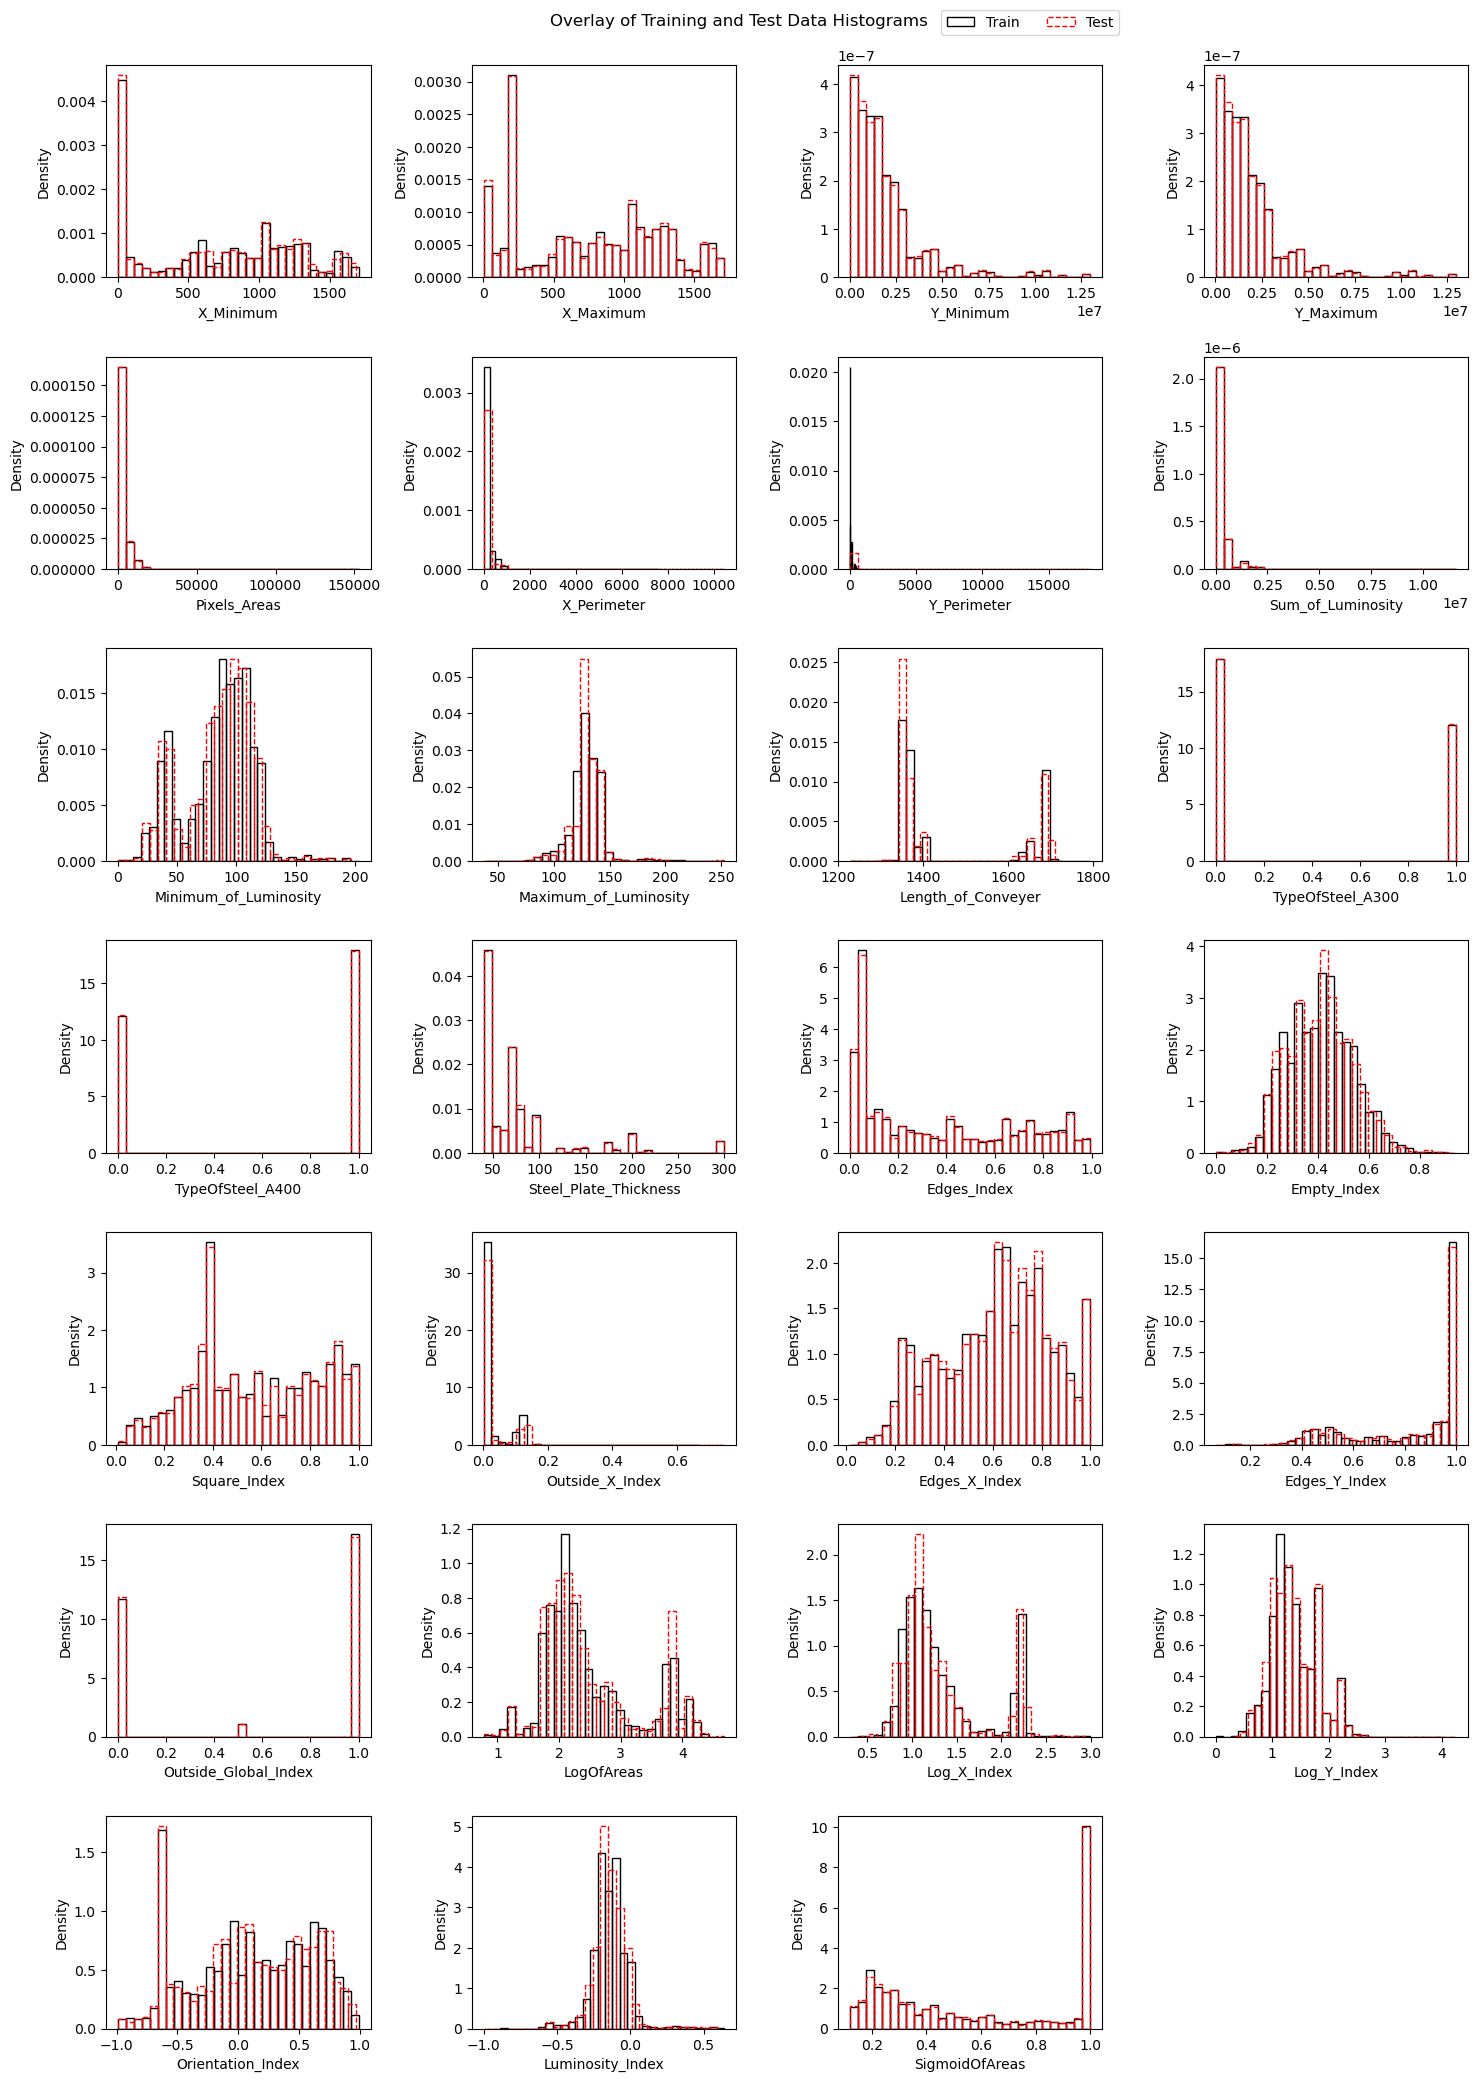

In [ ]:
def overlay_hist(train_df, test_df, ncols):
    nrows = ceil(train_df.shape[1]/ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3 * nrows))
    axes = axes.flatten()
    features = train_df.columns
    for i in range(len(axes)):
        try:
            feature = features[i]
            sns.histplot(train_df[feature], color='black', linewidth=1.0, fill=False, label='Train', kde=False, stat='density', bins=30, alpha=1.0, ax=axes[i])
            sns.histplot(test_df[feature], color='red', linewidth=1.0, linestyle='--', fill=False, label='Test', kde=False, stat='density', bins=30, alpha=1.0, ax=axes[i])
            axes[i].set_xlabel(feature)
            axes[i].grid(False)
        except IndexError:
            fig.delaxes(axes[i])
    fig.suptitle('Overlay of Training and Test Data Histograms', y=0.99, fontsize=12)
    handles, labels = axes[0].get_legend_handles_labels()    
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.63, 0.986), ncol=2, fontsize='medium')
    plt.tight_layout(pad=1.5)
    plt.savefig('./images/overlaid_histograms.png', dpi=300)
    plt.show()
    
    
overlay_hist(train, test, 4)

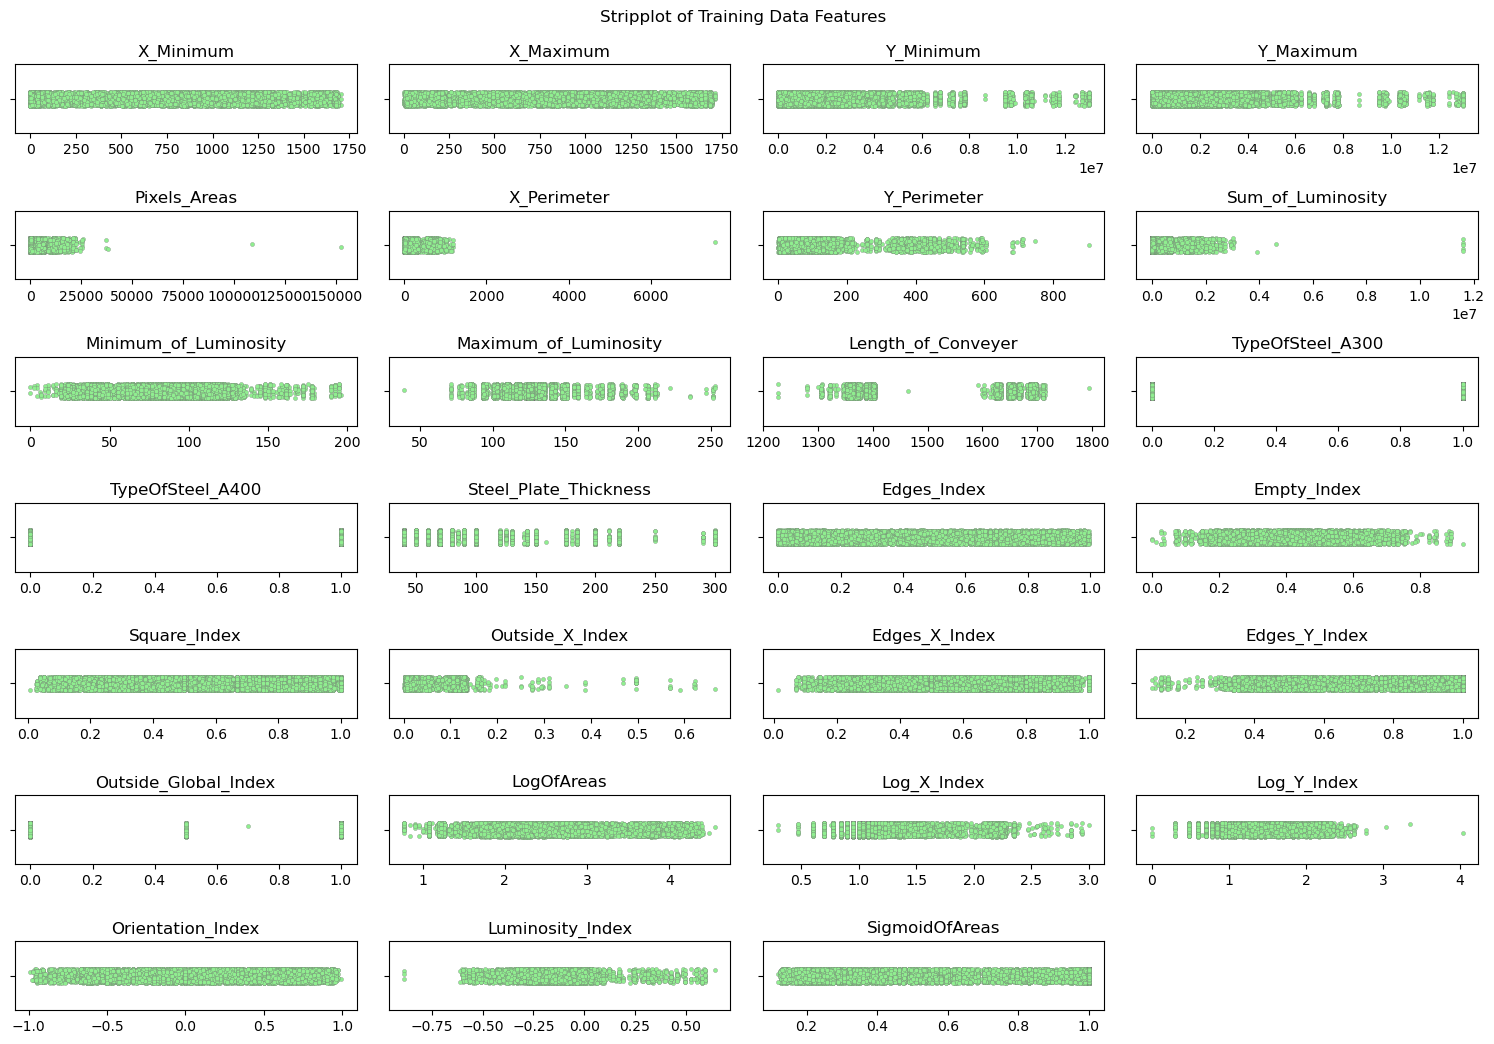

In [ ]:
ncols = 4
nrows = ceil(train.shape[1]/ncols)

fig, ax = plt.subplots(nrows, ncols, figsize=(15, 1.5 * nrows))
ax = ax.ravel()

for i, col in enumerate(train.columns):
    sns.stripplot(x=train[col], color='lightgreen', size=3, dodge=True, jitter=True, linewidth=0.2, ax=ax[i])

    ax[i].set_title(col)
    ax[i].set_xlabel('')
    
for j in range(i+1, len(ax)):
    fig.delaxes(ax[j])
    
fig.suptitle('Stripplot of Training Data Features', y=0.99, fontsize=12)    
plt.tight_layout()
plt.savefig("./images/stripplot_train_data.png", dpi=300)
plt.show()

### 2.2. Correlation

Three correlation methods, **Pearson**, **Kendall**, and **Spearman**, are common ways to measure relationships between variables, each with its own approach to quantifying correlation. 

| Method   | Measures            | Data Type        | Assumptions      | Strengths                  |
|----------|---------------------|------------------|------------------|----------------------------|
| Pearson  | Linear relationship | Continuous | Normally distributed | Best for linear relationships |
| Kendall | Ordinal association | Ordinal, non-parametric | None | Robust to outliers, good for small samples |
| Spearman | Monotonic relationship | Ordinal or non-normally distributed | None | Captures non-linear monotonic relationships |


__Spearman__ method assesses how well the relationship between two features of the dataset can be represented by a monotonic function.

It ranks each variable individually, then calculates Pearson’s correlation on the ranked data rather than the original data.

$$r_s = 1 - \frac{6 \sum{d_i^2}}{n(n^2-1)}$$

where $d_i$ is the difference in ranks for each observation, and $n$ is the number of observations. The Spearman's values range from -1 to 1. $r_s=1$ means perfect positive monotonic relationship while whereas $r_s=-1$ means perfect negative monotonic relationship. $r_s=0$ indicates no monotonic relationship.



In [ ]:
cat_features = ['TypeOfSteel_A300', 'TypeOfSteel_A400']
num_features = [feature for feature in train.columns if feature not in cat_features]

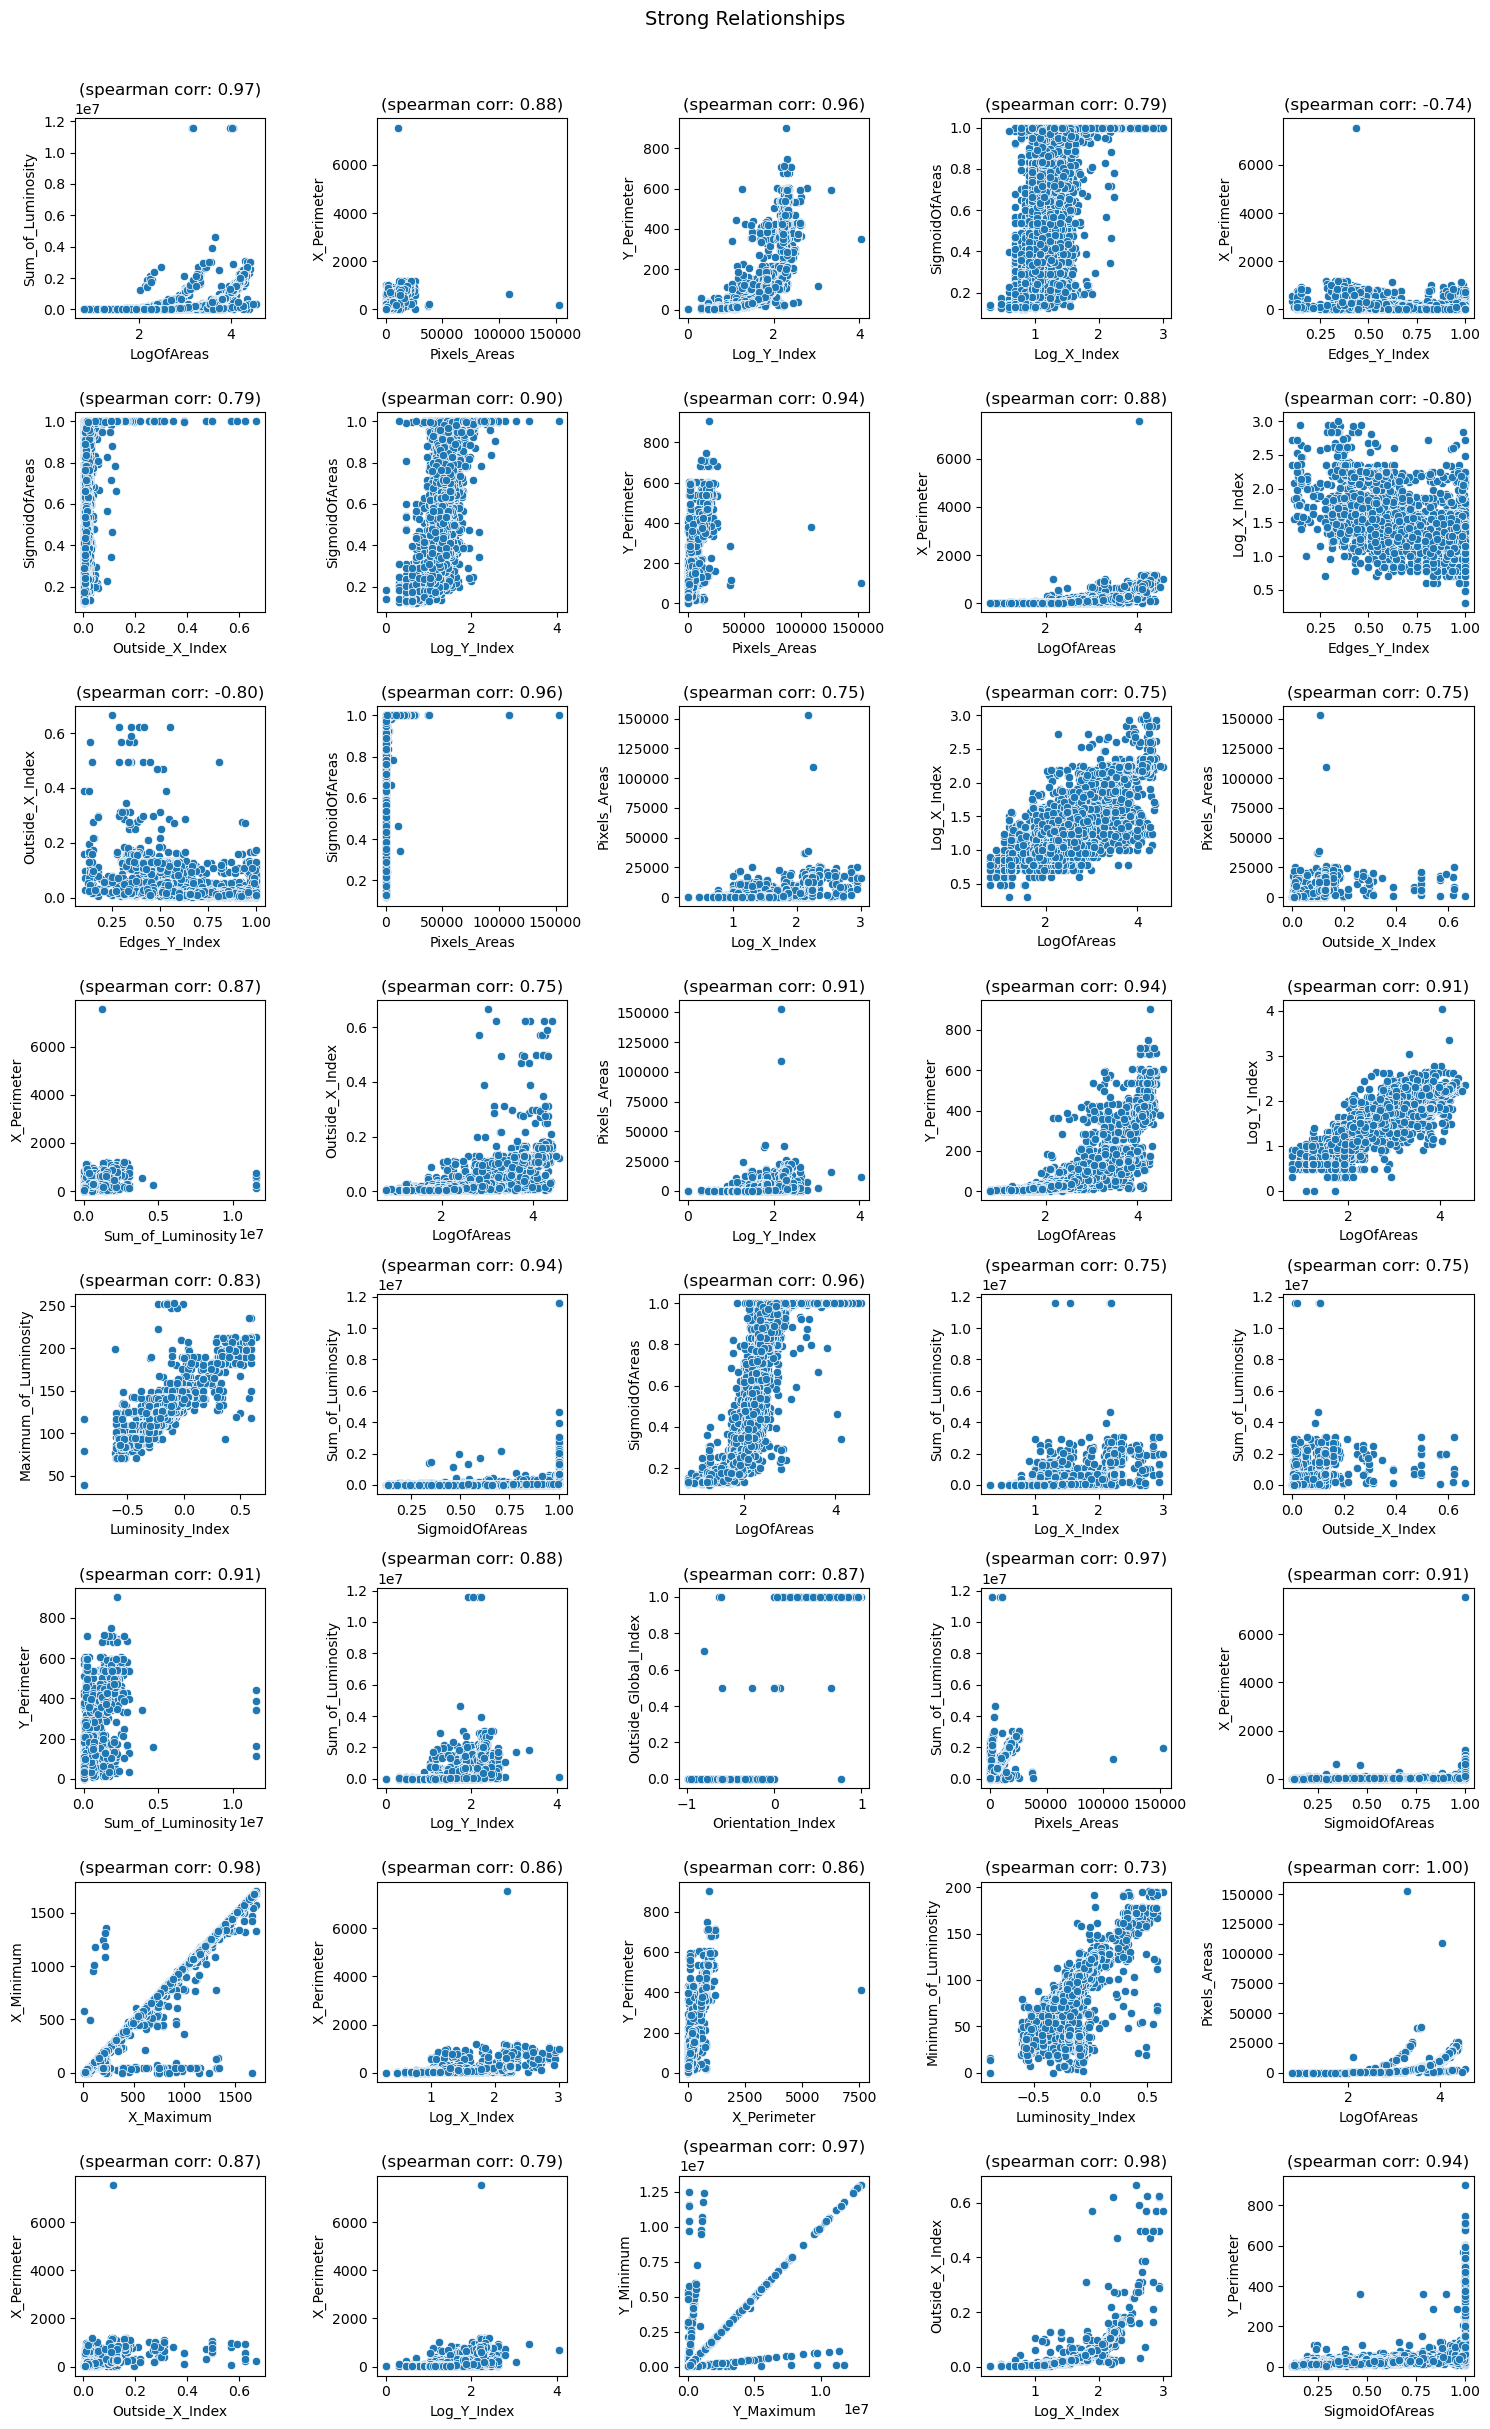

In [ ]:
# Identify pairs with strong monotonic relationships

corr_thr = 0.70
corr_method = 'spearman'
corr = train[num_features].corr(corr_method)

strong_pairs = [
    (col1, col2) for col1 in corr.columns for col2 in corr.columns
    if col1 != col2 and abs(corr.loc[col1, col2]) > corr_thr
]

strong_pairs = list(set(tuple(sorted(pair)) for pair in strong_pairs))




ncols = 5
nrows = ceil(len(strong_pairs)/ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 3 * nrows))
axes = axes.flatten()  

for i, (col1, col2) in enumerate(strong_pairs):
    ax = axes[i] 
    sns.scatterplot(data=train, x=col1, y=col2, ax=ax)
    ax.set_title(f"({corr_method} corr: {corr.loc[col1, col2]:.2f})")
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Strong Relationships', y=1.01, fontsize=14)
plt.tight_layout()
plt.show()


#### 2.2.1. Heatmap

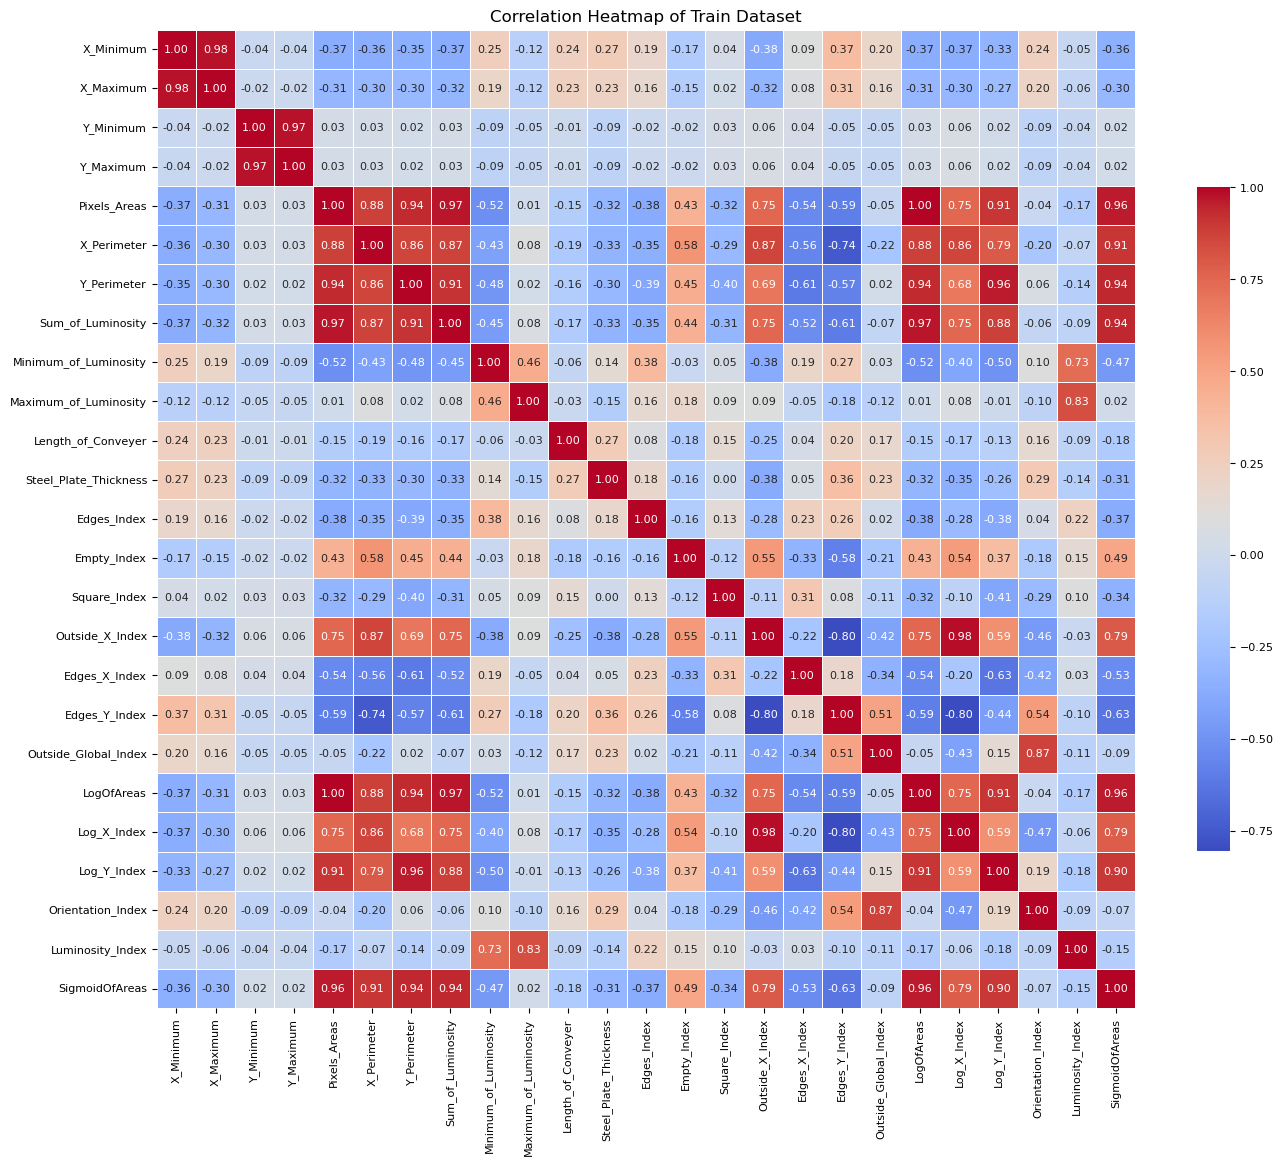

In [ ]:
plt.figure(figsize=(14, 14))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'fontsize': 8}, cmap='coolwarm', square=True, linewidths=0.5, cbar_kws={'shrink': 0.5})
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=8)
plt.title('Correlation Heatmap of Train Dataset')
plt.tight_layout()
plt.savefig('./images/correlation_heatmap.png', dpi=300)
plt.show()

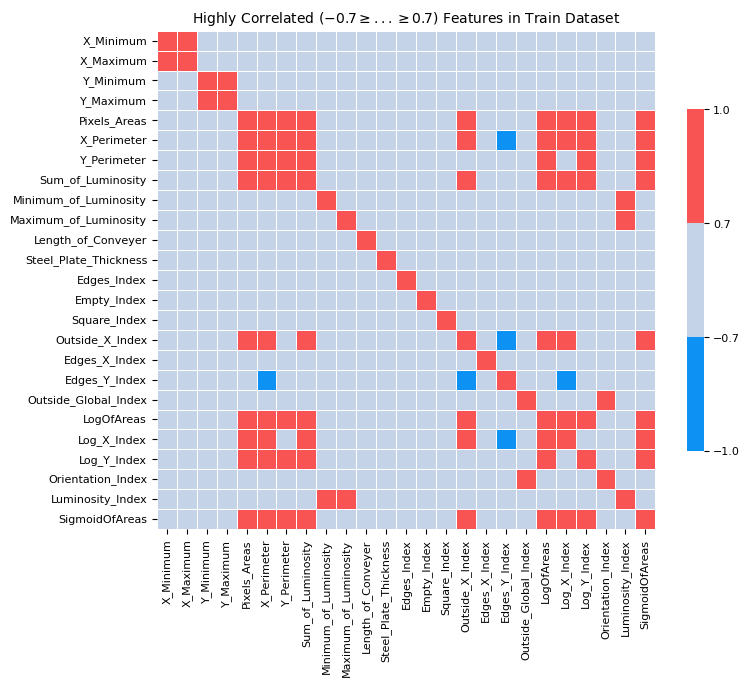

In [ ]:
import matplotlib.colors as mcolors


plt.figure(figsize=(8, 8))
cmap = mcolors.ListedColormap(['#0D92F4', '#C5D3E8', '#F95454'])
bounds = [-1, -corr_thr, corr_thr, 1] # Define the boundaries and normalization
norm = mcolors.BoundaryNorm(bounds, cmap.N)
ax = sns.heatmap(corr, annot=False, cmap=cmap, norm=norm, square=True, linewidths=0.5, cbar_kws={'shrink': 0.5})
# ax.grid(True, which='both', color='black', linestyle='-', linewidth=0.5)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=8)
plt.title(fr'Highly Correlated (${-corr_thr}\geq ... \geq {corr_thr}$) Features in Train Dataset', fontsize=10)
plt.tight_layout()
plt.savefig('./images/highly_correlated_features.png', dpi=300)
plt.show()

In [ ]:
strong_corr_pairs = []
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[1]):
        if abs(corr.iloc[i, j]) >= corr_thr:
            strong_corr_pairs.append((corr.columns[i], corr.columns[j], corr.iloc[i, j].round(3)))

high_corr_df = pd.DataFrame(strong_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
high_corr_df.to_csv('./data/highly_correlated_features.csv', index=False)
high_corr_df

Feature 1          Feature 2  Correlation
0               X_Minimum          X_Maximum        0.978
1               Y_Minimum          Y_Maximum        0.974
2            Pixels_Areas        X_Perimeter        0.878
3            Pixels_Areas        Y_Perimeter        0.935
4            Pixels_Areas  Sum_of_Luminosity        0.967
5            Pixels_Areas    Outside_X_Index        0.748
6            Pixels_Areas         LogOfAreas        0.998
7            Pixels_Areas        Log_X_Index        0.747
8            Pixels_Areas        Log_Y_Index        0.905
9            Pixels_Areas     SigmoidOfAreas        0.961
10            X_Perimeter        Y_Perimeter        0.865
11            X_Perimeter  Sum_of_Luminosity        0.871
12            X_Perimeter    Outside_X_Index        0.866
13            X_Perimeter      Edges_Y_Index       -0.745
14            X_Perimeter         LogOfAreas        0.878
15            X_Perimeter        Log_X_Index        0.863
16            X_Perimeter        Log_Y_Index        0.793
17            X_Perimeter     SigmoidOfAreas        0.907
18            Y_Perimeter  Sum_of_Luminosity        0.915
19            Y_Perimeter         LogOfAreas        0.936
20            Y_Perimeter        Log_Y_Index        0.962
21            Y_Perimeter     SigmoidOfAreas        0.941
22      Sum_of_Luminosity    Outside_X_Index        0.752
23      Sum_of_Luminosity         LogOfAreas        0.968
24      Sum_of_Luminosity        Log_X_Index        0.748
25      Sum_of_Luminosity        Log_Y_Index        0.878
26      Sum_of_Luminosity     SigmoidOfAreas        0.941
27  Minimum_of_Luminosity   Luminosity_Index        0.726
28  Maximum_of_Luminosity   Luminosity_Index        0.832
29        Outside_X_Index      Edges_Y_Index       -0.805
30        Outside_X_Index         LogOfAreas        0.749
31        Outside_X_Index        Log_X_Index        0.983
32        Outside_X_Index     SigmoidOfAreas        0.791
33          Edges_Y_Index        Log_X_Index       -0.803
34   Outside_Global_Index  Orientation_Index        0.866
35             LogOfAreas        Log_X_Index        0.747
36             LogOfAreas        Log_Y_Index        0.905
37             LogOfAreas     SigmoidOfAreas        0.962
38            Log_X_Index     SigmoidOfAreas        0.788
39            Log_Y_Index     SigmoidOfAreas        0.898

#### 2.2.2. Hierarchial Clustering

The strongly correlated pairs are listed above. However, this does not specify clusters of highly-correlated features, such as `Pixels_Areas`, `X_Perimeter`, and `Y_Perimeter`. 

To get these clusters, one approach is to convert the correlation matrix to a distance matrix (aka. dissimilarity matrix) suitable for clustering. High correlation (close to 1 or -1) results in small distances, so highly correlated features will be closer in the clustering.

$$d(x_i, x_j) = 1 - r_s(x_i, x_j)$$

Then, apply hierarchical clustering on the correlation matrix to identify clusters of highly correlated features. Betweeh the two methods namely "complete" and "ward", the latter is used since it is less influence by the outliers. Here is the comparison between the two methods:

The `ward` and `complete` methods are two different linkage criteria used in hierarchical clustering when computing the distance between clusters. These methods determine how the distance between clusters is measured and affect the formation of the clusters in hierarchical clustering algorithms. Here's a breakdown of the differences between the two:

| **Aspect**| **Ward's Method**| **Complete Linkage**|
|-----------|------------------|---------------------|
| **Objective**| Minimizes the within-cluster variance.| Maximizes the distance between clusters.|
| **Cluster Shape**| Produces compact, spherical clusters.| Produces elongated or irregular clusters.|
| **Sensitivity to Outliers**| Less sensitive to outliers.| More sensitive to outliers.|
| **Distance Metric**| Distance is based on centroids.| Distance is based on the maximum pairwise distance between points.|
| **Use Cases**| Suitable when you want compact clusters.| Suitable for identifying long-distance, spread-out clusters.|

* __Ward__
    Ward's method minimizes the total within-cluster variance. When two clusters are merged, the increase in the total variance of the merged cluster is minimized. This results in compact, spherical clusters.

    Ward's method calculates the squared Euclidean distance between the centroids (mean) of the clusters and merges the pair of clusters whose merging results in the smallest increase in the squared error. Essentially, it tries to minimize the increase in the sum of squared distances within all clusters.

    The distance between two clusters is the increase in the sum of squared distances to the mean of the merged cluster.

    $$D(C_1, C_2) = \sqrt{\frac{N_1 N_2}{N_1 + N_2} \|\bar{x_1} - \bar{x_2} \|^2}$$

    where 
    * $C_1$ and $C_2$ are the two clusters being merged,
    * $N_1$ and $N_2$ are the number of points in each cluster,
    * $\bar{x_1}$ and $\bar{x_2}$ are the centroids of the clusters.

* __Complete__
    The complete method, also known as the maximal linkage or furthest point linkage, calculates the distance between two clusters by looking at the maximum distance between any two points, one from each cluster.

    When two clusters are merged, the distance is defined as the maximum distance between any two points (one from each cluster). The furthest distance between points is used to determine how far apart the clusters are.

    The distance between two clusters is the maximum distance between any pair of points from the two clusters.

    $$D(C_1, C_2)=\max{\|x_1 - x_2\|: x_1 \in C_1, x_2 \in C_2}$$

    where:
    * $x_1$ amd $x_2$ are the points from clusters $C_1$ and $C_2$, respectively.

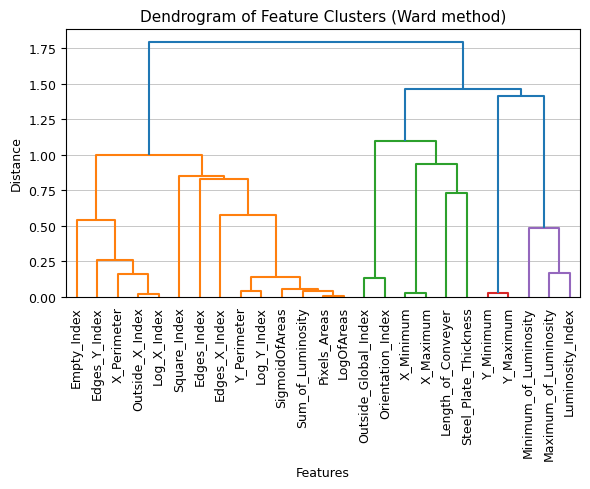

In [ ]:
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd


# Convert the correlation matrix to a distance matrix (1 - correlation)
distance_matrix = 1 - corr.abs()

# Ensure the matrix is symmetric
distance_matrix = (distance_matrix + distance_matrix.T) / 2

# Set diagonal elements to zero (no self-distance)
np.fill_diagonal(distance_matrix.values, 0)

# Convert the symmetric distance matrix to a condensed format
condensed_distance = ssd.squareform(distance_matrix)

# Perform hierarchical clustering using the condensed distance matrix
linkage_method = 'ward'
linked = sch.linkage(condensed_distance, method=linkage_method, metric='correlation')



# Plot a dendrogram to visualize the clusters
plt.figure(figsize=(6, 5))
dendrogram = sch.dendrogram(linked, labels=corr.columns, leaf_rotation=90, leaf_font_size=9)
plt.title('Dendrogram of Feature Clusters (Ward method)', fontsize=11)
plt.xlabel('Features', fontsize=9)
plt.ylabel('Distance', fontsize=9)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.grid(axis='y', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.savefig('./images/dendrogram.png', dpi=300)
plt.show()


In [ ]:
from scipy.cluster.hierarchy import fcluster

# Set a threshold distance for clusters
dist_thr = 0.15
clusters = fcluster(linked, dist_thr, criterion='distance')

# Create a dictionary to group features by clusters
cluster_dict = {}
for i, cluster_id in enumerate(clusters):
    feature = corr.columns[i]
    if cluster_id not in cluster_dict:
        cluster_dict[cluster_id] = []
    cluster_dict[cluster_id].append(feature)

# Display clusters of highly correlated features
print(f'Number of clusters: {len(cluster_dict)}\n')
for cluster_id, features in cluster_dict.items():
    print(f"Cluster {cluster_id}: {features}")


Number of clusters: 16

Cluster 10: ['X_Minimum', 'X_Maximum']
Cluster 13: ['Y_Minimum', 'Y_Maximum']
Cluster 5: ['Pixels_Areas', 'Y_Perimeter', 'Sum_of_Luminosity', 'LogOfAreas', 'Log_Y_Index', 'SigmoidOfAreas']
Cluster 2: ['X_Perimeter']
Cluster 16: ['Minimum_of_Luminosity']
Cluster 14: ['Maximum_of_Luminosity']
Cluster 11: ['Length_of_Conveyer']
Cluster 12: ['Steel_Plate_Thickness']
Cluster 7: ['Edges_Index']
Cluster 4: ['Empty_Index']
Cluster 8: ['Square_Index']
Cluster 1: ['Outside_X_Index', 'Log_X_Index']
Cluster 6: ['Edges_X_Index']
Cluster 3: ['Edges_Y_Index']
Cluster 9: ['Outside_Global_Index', 'Orientation_Index']
Cluster 15: ['Luminosity_Index']


In [ ]:
# Select one feature from each cluster to keep
selected_num_features = [features[0] for features in cluster_dict.values()]
print(f'Number of selected numerical features: {len(selected_num_features)}')

Number of selected numerical features: 16


## Pre-Processing


### 1. Create Pipelines

In [ ]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, FunctionTransformer, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer

cat_pipeline = 'passthrough'
num_pipeline = make_pipeline(StandardScaler())

preprocessing = ColumnTransformer([
    ('cat', cat_pipeline, ['TypeOfSteel_A300']),
    ('num', num_pipeline, selected_num_features)
])

### 2. Data Balancing

### 2.1. Oversampling Using SMOTE

SMOTE (Synthetic Minority Oversampling Technique) generates synthetic samples for the minority classes.

__Reason for concatenating only a portion of X_temp:__

`X_temp` is the result of applying SMOTE on the current features (`train`) and target label (`target[label]`).
SMOTE adds synthetic samples to address the imbalance in `target[label]`, but it also retains the original samples from `train`. As a result:
The first `len(train)` rows in `X_temp` are identical to the original `train`.
The rows after `len(train)` are the newly generated synthetic samples.
By slicing with `X_temp[len(train):]`, we ensure that only the synthetic samples are added to `train_res_smote`. This avoids duplicating the original samples multiple times across iterations of the loop.

In [ ]:
from imblearn.over_sampling import SMOTE



train_osamp= pd.DataFrame()
target_osamp = pd.DataFrame()

for label in target.columns:
    smote = SMOTE(random_state=7)
    X_temp, y_temp = smote.fit_resample(train, target[label])
    
    print(f"X_tamp shape: {X_temp.shape}, y_temp shape: {y_temp.shape}")
    
    if train_osamp.empty:
        train_osamp = pd.DataFrame(X_temp, columns=train.columns)
        target_osamp = pd.DataFrame(y_temp)
    else:
        train_osamp = pd.concat([train_osamp, pd.DataFrame(X_temp[len(train):], columns=train.columns)], ignore_index=True)
        target_osamp = pd.concat([target_osamp, pd.Series(y_temp[len(target):], name=label)], axis=1)

    print(f"train_osamp shape: {train_osamp.shape}, target_osamp shape: {target_osamp.shape}")
    
# Check new class distributions
for label in target.columns:
    print(f"{label} distribution after SMOTE:")
    print(target_osamp[label].value_counts())


X_tamp shape: (35506, 27), y_temp shape: (35506,)
train_osamp shape: (35506, 27), target_osamp shape: (35506, 1)
X_tamp shape: (36138, 27), y_temp shape: (36138,)
train_osamp shape: (52425, 27), target_osamp shape: (36138, 2)
X_tamp shape: (31574, 27), y_temp shape: (31574,)
train_osamp shape: (64780, 27), target_osamp shape: (36138, 3)
X_tamp shape: (37302, 27), y_temp shape: (37302,)
train_osamp shape: (82863, 27), target_osamp shape: (37302, 4)
X_tamp shape: (37468, 27), y_temp shape: (37468,)
train_osamp shape: (101112, 27), target_osamp shape: (37468, 5)
X_tamp shape: (28912, 27), y_temp shape: (28912,)
train_osamp shape: (110805, 27), target_osamp shape: (37468, 6)
X_tamp shape: (25322, 27), y_temp shape: (25322,)
train_osamp shape: (116908, 27), target_osamp shape: (37468, 7)
Pastry distribution after SMOTE:
Pastry
0.0    17753
1.0    17753
Name: count, dtype: int64
Z_Scratch distribution after SMOTE:
Z_Scratch
1.0    16919
Name: count, dtype: int64
K_Scatch distribution after S

### 2.2. Undersampling

_Random undersampling_ removes samples from the majority class. Random undersampling is straightforward to implement and can significantly reduce the training time by decreasing the dataset size. However, it may also lead to the loss of potentially valuable information that could be important for the learning process.
 
To mitigate the risk of losing important information through random undersampling, more sophisticated techniques have been developed. One such method is informed undersampling, which includes techniques like _Tomek links_ and the _Edited Nearest Neighbors (ENN)_ rule. 
 
_Tomek links_ identify pairs of very close instances belonging to different classes and remove the majority class instances from each pair, which helps to clean the overlapping regions between classes. 
 
Similarly, _ENN_ removes any instance of the majority class that is misclassified by its k-nearest neighbors. These methods are more selective about which instances to remove, aiming to retain as much relevant information as possible while still addressing the imbalance.

_Cluster-based undersampling_ is another advanced technique that groups the majority class instances into clusters and then samples from these clusters to ensure that the undersampled dataset retains a representative distribution of the original data. 
 
This approach helps in maintaining the diversity of the majority class in the reduced dataset, which is crucial for training robust models. These more nuanced undersampling strategies can be particularly effective in complex datasets where random undersampling might strip away important explanatory variables or lead to underfitting. By carefully selecting which instances to remove, these methods strive to maintain the integrity and informational value of the dataset while rectifying its imbalance.

__Comparison__

|Method	|Description	|Advantages	|Disadvantages|
|---|---|---|---|
|**Random Undersampling**	|Randomly removes samples from the majority class.	|Simple and fast.	|Risk of losing potentially important samples; randomness may lead to suboptimal results.|
|**Tomek Links**	|Identifies pairs of close samples from different classes and removes the majority class sample in the pair.	|Improves class separability by removing ambiguous or borderline majority samples.	|May not remove many samples, especially in datasets with complex class distributions.|
|**Edited Nearest Neighbors (ENN)**	|Removes majority class samples that are misclassified by their nearest neighbors.	|Focuses on removing noisy or overlapping samples, resulting in cleaner decision boundaries.	|Computationally expensive, especially for large datasets.|
|**Cluster-Based Undersampling** |Groups majority samples into clusters and selects a representative sample (e.g., centroid) from each cluster. |Maintains diversity in the majority class, reduces information loss, and avoids arbitrary removals.<br></br> Best use case :	When the majority class is very large, and there is a need to reduce its size while preserving diversity. |Computationally expensive (due to clustering); the effectiveness depends on the choice of the clustering algorithm and parameters. |

<br>

|Method	|Focus	|Diversity Preserved?	|Noise Reduction?	|Computational Cost|
|---|---|---|---|---|
|**Random Undersampling**	|Removes samples randomly.	|No	|No	|Low|
|**Tomek Links**	|Removes borderline samples from the majority class.	|Partial	|Yes	|Moderate|
|**ENN**	|Removes noisy majority class samples using nearest neighbor classification.	|Partial	|Yes	|High|
|**Cluster-Based**	|Groups majority samples into clusters and selects representatives to maintain diversity.	|Yes	|No	|High|

#### 2.2.1. Random Undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler


train_usamp_rnd, target_usamp_rnd = pd.DataFrame(), pd.DataFrame()

for label in target.columns:
    rus = RandomUnderSampler(random_state=7)
    X_res, y_res = rus.fit_resample(train, target[label])
    
    if train_usamp_rnd.empty:
        train_usamp_rnd = pd.DataFrame(X_res, columns=train.columns)
    target_usamp_rnd[label] = y_res

for label in target.columns:
    print(f"{label} distribution after Random Undersampling:")
    print(target_usamp_rnd[label].value_counts())


Pastry distribution after Random Undersampling:
Pastry
0    1466
1    1466
Name: count, dtype: int64
Z_Scratch distribution after Random Undersampling:
Z_Scratch
0.0    186
1.0     99
Name: count, dtype: int64
K_Scatch distribution after Random Undersampling:
K_Scatch
0.0    555
1.0    289
Name: count, dtype: int64
Stains distribution after Random Undersampling:
Stains
0.0    85
1.0    42
Name: count, dtype: int64
Dirtiness distribution after Random Undersampling:
Dirtiness
0.0    80
1.0    42
Name: count, dtype: int64
Bumps distribution after Random Undersampling:
Bumps
0.0    797
1.0    393
Name: count, dtype: int64
Other_Faults distribution after Random Undersampling:
Other_Faults
0.0    1263
1.0     532
Name: count, dtype: int64


#### 2.2.2. Tomek Links

In [ ]:
from imblearn.under_sampling import TomekLinks


train_usamp_tomek, target_usamp_tomek = pd.DataFrame(), pd.DataFrame()

for label in target.columns:
    tl = TomekLinks()
    X_res, y_res = tl.fit_resample(train, target[label])
    
    if train_usamp_tomek.empty:
        train_usamp_tomek = pd.DataFrame(X_res, columns=train.columns)
    target_usamp_tomek[label] = y_res

for label in target.columns:
    print(f"{label} distribution after Tomek Links:")
    print(target_usamp_tomek[label].value_counts())


Pastry distribution after Tomek Links:
Pastry
0    16970
1     1466
Name: count, dtype: int64
Z_Scratch distribution after Tomek Links:
Z_Scratch
0    17303
1     1133
Name: count, dtype: int64
K_Scatch distribution after Tomek Links:
K_Scatch
0    15045
1     3391
Name: count, dtype: int64
Stains distribution after Tomek Links:
Stains
0    17892
1      544
Name: count, dtype: int64
Dirtiness distribution after Tomek Links:
Dirtiness
0    17968
1      468
Name: count, dtype: int64
Bumps distribution after Tomek Links:
Bumps
0.0    12516
1.0     4763
Name: count, dtype: int64
Other_Faults distribution after Tomek Links:
Other_Faults
0.0    10176
1.0     6558
Name: count, dtype: int64


#### 2.2.3. Edited Nearest Neighbors (ENN)

In [330]:
from imblearn.under_sampling import EditedNearestNeighbours

# Edited Nearest Neighbors undersampling for each label
train_usamp_enn, target_usamp_enn = pd.DataFrame(), pd.DataFrame()

for label in target.columns:
    enn = EditedNearestNeighbours()
    X_res, y_res = enn.fit_resample(train, target[label])
    
    # Append the resampled data
    if train_usamp_enn.empty:
        train_usamp_enn = pd.DataFrame(X_res, columns=train.columns)
    target_usamp_enn[label] = y_res

# Check new class distributions
for label in target.columns:
    print(f"{label} distribution after Edited Nearest Neighbors:")
    print(target_usamp_enn[label].value_counts())
    
print()
print(f"train_usamp_enn shape: {train_usamp_enn.shape}, target_usamp_enn shape: {target_usamp_enn.shape}")


Pastry distribution after Edited Nearest Neighbors:
Pastry
0    14229
1     1466
Name: count, dtype: int64
Z_Scratch distribution after Edited Nearest Neighbors:
Z_Scratch
0    15329
1      366
Name: count, dtype: int64
K_Scatch distribution after Edited Nearest Neighbors:
K_Scatch
0    13995
1     1700
Name: count, dtype: int64
Stains distribution after Edited Nearest Neighbors:
Stains
0    15695
Name: count, dtype: int64
Dirtiness distribution after Edited Nearest Neighbors:
Dirtiness
0    15695
Name: count, dtype: int64
Bumps distribution after Edited Nearest Neighbors:
Bumps
0.0    7312
1.0    4763
Name: count, dtype: int64
Other_Faults distribution after Edited Nearest Neighbors:
Other_Faults
1.0    6558
0.0    4377
Name: count, dtype: int64

train_usamp_enn shape: (15695, 27), target_usamp_enn shape: (15695, 7)


In [354]:
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks



def undersample(X, y, label, method='ENN'):
    if method == 'ENN':
        enn = EditedNearestNeighbours()
        return enn.fit_resample(X, y[label])
    elif method == 'RUS':
        rus = RandomUnderSampler(random_state=7)
        return rus.fit_resample(X, y[label])
    elif method == 'Tomek':
        tl = TomekLinks()
        return tl.fit_resample(X, y[label])
    else:
        raise ValueError(f"Error: '{method}' is not a valid undersampling method.")
    


#### 2.2.4. Cluster-Based Undersampling

This method reduces the majority class (negative samples here) by clustering them and keeping representative samples. However, if the clustering process doesn't preserve the minority class (positives), it might effectively remove them for labels with lower minority percentages, even when they represent a relatively large proportion of the positive class compared to other labels.

To address this, you can use a hybrid approach or modify the undersampling strategy:

1. Hybrid Sampling (SMOTE + ClusterCentroids):
Use SMOTE to oversample the minority class before applying Cluster-Based Undersampling to ensure that positives are preserved during the clustering step.
Tthe desired `sampling_strategy` can dynamically be computed for each label based on its specific distribution.

2. Weighted Cluster-Based Undersampling:
Modify the clustering process to consider both classes and ensure that minority samples are always included.

In [ ]:
for label in target.columns:
    minority_count = target[label].sum()
    majority_count = len(target[label]) - minority_count
    print(f'{label} class distribution:')
    print(f'Minority class: {minority_count}, Majority class: {majority_count}\n')

Pastry class distribution:
Minority class: 1466, Majority class: 17753

Z_Scratch class distribution:
Minority class: 1150, Majority class: 18069

K_Scatch class distribution:
Minority class: 3432, Majority class: 15787

Stains class distribution:
Minority class: 568, Majority class: 18651

Dirtiness class distribution:
Minority class: 485, Majority class: 18734

Bumps class distribution:
Minority class: 4763, Majority class: 14456

Other_Faults class distribution:
Minority class: 6558, Majority class: 12661



In [ ]:
# Hybrid undersampling using SMOTE and ClusterCentroids

from imblearn.under_sampling import ClusterCentroids



train_usamp_cc = pd.DataFrame()
target_usamp_cc = pd.DataFrame()

for label in target.columns:
    minority_count = target[label].sum()
    majority_count = len(target[label]) - minority_count
    
    if minority_count == 0:
        print(f"No positive samples for {label}. Skipping.")
        continue
    
    required_samples = int(majority_count * 0.2) - minority_count
    if required_samples <= 0:
        print(f"Skipping SMOTE for {label} as the ratio is already achieved.")
        X_smote, y_smote = train, target[label]
    else:
        smote = SMOTE(random_state=7, sampling_strategy=0.2)
        X_smote, y_smote = smote.fit_resample(train, target[label])
     
    # Step 2: Apply Cluster-Based Undersampling to reduce majority class
    cc = ClusterCentroids(random_state=42, sampling_strategy="auto")
    X_res, y_res = cc.fit_resample(X_smote, y_smote)
    
    if train_usamp_cc.empty:
        train_usamp_cc = pd.DataFrame(X_res, columns=train.columns)
    target_usamp_cc[label] = y_res


for label in target.columns:
    print(f"{label} distribution after Cluster-Based Undersampling:")
    print(target_usamp_cc[label].value_counts())


Skipping SMOTE for K_Scatch as the ratio is already achieved.
Skipping SMOTE for Bumps as the ratio is already achieved.
Skipping SMOTE for Other_Faults as the ratio is already achieved.
Pastry distribution after Cluster-Based Undersampling:
Pastry
0    3550
1    3550
Name: count, dtype: int64
Z_Scratch distribution after Cluster-Based Undersampling:
Z_Scratch
0    3613
1    3487
Name: count, dtype: int64
K_Scatch distribution after Cluster-Based Undersampling:
K_Scatch
0.0    3432
1.0    3432
Name: count, dtype: int64
Stains distribution after Cluster-Based Undersampling:
Stains
0    3730
1    3370
Name: count, dtype: int64
Dirtiness distribution after Cluster-Based Undersampling:
Dirtiness
0    3746
1    3354
Name: count, dtype: int64
Bumps distribution after Cluster-Based Undersampling:
Bumps
0    4763
1    2337
Name: count, dtype: int64
Other_Faults distribution after Cluster-Based Undersampling:
Other_Faults
0    6558
1     542
Name: count, dtype: int64


### 2.3. Combination of Oversampling and Undersampling

`SMOTEENN` combines `SMOTE` with `Edited Nearest Neighbors (ENN)`, which removes noisy data points after oversampling.

In [356]:
# Create a new balanced dataset for each label using combined sampling
from imblearn.combine import SMOTEENN

def combined_sampling(X, y, label):
    smote_enn = SMOTEENN(random_state=7, sampling_strategy='auto')
    return smote_enn.fit_resample(X, y[label])

### 3. Split Train Data

In [353]:
from math import e
from sklearn.model_selection import train_test_split

features = selected_num_features + ['TypeOfSteel_A300']

X_train, X_val, y_train, y_val = train_test_split(train[features], target, test_size=0.2, random_state=7)

X_train_usamp, y_train_usamp = undersample(X_train, y_train, method='ENN')

print(f'X_train shape: {X_train.shape}')
print(f'X_train_usamp shape: {X_train_usamp.shape}')
print(f'X_val shape: {X_val.shape}\n')

print(f'y_train shape: {y_train.shape}')
print(f'y_train_usamp shape: {y_train_usamp.shape}')
print(f'y_val shape: {y_val.shape}')

X_train shape: (15375, 17)
X_train_usamp shape: (12649, 17)
X_val shape: (3844, 17)

y_train shape: (15375, 7)
y_train_usamp shape: (12649, 7)
y_val shape: (3844, 7)


In [ ]:
y_train['Bumps'].value_counts()


Bumps
0    11581
1     3794
Name: count, dtype: int64

In [349]:
y_train_usamp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14808 entries, 0 to 14807
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Pastry        14808 non-null  int64  
 1   Z_Scratch     14808 non-null  int64  
 2   K_Scatch      14808 non-null  int64  
 3   Stains        14808 non-null  int64  
 4   Dirtiness     14808 non-null  int64  
 5   Bumps         13921 non-null  float64
 6   Other_Faults  13513 non-null  float64
dtypes: float64(2), int64(5)
memory usage: 809.9 KB


In [352]:
print(f'Number of missing values in X_train: {X_train.isna().sum().sum()}')
print(f'Number of missing values in X_train_usamp: {X_train_usamp.isna().sum().sum()}')
print(f'Number of missing values in X_val: {X_val.isna().sum().sum()}')

print(f'Number of missing values in y_train: {y_train.isna().sum().sum()}')
print(f'Number of missing values in y_train_usamp: {y_train_usamp.isna().sum().sum()}')
print(f'Number of missing values in y_val: {y_val.isna().sum().sum()}\n')

print(f'Number of infinite values in X_train: {np.isinf(X_train).sum().sum()}')
print(f'Number of infinite values in X_train_usamp: {np.isinf(X_train_usamp).sum().sum()}')
print(f'Number of infinite values in X_val: {np.isinf(X_val).sum().sum()}')

print(f'Number of infinite values in y_train: {np.isinf(y_train).sum().sum()}')
print(f'Number of infinite values in y_train_usamp: {np.isinf(y_train_usamp).sum().sum()}')
print(f'Number of infinite values in y_val: {np.isinf(y_val).sum().sum()}')

Number of missing values in X_train: 0
Number of missing values in X_train_usamp: 0
Number of missing values in X_val: 0
Number of missing values in y_train: 0
Number of missing values in y_train_usamp: 10499
Number of missing values in y_val: 0

Number of infinite values in X_train: 0
Number of infinite values in X_train_usamp: 0
Number of infinite values in X_val: 0
Number of infinite values in y_train: 0
Number of infinite values in y_train_usamp: 0
Number of infinite values in y_val: 0


## Multi-Output Classification

Since there are 7 targets, this is a multi-output classification problem, where each sample has multiple labels whose probabilities need to be predicted.

### 1. Hyperparameter Tuning with Bayesian Optimization

Bayesian Optimization is more efficient than Grid or Randomized Search because it uses past evaluations to decide on the next set of hyperparameters to try. Libraries like `hyperopt` and `optuna` are commonly used.

* __Handling Probabilities for ROC AUC Calculation across Multiple Labels__

    `cross_val_score` can directly compute scores using a single metric on each fold, but it does not return the individual fold predictions; it returns only the fold scores.
    To calculate a weighted AUC for multiple labels, we need access to the predicted probabilities across all labels for each sample in the entire dataset (as `roc_auc_score` requires actual probabilities for ROC AUC calculation).
    `cross_val_predict` with `predict_proba` provides these probabilities across all labels for every sample, allowing us to compute a custom score on the full set.

* __Compatibility with Multilabel Classification__

    For multilabel tasks, we need `predict_proba` for each label, so that we can calculate the AUC score per label and then average these for a final score.
    `cross_val_score` does not support returning probabilities for multiple outputs directly, while `cross_val_predict` can generate probabilistic predictions per label if we set `method='predict_proba'`.

In [357]:
from sklearn.model_selection import cross_val_predict, KFold, cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
import optuna
import optuna.visualization as ov





def is_by_label(best_params):
    return all(isinstance(value, dict) for value in best_params.values())


def make_model(base_model, best_params:dict, by_label:bool):
    
    # base_model.set_params(**best_params)
    # Create a fresh instance of the model with the best_params
    model = base_model.__class__(**best_params)
    
    base_model_name = base_model.__class__.__name__
    if base_model_name in ['LGBMClassifier','XGBClassifier'] and not by_label:
        model =  OneVsRestClassifier(model)
    elif base_model_name == 'CatBoostClassifier':
        model = OneVsRestClassifier(model)
    # model = make_pipeline(preprocessing, model)
    return model


def optimize(base_model, param_space:dict, X, y, by_label:bool, **kwargs):
    
    n_trials = kwargs.get('n_trials', 100)
    n_splits = kwargs.get('n_splits', 3)
    n_jobs = kwargs.get('n_jobs', 1)
    suffix = kwargs.get('suffix', '')
    sampling_strategy = kwargs.get('sampling_strategy', None)
    
    if by_label:
        study= lebal_specific_optimization(base_model, param_space, X, y, n_trials, n_splits, n_jobs, suffix, sampling_strategy)
    else:
        study = multilabel_optimization(base_model, param_space, X, y, n_trials, n_splits, n_jobs, suffix)
    
    return study



# Optimize multilabel best params
def multilabel_optimization(base_model, param_sapce:dict, X, y, n_trials:int, n_splits:int, n_jobs:int, suffix:str):  
    optuna.logging.set_verbosity(optuna.logging.INFO)
    pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1, interval_steps=1)
    
    def objective(trial):
        
        params = param_sapce(trial)
        model = make_model(base_model, params, by_label=False)
        
        cv = KFold(n_splits=n_splits, shuffle=True, random_state=7)
        y_pred_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba', n_jobs=n_jobs)
        
        try:
            # RandomeForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier where y_pred_proba is a list of numpy arrays of negative and positive class probabilities
            y_pred_proba_positive = np.array([y_pred_proba[i][:, 1] for i in range(len(y_pred_proba))]).T
        except IndexError:
            # LGBMClassifier, XGBClassifier where y_pred_proba is a numpy array arrays of positive class probabilities
            y_pred_proba_positive = y_pred_proba
        
        score = roc_auc_score(y, y_pred_proba_positive, average="weighted")
        
        trial.report(score, step=1)
        if trial.should_prune():
            raise optuna.TrialPruned()
        
        return score
    

    storage, study_names = generate_study_storage_names(base_model, by_label=False, suffix=suffix)
    
    try:
        optuna.delete_study(study_name=study_names[0], storage=storage)
    except KeyError:
        pass
    
    study = optuna.create_study(direction="maximize", pruner=pruner, storage=storage, study_name=study_names[0])
    study.optimize(objective, n_trials)

    print("Best Parameters:", study.best_params)
    print("Best AUC Score:", study.best_value)

    return study


# Optimize label-specific best params
def lebal_specific_optimization(base_model, param_sapce, X, y, n_trials:int, n_splits:int, n_jobs:int, suffix:str, sampling_strategy):
    optuna.logging.set_verbosity(optuna.logging.CRITICAL)
    pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1, interval_steps=1)
    
    studies_by_label = {}
    storage , study_names = generate_study_storage_names(base_model, by_label=True, suffix=suffix)
       
    for i, label in enumerate(y.columns):
        if sampling_strategy=='combined':
            X_samp, y_samp = combined_sampling(X, y, label)
        elif sampling_strategy=='ENN':
            X_samp, y_samp = undersample(X, y, label, method='ENN')
        elif sampling_strategy=='RUS':
            X_samp, y_samp = undersample(X, y, label, method='RUS')
        elif sampling_strategy=='Tomek':
            X_samp, y_samp = undersample(X, y, label, method='Tomek')
        else:
            X_samp, y_samp = X, y[label]
            
        def objective(trial):          
            params = param_sapce(trial)
            model = make_model(base_model, params, by_label=True)
            
            cv = KFold(n_splits=n_splits, shuffle=True, random_state=7)
            y_pred_proba = cross_val_predict(model, X_samp, y_samp, cv=cv, method='predict_proba', n_jobs=n_jobs)
            
            y_pred_proba_positive = y_pred_proba[:, 1]

            score = roc_auc_score(y_samp, y_pred_proba_positive)
            
            trial.report(score, step=1)
            if trial.should_prune():
                raise optuna.TrialPruned()
            
            return score
        
        try:
            optuna.delete_study(study_name=study_names[i], storage=storage)
        except KeyError:
            pass
        
        study = optuna.create_study(direction="maximize", pruner=pruner, storage=storage, study_name=study_names[i])
        study.optimize(objective, n_trials)
        studies_by_label[label] = study
        
        print(f"Best Parameters for label {label}:", study.best_params)
        print(f"Best AUC Score for label {label}:", study.best_value)

    return studies_by_label
    


def base_estimator_cross_val_score(base_model, X, y, by_label:bool, suffix:str, sampling_strategy):
    best_params = retrieve_best_params(base_model, by_label=by_label, suffix=suffix)
    cv = KFold(n_splits=5, shuffle=True, random_state=7)
    
    if by_label:
        score_by_label = []
        label_weights = []
        
        for label in y_train.columns:
            
            if sampling_strategy=='combined':
                X_samp, y_samp = combined_sampling(X, y, label)
            elif sampling_strategy=='ENN':
                X_samp, y_samp = undersample(X, y, label, method='ENN')
            elif sampling_strategy=='RUS':
                X_samp, y_samp = undersample(X, y, label, method='RUS')
            elif sampling_strategy=='Tomek':
                X_samp, y_samp = undersample(X, y, label, method='Tomek')
            else:
                X_samp, y_samp = X, y[label]            
            
            
            model = make_model(base_model, best_params[label], by_label=by_label)
            score = cross_val_score(model, X_samp, y_samp, cv=cv, scoring='roc_auc', n_jobs=-1)
            score_by_label.append(score.mean())
            
            # Both of the following methods return the same result for the weighted average
            label_weights.append(np.sum(y_samp == 1))
            # label_weights.append(y[label].value_counts(normalize=True)[1])
            
        mean_roc_auc = np.average(score_by_label, weights=label_weights)
        print(f"weights; {label_weights}")
        print(f"Mean ROC AUC Score on Training Set: {mean_roc_auc:.4f}")
        return mean_roc_auc

    else:
        model = make_model(base_model, best_params, by_label=by_label)
        scorer = make_scorer(roc_auc_score, response_method='predict_proba', average='weighted')
        score = cross_val_score(model, X, y, cv=cv, scoring=scorer, n_jobs=-1)
        print(f"Weighted ROC AUC Score on Training Set: {score.mean():.4f}")
        return score.mean()



    
def evaluate(base_model, X, y, by_label:bool, suffix:str, sampling_strategy):
    if by_label:
        return evaluate_by_label(base_model, X, y, suffix, sampling_strategy)
    else:
        return evaluate_multilabel(base_model, X, y, suffix)



# Evalute model on validation set using multilabel best params
def evaluate_multilabel(base_model, X, y, suffix):
    best_params = retrieve_best_params(base_model, by_label=False, suffix=suffix)
    model = make_model(base_model, best_params, by_label=False)
    model.fit(X, y)

    y_pred_proba = model.predict_proba(X_val)
    try:
        y_pred_proba_positive = np.array([proba[:, 1] for proba in y_pred_proba]).T
    except IndexError:
        y_pred_proba_positive = y_pred_proba

    weighted_roc_auc_score = roc_auc_score(y_val, y_pred_proba_positive, average="weighted")
    print(f"Weighted ROC AUC Score on Validation Set: {weighted_roc_auc_score}")
    
    return weighted_roc_auc_score


# Evalute model on validation set using label-specific best params
def evaluate_by_label(base_model, X, y, suffix:str, sampling_strategy):
    best_params = retrieve_best_params(base_model, by_label=True, suffix=suffix)
    y_pred_proba = pd.DataFrame(columns=y_val.columns)
    
    for label, params in best_params.items():
        print(f"Training model for label: '{label}'...")
        model = make_model(base_model, params, by_label=True)
        
        if sampling_strategy=='combined':
            X_samp, y_samp = combined_sampling(X, y, label)
        elif sampling_strategy=='ENN':
            X_samp, y_samp = undersample(X, y, label, method='ENN')
        elif sampling_strategy=='RUS':
            X_samp, y_samp = undersample(X, y, label, method='RUS')
        elif sampling_strategy=='Tomek':
            X_samp, y_samp = undersample(X, y, label, method='Tomek')
        else:
            X_samp, y_samp = X, y[label]
        
        model.fit(X_samp, y_samp)
        
        y_pred_proba[label] = model.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val[label], y_pred_proba[label])
        print(f"ROC AUC Score for label '{label}': {auc:.4f}\n")

    weighted_roc_auc_score = roc_auc_score(y_val, y_pred_proba, average="weighted")
    print(f"Weighted ROC AUC Score on Validation Set: {weighted_roc_auc_score}")
    
    return weighted_roc_auc_score



# Retreive best params from db-file
def retrieve_best_params(base_model, by_label:bool, suffix:str):
    
    storage, study_names = generate_study_storage_names(base_model, by_label, suffix)
    
    if by_label:
        best_params_by_label = {}
        for i, label in enumerate(y_train.columns):
            study = optuna.load_study(study_name=study_names[i], storage=storage)
            best_params_by_label[label] = study.best_params
            
        return best_params_by_label
    
    else:
        study = optuna.load_study(study_name=study_names[0], storage=storage)
        return study.best_params




def generate_study_storage_names(base_model, by_label:bool, suffix:str):
    os.makedirs('models', exist_ok=True)
    if by_label:
        storage = f'sqlite:///models/{base_model.__class__.__name__}_label{suffix}.db'
        study_names = [base_model.__class__.__name__ + f"_{label}_label" for label in y_train.columns]
    else:
        storage = f'sqlite:///models/{base_model.__class__.__name__}_multi{suffix}.db'
        study_names = [base_model.__class__.__name__ + "_multi"]
        
    return storage, study_names



def retrieve_studies(base_model, by_label:bool, suffix:str):
    storage, study_names = generate_study_storage_names(base_model, by_label, suffix)
    
    if by_label:
        studies_by_label = {}
        for i, label in enumerate(y_train.columns):
            study = optuna.load_study(study_name=study_names[i], storage=storage)
            studies_by_label[label] = study
            
        return studies_by_label
    
    else:
        return optuna.load_study(study_name=study_names[0], storage=storage)




# Plot the optimization history
# def plot_optimization_history(study:optuna.Study, model_name:str, target_name:str, image_file:str):
#     fig = ov.plot_optimization_history(study,target_name=target_name)

#     fig.update_layout(
#         width=800, 
#         height=600, 
#         title = {
#             'text': f'Label-Specific Hyperparameter Optimization History of {model_name}',
#             'x': 0.5,
#             'y': 0.95,
#             'xanchor': 'center',
#             'yanchor': 'top'
#         },
#         legend=dict(
#             x=0.95,
#             y=0.10,
#             xanchor='right',
#             yanchor='bottom',
#             orientation='h',
#             traceorder="normal",
#             bgcolor="rgba(255, 255, 255, 0.5)",
#         )
#     )
#     fig.show()


def generate_trial_data(base_model, by_label:bool, suffix:str):
    studies = retrieve_studies(base_model, by_label, suffix)
    
    if by_label:
        trial_data_frames = []
        for label, study in studies.items():
            trials_df = study.trials_dataframe(attrs=('number', 'value'))
            trials_df['cumulative_max'] = trials_df['value'].cummax()
            trials_df['label'] = label  # Add label column for distinguishing each label's data
            trial_data_frames.append(trials_df)
        
        # Combine all label data into one DataFrame
        combined_trials_df = pd.concat(trial_data_frames, ignore_index=True)
        return combined_trials_df
    
    else:
        trials_df = studies.trials_dataframe(attrs=('number', 'value'))
        trials_df['cumulative_max'] = trials_df['value'].cummax()
        return trials_df



def plot_optimization_history(base_model, by_label:bool, title:str, figsize:tuple, suffix:str):
    trials_df = generate_trial_data(base_model, by_label, suffix)
    
    plt.figure(figsize=figsize)
    
    if by_label:
        # Plot all label histories with a different color per label
        sns.scatterplot(data=trials_df, x='number', y='value', hue='label', style='label', s=50, palette='tab10', legend='full')
        sns.lineplot(data=trials_df, x='number', y='cumulative_max', hue='label', palette='tab10', marker='', linestyle='-', linewidth=1.5, legend=None)
    else:
        # Plot a single optimization history for the multilabel case
        sns.scatterplot(data=trials_df, x='number', y='value', label='Trial Value')
        sns.lineplot(data=trials_df, x='number', y='cumulative_max', color='red', marker='', linestyle='-', linewidth=1.5, label='Best Value')
    
    plt.title(title, fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('Trial', fontsize=10)
    plt.ylabel('CV Avg ROC AUC', fontsize=10)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    
    # os.makedirs('images', exist_ok=True)
    # img_file = './images/' + base_model.__class__.__name__ + '_opt_history_' + ('label' if by_label else 'multi') + '.png'
    # plt.savefig(img_file, dpi=300, bbox_inches='tight')
    plt.show()
    
    
    


### 2. Random Forest Classifier

#### 2.0. Basic Model
The `sklearn.RandomForestClassifier` supports multiclass-multioutput classification per [SciKit-Learn Documentation](https://scikit-learn.org/1.5/modules/multiclass.html).

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

rf= RandomForestClassifier(random_state=7)
rf.fit(X_train, y_train)
y_pred_proba = rf.predict_proba(X_val)
print(f"'y_pred_proba' is of type {type(y_pred_proba)} with {len(y_pred_proba)} elements, each with shape {y_pred_proba[0].shape}\n")

y_pred_proba_positive = np.array([proba[:, 1] for proba in y_pred_proba]).T
print(f"ROC AUC Score on Validation Set: {roc_auc_score(y_val, y_pred_proba_positive, average=None).round(3)}\n")
print(f"Weighted Average ROC AUC Score on Validation Set: {roc_auc_score(y_val, y_pred_proba_positive, average='weighted').round(3)}")

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf= RandomForestClassifier(random_state=7)
cv = KFold(n_splits=5, shuffle=True, random_state=7)
y_pred_proba = cross_val_predict(rf, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1)
print(f"'y_pred_proba' is of type {type(y_pred_proba)} with {len(y_pred_proba)} elements, each with shape {y_pred_proba[0].shape}\n")

#### 2.1. Define Model and Parameter Space

In [23]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

def rf_param_space(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'random_state': 7,
        'n_jobs': -1
    }

#### 2.2. Multilabel Hyperparameter Tuning

In [220]:
# Tune the hyperparameters for multilabel
optimize(
    base_model=rf,
    param_space=rf_param_space,
    by_label=False,
    n_trials=100,
    n_splits=5
)
    

[I 2024-11-15 07:31:49,968] A new study created in RDB with name: RandomForestClassifier_multi
[I 2024-11-15 07:32:01,728] Trial 0 finished with value: 0.8136116614166538 and parameters: {'n_estimators': 835, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.8136116614166538.
[I 2024-11-15 07:32:11,179] Trial 1 finished with value: 0.8165285306790093 and parameters: {'n_estimators': 717, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.8165285306790093.
[I 2024-11-15 07:32:29,782] Trial 2 finished with value: 0.820319309056116 and parameters: {'n_estimators': 1158, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.820319309056116.
[I 2024-11-15 07:32:42,475] Trial 3 finished with value: 0.8136755514108891 and parameters: {'n_estimators': 920, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.820319309056116.
[

Best Parameters: {'n_estimators': 1683, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 2}
Best AUC Score: 0.8218457392634838


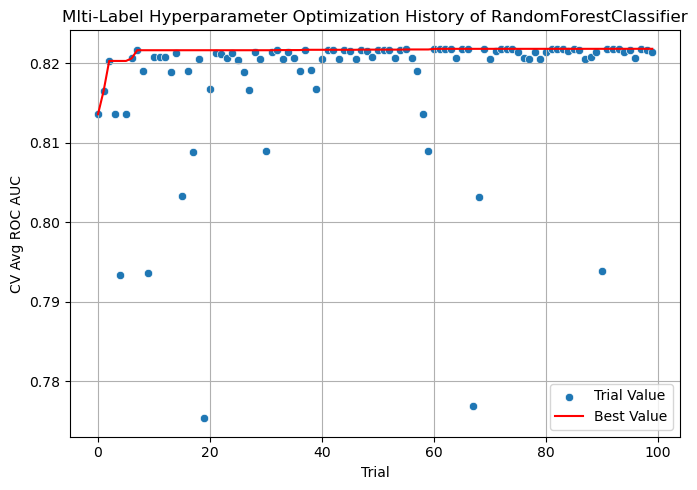

In [221]:
title = 'Mlti-Label Hyperparameter Optimization History of RandomForestClassifier'
plot_optimization_history(rf, by_label=False, title=title, figsize=(7, 5))

In [82]:
# Evaluate the model on the training set using the multilabel best params
base_estimator_cross_val_score(rf, X_train, y_train, by_label=False)

Weighted ROC AUC Score on Training Set: 0.8222


0.8222432014910019

In [222]:
# Evaluate the model on the validation set using the multilabel best params
evaluate(rf, by_label=False)

Weighted ROC AUC Score on Validation Set: 0.8259149855558516


0.8259149855558516

#### 2.3. Label-specific Hyperparameter Tuning

In [223]:
# Tune the hyperparameters for each label
optimize(
    base_model=rf,
    param_space=rf_param_space,
    by_label=True,
    n_trials=100,
    n_splits=5
)

Best Parameters for label Pastry: {'n_estimators': 818, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 10}
Best AUC Score for label Pastry: 0.8645919424451739
Best Parameters for label Z_Scratch: {'n_estimators': 719, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 8}
Best AUC Score for label Z_Scratch: 0.9519843324894415
Best Parameters for label K_Scatch: {'n_estimators': 1113, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 7}
Best AUC Score for label K_Scatch: 0.9852507925855647
Best Parameters for label Stains: {'n_estimators': 1473, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 6}
Best AUC Score for label Stains: 0.9913972474195498
Best Parameters for label Dirtiness: {'n_estimators': 1873, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 9}
Best AUC Score for label Dirtiness: 0.8763414834136538
Best Parameters for label Bumps: {'n_estimators': 1706, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 6}

{'Pastry': <optuna.study.study.Study at 0x21a1447c260>,
 'Z_Scratch': <optuna.study.study.Study at 0x21a13beb740>,
 'K_Scatch': <optuna.study.study.Study at 0x21a71800e90>,
 'Stains': <optuna.study.study.Study at 0x21a14411dc0>,
 'Dirtiness': <optuna.study.study.Study at 0x21a11943fb0>,
 'Bumps': <optuna.study.study.Study at 0x21a08a55340>,
 'Other_Faults': <optuna.study.study.Study at 0x21a59e03170>}

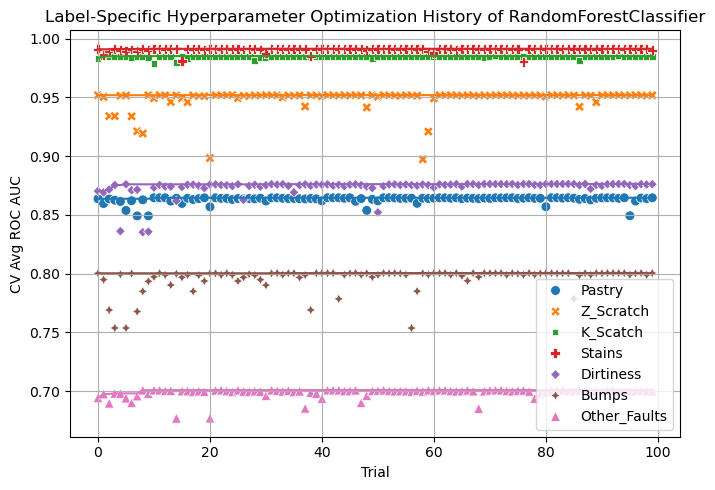

In [224]:
title = 'Label-Specific Hyperparameter Optimization History of RandomForestClassifier'
plot_optimization_history(rf, by_label=True, title=title, figsize=(7, 5))

In [81]:
# Evalute the model on the training set using the label-specific best params
base_estimator_cross_val_score(rf, X_train, y_train, by_label=True)

weights; [1165, 921, 2735, 446, 389, 3794, 5276]
Mean ROC AUC Score on Training Set: 0.8218


0.8217648997598241

In [225]:
# Evaluate the model on the validation set using the single label best params
evaluate(rf, by_label=True)

Training model for label: 'Pastry'...
ROC AUC Score for label 'Pastry': 0.8602

Training model for label: 'Z_Scratch'...
ROC AUC Score for label 'Z_Scratch': 0.9602

Training model for label: 'K_Scatch'...
ROC AUC Score for label 'K_Scatch': 0.9832

Training model for label: 'Stains'...
ROC AUC Score for label 'Stains': 0.9921

Training model for label: 'Dirtiness'...
ROC AUC Score for label 'Dirtiness': 0.8963

Training model for label: 'Bumps'...
ROC AUC Score for label 'Bumps': 0.8068

Training model for label: 'Other_Faults'...
ROC AUC Score for label 'Other_Faults': 0.7026

Weighted ROC AUC Score on Validation Set: 0.8262320138654438


0.8262320138654438

### 3. XGBoost Classifier

#### 3.0. Basic Model

According to [XGBoost Documentation](https://xgboost.readthedocs.io/en/stable/tutorials/multioutput.html), starting from version 1.6, XGBoost can support multilabel classification with Python package meaning it can be used for targets that have multiple non-exclusive class labels. However, since the model by itself returns the results in a shape that is incompatible with `cross_val_predict`, it is wrapped in `OneVsRestClassifier`.

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_proba = xgb.predict_proba(X_val)
print(f"'y_pred_proba' is of type {type(y_pred_proba)} of size {y_pred_proba.shape}\n")

print(f"ROC AUC Score on Validation Set: {roc_auc_score(y_val, y_pred_proba, average=None).round(3)}")
print(f"Weighted Average ROC AUC Score on Validation Set: {roc_auc_score(y_val, y_pred_proba, average='weighted').round(3)}")


In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb_ = OneVsRestClassifier(xgb)
cv = KFold(n_splits=5, shuffle=True, random_state=7)
y_pred_proba = cross_val_predict(xgb_, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1)
print(f"'y_pred_proba' is of type {type(y_pred_proba)} of size {y_pred_proba.shape}\n")

In [ ]:
# from xgboost import XGBClassifier

# param = {
#     'objective': 'binary:logistic',
#     'eval_metric': 'auc',
#     'booster': 'gbtree',
#     'device': 'gpu',
#     'seed': 7
# }

# imp_df = pd.DataFrame(index=train.columns)
# for col in target.columns:
#     xgb_clf = XGBClassifier(**param)
#     xgb_clf.fit(X_train, y_train[col])
#     imp_df[col] = xgb_clf.feature_importances_

In [ ]:
# imp_thr = 0.01
# print(f"Number of features selected for each target  with importance > {imp_thr}:\n")
# for col in target.columns:
#     # print(f'{col}:{imp_df[imp_df[col]>imp_thr][col].sort_values(ascending=False).index.tolist()}')
#     print(f'{col}: {len(imp_df[imp_df[col]>imp_thr][col].sort_values(ascending=False).index.tolist())}')



# ncols = 4
# nrows = ceil(len(target.columns)/ncols)
# fig, ax = plt.subplots(nrows, ncols, figsize=(15, 10))
# ax = ax.ravel()

# for i, col in enumerate(target.columns):
#     data = imp_df[col].sort_values(ascending=False)
#     sns.barplot(x=data, y=data.index, palette='flare', hue=data, ax=ax[i])
#     ax[i].set_title(f'{col}')
#     ax[i].set_ylabel('Features')
#     ax[i].set_xlabel('Importance')
    
# for j in range(i+1, len(ax)):
#     fig.delaxes(ax[j])
    
# plt.tight_layout()
# plt.show()

#### 3.1. Define Model and Parameter Space

In [24]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

def xgb_param_space(trial) -> dict:
    return {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'booster': 'gbtree',
        'device': 'cpu',
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'eta': trial.suggest_float('eta', 1e-2, 0.5, log=True),  # learning_rate
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma',1e-2, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-2, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-2, 1.0, log=True),
        'random_state': 7
    }

#### 3.2. Multilabel Hyperparameter Tuning

In [145]:
# Tune the hyperparameters for multilabel
optimize(
    base_model=xgb,
    param_space=xgb_param_space,
    by_label=False,
    n_trials=100,
    n_splits=5,
    n_jobs=-1
)

[I 2024-11-14 18:18:26,941] A new study created in RDB with name: XGBClassifier_multi
[I 2024-11-14 18:18:37,661] Trial 0 finished with value: 0.8090544788223747 and parameters: {'n_estimators': 1730, 'eta': 0.13521112223149398, 'max_depth': 2, 'min_child_weight': 5.456611766373852, 'gamma': 0.3042239294042091, 'subsample': 0.5886050069757272, 'colsample_bytree': 0.9601425407106907, 'lambda': 0.1398476717642557, 'alpha': 0.011861757425552516}. Best is trial 0 with value: 0.8090544788223747.
[I 2024-11-14 18:18:46,568] Trial 1 finished with value: 0.8184124690824667 and parameters: {'n_estimators': 1526, 'eta': 0.06342099854857453, 'max_depth': 2, 'min_child_weight': 1.1284962639534584, 'gamma': 0.02715854899152905, 'subsample': 0.7192241702673139, 'colsample_bytree': 0.7327687278010433, 'lambda': 0.2239808584515943, 'alpha': 0.1252062990053039}. Best is trial 1 with value: 0.8184124690824667.
[I 2024-11-14 18:18:51,337] Trial 2 finished with value: 0.8166221632543118 and parameters: {'

Best Parameters: {'n_estimators': 333, 'eta': 0.013431363082614733, 'max_depth': 6, 'min_child_weight': 9.464682057759969, 'gamma': 0.06368896334177497, 'subsample': 0.6913337328608735, 'colsample_bytree': 0.6282393210646918, 'lambda': 0.011818614676094056, 'alpha': 0.01624311357936343}
Best AUC Score: 0.8264276698718012


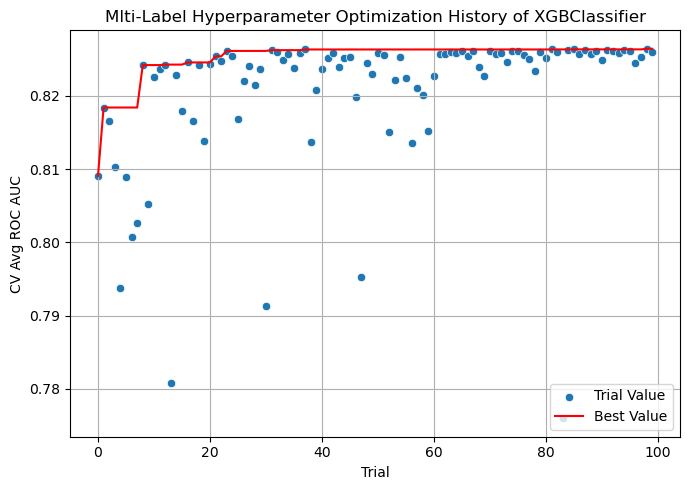

In [146]:
title = 'Mlti-Label Hyperparameter Optimization History of XGBClassifier'
plot_optimization_history(xgb, by_label=False, title=title, figsize=(7, 5))

In [147]:
retreive_best_params(xgb, by_label=False)

{'n_estimators': 333,
 'eta': 0.013431363082614733,
 'max_depth': 6,
 'min_child_weight': 9.464682057759969,
 'gamma': 0.06368896334177497,
 'subsample': 0.6913337328608735,
 'colsample_bytree': 0.6282393210646918,
 'lambda': 0.011818614676094056,
 'alpha': 0.01624311357936343}

In [80]:
# Evaluare the model on the training set using the multilabel best params
base_estimator_cross_val_score(xgb, X_train, y_train, by_label=False)

Weighted ROC AUC Score on Training Set: 0.8268


0.8268148132618908

In [148]:
# Evaluate the model on the validation set using the multilabel best params
evaluate(xgb, by_label=False)

Weighted ROC AUC Score on Validation Set: 0.8309835322946025


0.8309835322946025

##### 3.2.1. Analyzing misclassified instances

In [220]:
def get_pred_proba(base_model, by_label:bool):
    
    if by_label:
        best_params = retrieve_best_params(base_model, by_label=by_label)
        y_pred = pd.DataFrame(columns=y_val.columns)
        y_pred_proba = pd.DataFrame(columns=y_val.columns)
        for label in y_train.columns:           
            model = make_model(base_model, best_params[label], by_label=by_label)
            model.fit(X_train, y_train[label])
            y_pred[label] = model.predict(X_val)
            y_pred_proba[label] = model.predict_proba(X_val)[:,1]
    else:
        best_params = retrieve_best_params(base_model, by_label=by_label)
        model = make_model(base_model, best_params, by_label=by_label)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.to_numpy()
    if isinstance(y_pred_proba, pd.DataFrame):
        y_pred_proba = y_pred_proba.to_numpy()
    return y_pred, y_pred_proba

In [190]:
y_pred, y_pred_proba = get_pred_proba(xgb, by_label=False)

In [201]:
def get_misclassified_pred_proba(y_true:pd.DataFrame, y_pred, y_pred_proba):
    mis_df = {}
    
    for i, label in enumerate(y_true.columns):
        mis_indx = y_pred[:, i] != y_val.iloc[:, i]
        mis_df[label] = pd.DataFrame(X_val[mis_indx], columns=X_val.columns)
        mis_df[label]['true'] = y_val[mis_indx][label]
        mis_df[label]['pred'] = y_pred[mis_indx, i]
        mis_df[label]['pred_proba'] = y_pred_proba[mis_indx, i]
    
    return mis_df

In [202]:
mis_df = get_misclassified_pred_proba(y_val, y_pred, y_pred_proba)

In [194]:
from sklearn.metrics import ConfusionMatrixDisplay


def plot_confusion_matrix(y_true, y_pred, ncols, suptitle):
    nrows = ceil(y_true.shape[1]/ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize=(15, 3*nrows))
    ax = ax.flatten()
    for i in range(y_true.shape[1]):
        ConfusionMatrixDisplay.from_predictions(y_true.iloc[:,i], y_pred[:,i], normalize='true', ax=ax[i])
        ax[i].set_title(f"'{y_true.columns[i]}'", fontsize=12)
    for j in range(i+1, len(ax)):
        fig.delaxes(ax[j])
    fig.suptitle(suptitle, y=1.01, fontsize=14)
    plt.tight_layout()
    plt.show()


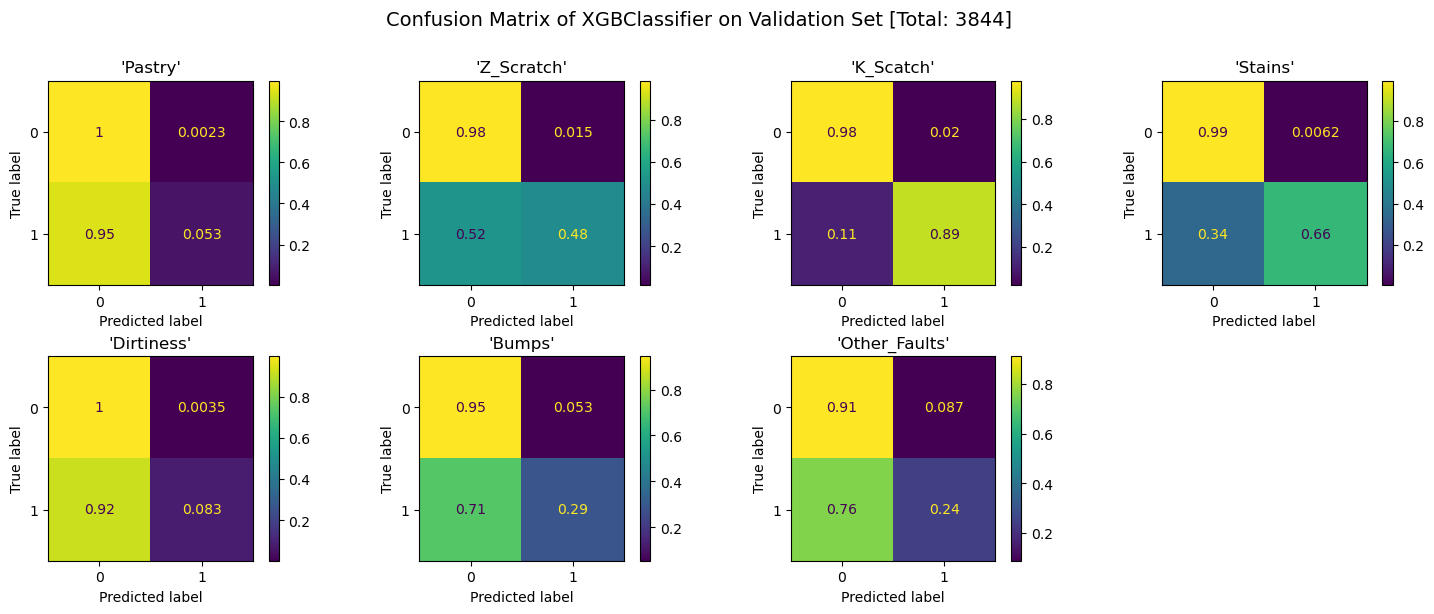

In [203]:
suptitle = f'Confusion Matrix of XGBClassifier on Validation Set [Total: {y_val.shape[0]}]'
plot_confusion_matrix(y_val, y_pred, 4, suptitle)

The number of 'False Negative' is high for most labels. 'K_Scatch' is the lowest (11% of all positives).

In [204]:
def plot_misclassified_model_confidence_hist(mis_df:dict[pd.DataFrame], ncols:int):
    nrows = ceil(target.shape[1]/ncols)
    fig, axes = plt.subplots(nrows, ncols, sharey=True, figsize=(15, 3 * nrows))
    axes = axes.flatten()
    for i, label in enumerate(y_val.columns):
        sns.histplot(mis_df[label]['pred_proba'], stat='percent', bins=[0,0.5,1], color='skyblue', edgecolor='black', linewidth=0.5, ax=axes[i])
        axes[i].set_title(f"'{label}'")
        axes[i].set_xlabel('Predicted Probability')
        axes[i].set_ylabel('Percent')
        axes[i].set_ylim(0, 100)
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    plt.suptitle('Histograms of Misclassified Instances Confidence', y=1.01, fontsize=14)
    plt.tight_layout()
    plt.show()
        

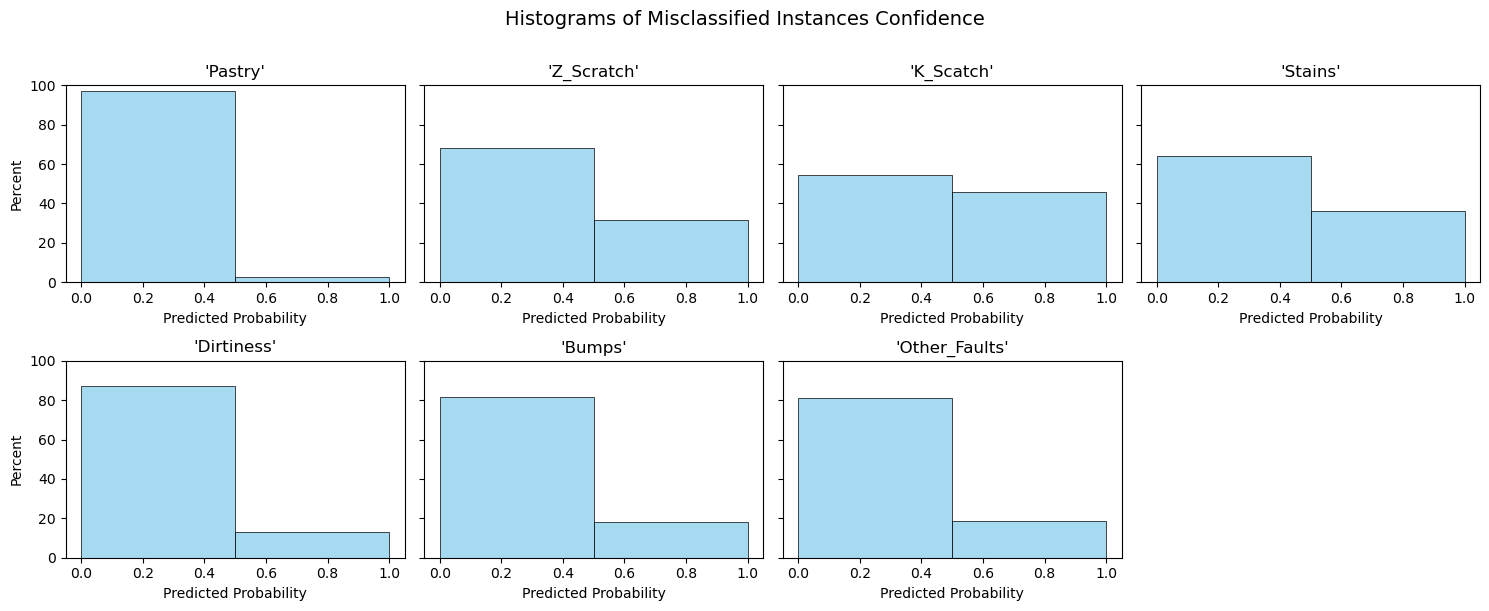

In [205]:
plot_misclassified_model_confidence_hist(mis_df, 4)

* For 'Pastry','Distiness', 'Bumps', 'Other_Faults', the prediction confidence of misclassified instances is mostly less than 0.50

#### 3.3. Label-specific Hyperparameter Tuning

In [149]:
# Tune the hyperparameters for each label
optimize(
    base_model=xgb,
    param_space=xgb_param_space,
    by_label=True,
    n_trials=100,
    n_splits=5,
    n_jobs=-1
)

Best Parameters for label Pastry: {'n_estimators': 1343, 'eta': 0.013629639604211931, 'max_depth': 3, 'min_child_weight': 3.424000649373171, 'gamma': 0.44370876288450967, 'subsample': 0.5042634520738455, 'colsample_bytree': 0.8597351530154235, 'lambda': 0.028893224270883915, 'alpha': 0.06750361109893048}
Best AUC Score for label Pastry: 0.8693309130667214
Best Parameters for label Z_Scratch: {'n_estimators': 795, 'eta': 0.010765727844984896, 'max_depth': 4, 'min_child_weight': 3.896259192764848, 'gamma': 0.019304392918547013, 'subsample': 0.9872706562195175, 'colsample_bytree': 0.519043180227142, 'lambda': 0.012023403878039112, 'alpha': 0.05276603021403907}
Best AUC Score for label Z_Scratch: 0.9606376408170169
Best Parameters for label K_Scatch: {'n_estimators': 413, 'eta': 0.012431231142201689, 'max_depth': 5, 'min_child_weight': 2.928434637464067, 'gamma': 0.047060008568273526, 'subsample': 0.7839797146099005, 'colsample_bytree': 0.511142228379298, 'lambda': 0.1231783197826756, 'alp

{'Pastry': <optuna.study.study.Study at 0x21a081ed430>,
 'Z_Scratch': <optuna.study.study.Study at 0x21a59d2d430>,
 'K_Scatch': <optuna.study.study.Study at 0x21a4d281ac0>,
 'Stains': <optuna.study.study.Study at 0x21a087ed430>,
 'Dirtiness': <optuna.study.study.Study at 0x21a4f1dbdd0>,
 'Bumps': <optuna.study.study.Study at 0x21a5e6432c0>,
 'Other_Faults': <optuna.study.study.Study at 0x21a08025430>}

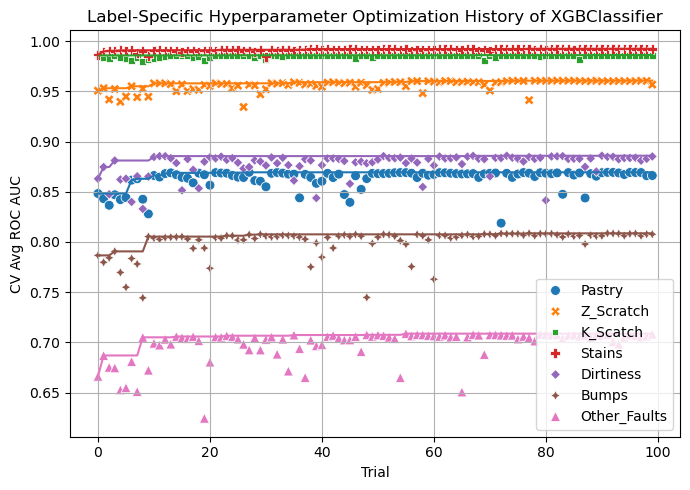

In [150]:
title = 'Label-Specific Hyperparameter Optimization History of XGBClassifier'
plot_optimization_history(xgb, by_label=True, title=title, figsize=(7, 5))

In [79]:
# Evaluare the model on the training set using the single label best params
base_estimator_cross_val_score(xgb, X_train, y_train, by_label=True)

weights; [1165, 921, 2735, 446, 389, 3794, 5276]
Mean ROC AUC Score on Training Set: 0.8277


0.8276770532332973

In [151]:
# Evaluate the model on the validation set using the label-specific best params
evaluate(xgb, by_label=True)

Training model for label: 'Pastry'...
ROC AUC Score for label 'Pastry': 0.8626

Training model for label: 'Z_Scratch'...
ROC AUC Score for label 'Z_Scratch': 0.9639

Training model for label: 'K_Scatch'...
ROC AUC Score for label 'K_Scatch': 0.9841

Training model for label: 'Stains'...
ROC AUC Score for label 'Stains': 0.9934

Training model for label: 'Dirtiness'...
ROC AUC Score for label 'Dirtiness': 0.9130

Training model for label: 'Bumps'...
ROC AUC Score for label 'Bumps': 0.8134

Training model for label: 'Other_Faults'...
ROC AUC Score for label 'Other_Faults': 0.7045

Weighted ROC AUC Score on Validation Set: 0.8296685920623988


0.8296685920623988

In [221]:
y_pred, y_pred_proba = get_pred_proba(xgb, by_label=True)

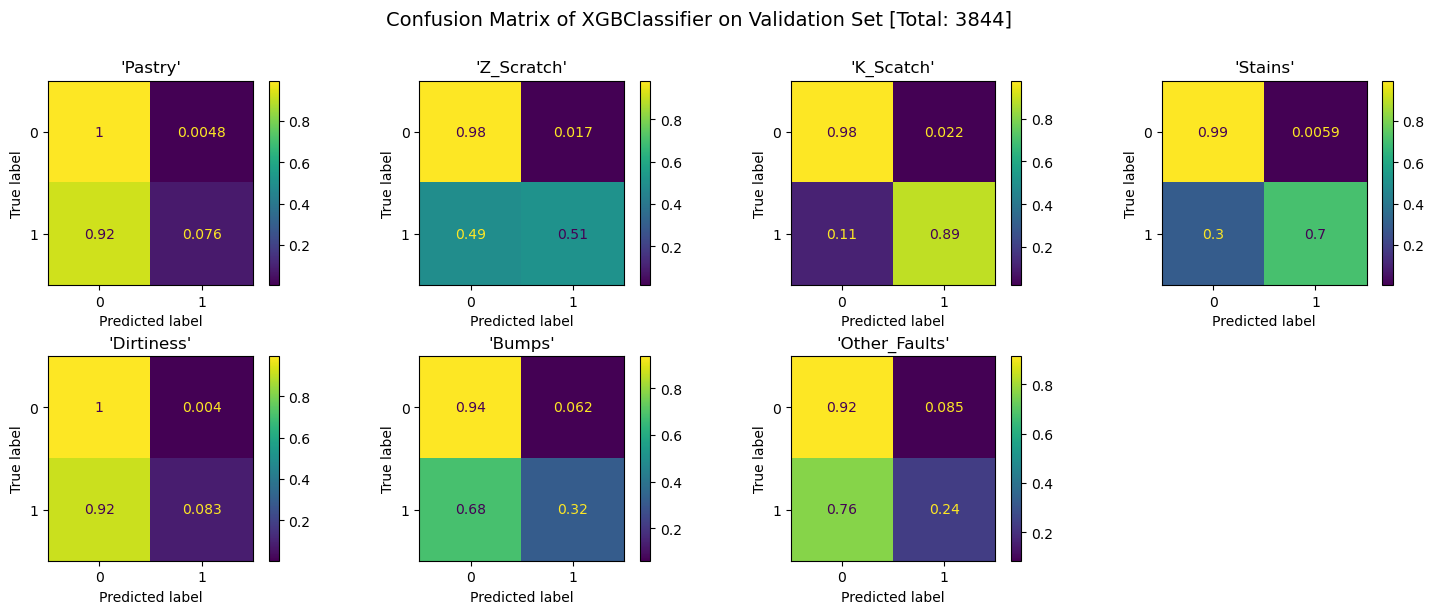

In [223]:
subtitle = f'Confusion Matrix of XGBClassifier on Validation Set [Total: {y_val.shape[0]}]'
plot_confusion_matrix(y_val, y_pred, 4, suptitle)

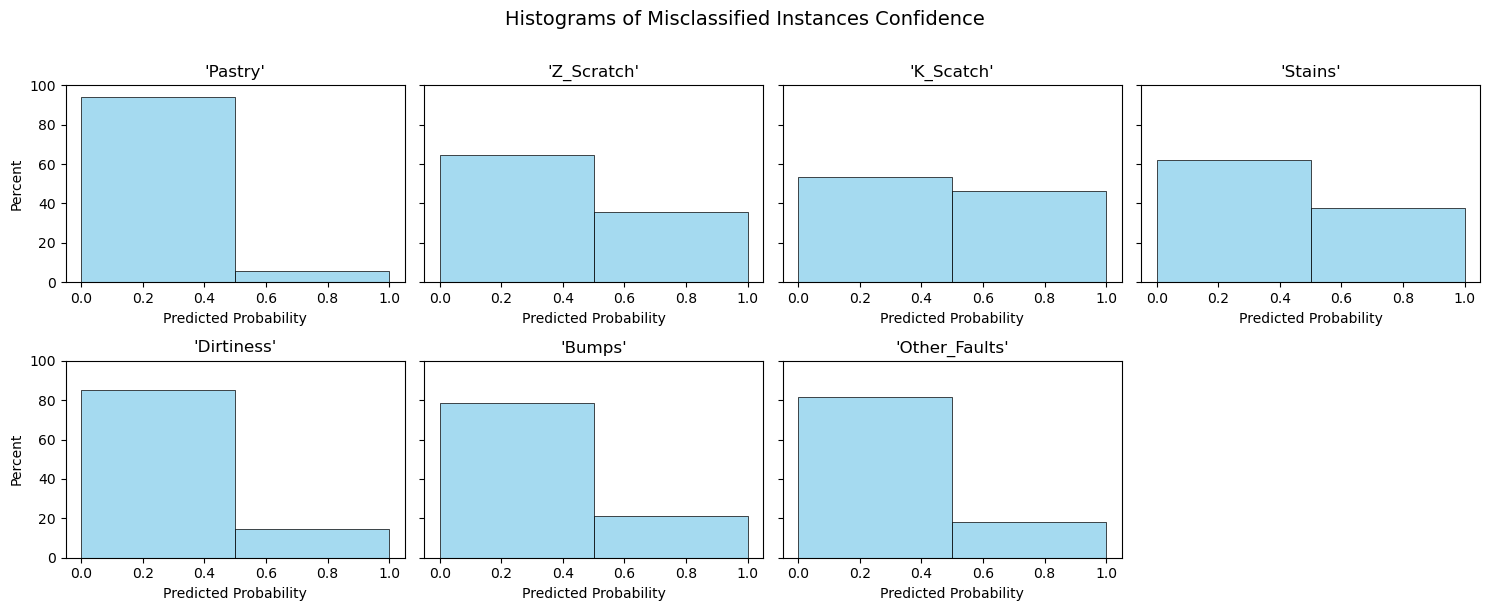

In [224]:
mid_df = get_misclassified_pred_proba(y_val, y_pred, y_pred_proba)
plot_misclassified_model_confidence_hist(mid_df, 4)

In [ ]:
# # Find the best parameters for each label independently (one set of parameters per label)

# import optuna
# import xgboost as xgb
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import make_scorer, roc_auc_score

# optuna.logging.set_verbosity(optuna.logging.ERROR)

# # Function to perform hyperparameter tuning for each label
# def tune_model_for_each_label(X_train, y_train, filename='best_params.json'):
#     best_params = {}
#     best_scores = {}

#     for label in y_train.columns:
#         print(f"Tuning for label '{label}'...")

#         # Define the objective function for Optuna
#         def objective(trial):

#             param = {
#                 'objective': 'binary:logistic',
#                 'eval_metric': 'auc',
#                 'booster': 'gbtree',
#                 'device': 'gpu',
#                 'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
#                 'eta': trial.suggest_float('eta', 1e-3, 0.1, log=True),  # learning_rate
#                 'max_depth': trial.suggest_int('max_depth', 2, 10),
#                 'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0, log=True),
#                 'gamma': trial.suggest_float('gamma', 0, 1.0),
#                 'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#                 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#                 'lambda': trial.suggest_float('lambda', 1e-3, 1.0, log=True),
#                 'alpha': trial.suggest_float('alpha', 1e-3, 1.0, log=True),
#                 'random_state': 7
#             }

#             model = Pipeline(steps=[
#                 ('prep', StandardScaler()),
#                 ('clf', xgb.XGBClassifier(**param))
#             ])
            
#             auc_scorer = make_scorer(roc_auc_score)
                       
#             scores = cross_val_score(model, X_train, y_train[label], cv=5, scoring=auc_scorer)

#             return scores.mean()

#         # Create a study and optimize it
#         study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=7))
#         study.optimize(objective, n_trials=100)

#         best_params[label] = study.best_params
#         best_scores[label] = study.best_value

#         print(f"Best Parameters for {label}: {study.best_params}")
#         print(f"Best AUC Score for {label}: {study.best_value}\n")
    
#     save_params(best_params, filename)
    
#     return best_params, best_scores


# best_params, best_scores = tune_model_for_each_label(X_train, y_train, filename='xgb_best_params_labels_1.json')


In [ ]:
# # Evalute the model on the validation set (by label)

# xgb = xgb.XGBClassifier(random_state=7)
# auc = evaluate_by_label(xgb, 'xgb_best_params_labels_1.json')

In [ ]:
# # One set of best params for all labels

# import optuna
# import xgboost as xgb
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import make_scorer, roc_auc_score
# from sklearn.multioutput import MultiOutputClassifier


# optuna.logging.set_verbosity(optuna.logging.INFO)


# def objective(trial):

#     param = {
#         'objective': 'binary:logistic',
#         'eval_metric': 'auc',
#         'booster': 'gbtree',
#         'device': 'gpu',
#         'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
#         'eta': trial.suggest_float('eta', 1e-2, 1.0, log=True),  # learning_rate
#         'max_depth': trial.suggest_int('max_depth', 2, 10),
#         'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0, log=True),
#         'gamma': trial.suggest_float('gamma', 0, 1.0),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'lambda': trial.suggest_float('lambda', 1e-3, 1.0, log=True),
#         'alpha': trial.suggest_float('alpha', 1e-3, 1.0, log=True), 
#     }

#     xgb = xgb.XGBClassifier(random_state= 7, **param)
#     model = MultiOutputClassifier(xgb)

#     cv = KFold(n_splits=5, shuffle=True, random_state=7)
#     y_pred_proba = cross_val_predict(model, X_train, y_train, cv=cv, method='predict_proba')
    
#     auc_scorer = make_scorer(roc_auc_score, average='weighted', multi_class='ovr')
                
#     scores = cross_val_score(model, X_train[features], y_train, cv=3, scoring=auc_scorer)

#     return scores.mean()


# study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=7))
# study.optimize(objective, n_trials=100)

# print("Best Parameters: ", study.best_params)
# print("Best AUC Score: ", study.best_value)

# save_params(study.best_params, 'xgb_best_params_all_2.json')

In [ ]:
# # Evalute the model on the validation set (all labels)

# xgb = xgb.XGBClassifier(random_state=7)
# wrapper = MultiOutputClassifier
# auc = evaluate_all(xgb, 'xgb_best_params_all_1.json', wrapper)

### 4. LightGBM

#### 4.0. Besic Model
The `lightgbm.LGBMClassifier` does not support multilabel classification. As a result a wrapper is needed for this model where the target is multilabel. Two wrappers compared below, `MultiOutputClassifier` and `OneVsRestClassifier`.

Both are suitable, as they do not account for dependencies between labels. However, if dependency modeling is needed, alternative approaches like `sklearn.multioutput.ClassifierChain` would be more suitable.

* __`OneVsRestClassifier`__

    Originally designed for multiclass classification, where each class label is treated as a binary classification problem. For multilabel tasks, it treats each label as an independent binary classification problem.

    Each model is trained to distinguish between one specific label and all other labels combined. In a multilabel context, this approach is effective, as each label can be independently "on" or "off" without depending on other labels.

    Treats each label as fully independent. This can work well for multilabel problems, especially if each label is indeed independent of the others.

    Trains a separate binary classifier for each label, which may be more efficient if the underlying model has optimized support for binary classification.

    It can sometimes be faster and more memory-efficient in binary classification-focused tasks compared to `MultiOutputClassifier`.

* __`MultiOutputClassifier`__

    Created for multioutput tasks, where the outputs can be either binary or multiclass. Each output is predicted independently, making it general-purpose for both multioutput and multilabel use cases. Works well when each output (label) can be modeled independently, like in multilabel classification.

    Similarly treats labels as independent, though it is explicitly designed to handle multiple target outputs in both binary and multiclass contexts.

    Also trains one classifier per label, but the overhead might be slightly higher if it is not well-optimized for binary-only tasks. In practice, the difference is often minimal but can vary depending on the specific model used.

Both wrappers resulted in the same result in terms of ROC AUC score. The target analysis that is performed in earlier section, shows that the targets are independent, so no need to use `ClassifierChain`. Since `OneVsRestClassifier` performs slightly more efficient, it is used for this modeling.


In [298]:
from lightgbm import LGBMClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier

lgb = LGBMClassifier(random_state=7, verbose=-1)
lgb_moc = MultiOutputClassifier(lgb)
lgb_ovr = OneVsRestClassifier(lgb)

lgb_moc.fit(X_train, y_train)
lgb_ovr.fit(X_train, y_train)

print("MultiOutputClassifier:")
y_pred_proba_moc = lgb_moc.predict_proba(X_val)
y_pred_proba_moc_positive = np.array([proba[:, 1] for proba in y_pred_proba_moc]).T
print(f"'y_pred_proba_moc' is of type {type(y_pred_proba_moc)} with {len(y_pred_proba_moc)} each of shape {y_pred_proba_moc[0].shape}")
print(f"ROC AUC Score on Validation Set: {roc_auc_score(y_val, y_pred_proba_moc_positive, average=None).round(3)}")
print(f"Weighted Average ROC AUC Score on Validation Set: {roc_auc_score(y_val, y_pred_proba_moc_positive, average='weighted').round(3)}\n")

print("OneVsRestClassifier:")
y_pred_proba_ovr = lgb_ovr.predict_proba(X_val)
print(f"'y_pred_proba_ovr' is of type {type(y_pred_proba_ovr)} of size {y_pred_proba_ovr.shape}")
print(f"ROC AUC Score on Validation Set: {roc_auc_score(y_val, y_pred_proba_ovr, average=None).round(3)}")
print(f"Weighted Average ROC AUC Score on Validation Set: {roc_auc_score(y_val, y_pred_proba_ovr, average='weighted').round(3)}")

MultiOutputClassifier:
'y_pred_proba_moc' is of type <class 'list'> with 7 each of shape (3844, 2)
ROC AUC Score on Validation Set: [0.853 0.961 0.983 0.992 0.889 0.808 0.702]
Weighted Average ROC AUC Score on Validation Set: 0.826

OneVsRestClassifier:
'y_pred_proba_ovr' is of type <class 'numpy.ndarray'> of size (3844, 7)
ROC AUC Score on Validation Set: [0.853 0.961 0.983 0.992 0.889 0.808 0.702]
Weighted Average ROC AUC Score on Validation Set: 0.826


#### 4.1. Define Model and Parameter Space

In [300]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier()

def lgb_param_space(trial) -> dict:
    return {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'device_type': 'cpu',
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'num_leaves': trial.suggest_int('num_leaves', 2, 100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-2, 0.5, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        # 'bagging_fraction': trial.suggest_float('bagging_fraction', 0.8, 1.0),
        # 'bagging_freq': trial.suggest_int('bagging_freq', 0, 10),
        'pos_bagging_fraction': trial.suggest_float('pos_bagging_fraction', 0.5, 1.0),
        'neg_bagging_fraction': trial.suggest_float('neg_bagging_fraction', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-2, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 1.0, log=True),
        'random_state': 7,
        'verbose': -1
    }

#### 4.2. Multilabel Hyperparameter Tuning

In [154]:
# Tune the hyperparameters for multilabel
optimize(
    base_model=lgb,
    param_space=lgb_param_space,
    by_label=False,
    n_trials=100,
    n_splits=5,
    n_jobs=-1
)

[I 2024-11-14 20:21:05,970] A new study created in RDB with name: LGBMClassifier_multi
[I 2024-11-14 20:21:27,201] Trial 0 finished with value: 0.7972568694347946 and parameters: {'n_estimators': 1105, 'num_leaves': 81, 'learning_rate': 0.22731841478107198, 'max_depth': 8, 'pos_bagging_fraction': 0.6643474415762354, 'neg_bagging_fraction': 0.8635986077819331, 'reg_alpha': 0.26052805547555646, 'reg_lambda': 0.34721363187116094}. Best is trial 0 with value: 0.7972568694347946.
[I 2024-11-14 20:21:41,356] Trial 1 finished with value: 0.7971099600793999 and parameters: {'n_estimators': 1588, 'num_leaves': 15, 'learning_rate': 0.18974422529702592, 'max_depth': 10, 'pos_bagging_fraction': 0.8187350672390377, 'neg_bagging_fraction': 0.8966626109072426, 'reg_alpha': 0.7875026157559962, 'reg_lambda': 0.06345873082518728}. Best is trial 0 with value: 0.7972568694347946.
[I 2024-11-14 20:22:30,395] Trial 2 finished with value: 0.8057578248797815 and parameters: {'n_estimators': 1363, 'num_leaves'

Best Parameters: {'n_estimators': 365, 'num_leaves': 45, 'learning_rate': 0.038360263156017774, 'max_depth': 3, 'pos_bagging_fraction': 0.7370810382218473, 'neg_bagging_fraction': 0.6577799948482238, 'reg_alpha': 0.9934396602190427, 'reg_lambda': 0.15375768771707354}
Best AUC Score: 0.8253909770639627


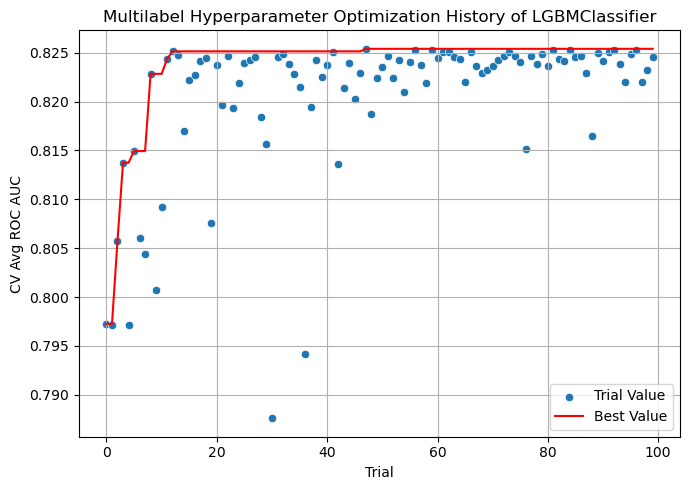

In [155]:
title = 'Multilabel Hyperparameter Optimization History of LGBMClassifier'
figsize = (7, 5)
plot_optimization_history(lgb, by_label=False, title=title, figsize=figsize)

In [77]:
# Evaluate the model on the training set using the multilabel best params
base_estimator_cross_val_score(lgb, X_train, y_train, by_label=False)

Weighted ROC AUC Score on Training Set: 0.8258


0.8257877302122596

In [156]:
# Evaluate the model on the validation set using the multilabel best params
evaluate(lgb, by_label=False)

Weighted ROC AUC Score on Validation Set: 0.826539195319589


0.826539195319589

[LightGBM] [Info] Number of positive: 1165, number of negative: 14210
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3108
[LightGBM] [Info] Number of data points in the train set: 15375, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.075772 -> initscore=-2.501225
[LightGBM] [Info] Start training from score -2.501225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

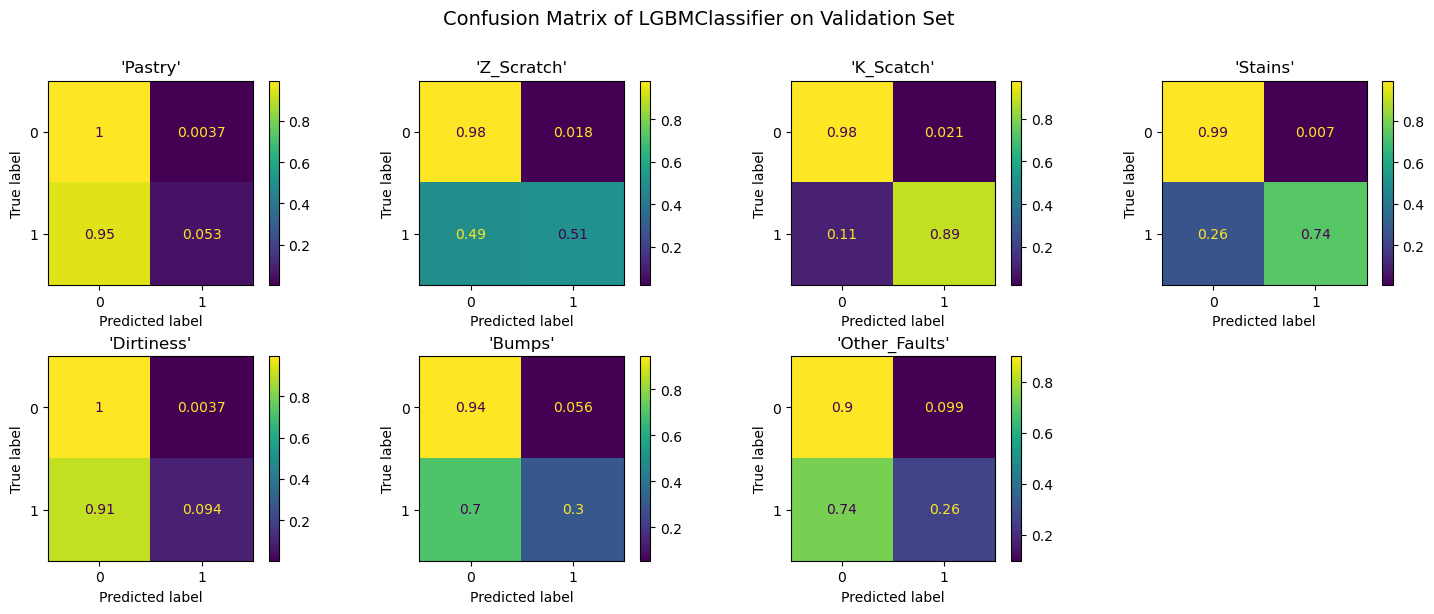

In [225]:
y_pred, y_pred_proba = get_pred_proba(lgb, by_label=False)
plot_confusion_matrix(y_val, y_pred, 4, 'Confusion Matrix of LGBMClassifier on Validation Set')

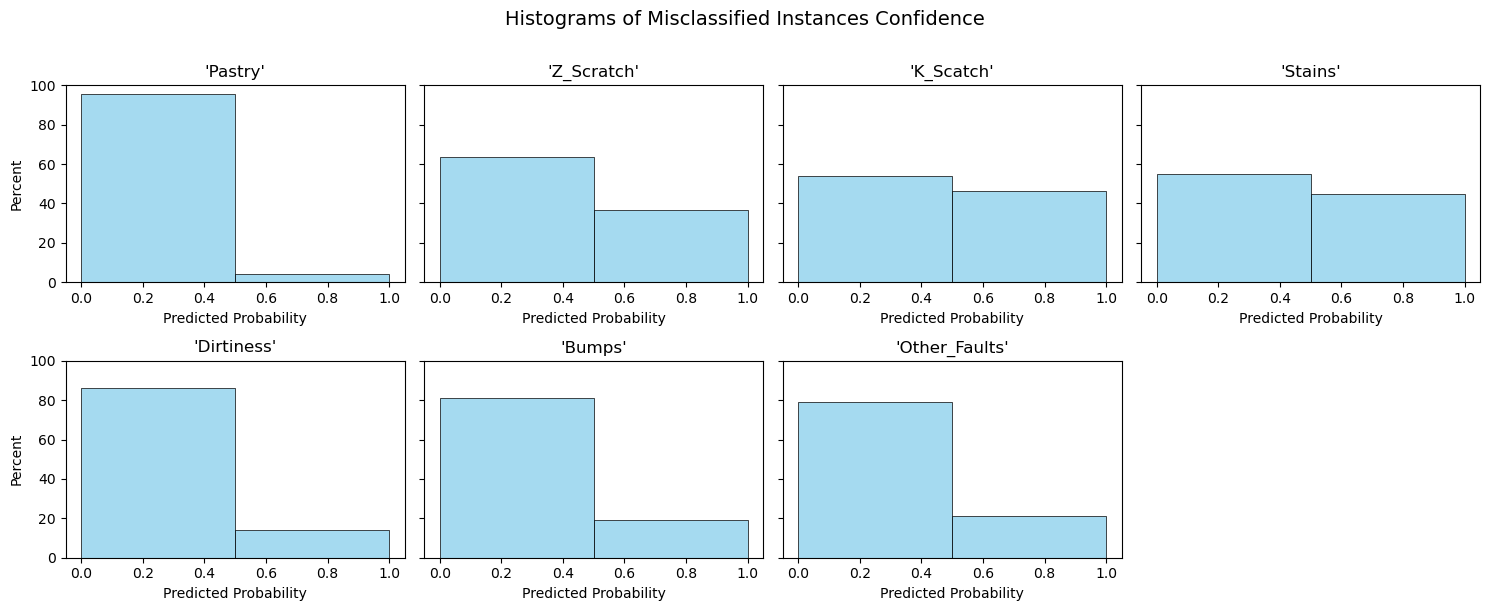

In [226]:
mid_df = get_misclassified_pred_proba(y_val, y_pred, y_pred_proba)
plot_misclassified_model_confidence_hist(mid_df, 4)

#### 4.3. Label-Specific Hyperparameter Tuning

In [157]:
# Tune the hyperparameters for each label
optimize(
    base_model=lgb,
    param_space=lgb_param_space,
    by_label=True,
    n_trials=100,
    n_splits=5,
    n_jobs=-1
)

Best Parameters for label Pastry: {'n_estimators': 1325, 'num_leaves': 41, 'learning_rate': 0.033360204146666524, 'max_depth': 2, 'pos_bagging_fraction': 0.5914017049642232, 'neg_bagging_fraction': 0.5936658750282464, 'reg_alpha': 0.10632425681178342, 'reg_lambda': 0.39329445221263803}
Best AUC Score for label Pastry: 0.8665997771019018
Best Parameters for label Z_Scratch: {'n_estimators': 386, 'num_leaves': 46, 'learning_rate': 0.01830878618974636, 'max_depth': 4, 'pos_bagging_fraction': 0.5879402098395017, 'neg_bagging_fraction': 0.9967141275180811, 'reg_alpha': 0.6136006530199455, 'reg_lambda': 0.010054652812473877}
Best AUC Score for label Z_Scratch: 0.9586300738859752
Best Parameters for label K_Scatch: {'n_estimators': 679, 'num_leaves': 25, 'learning_rate': 0.014764357589357608, 'max_depth': 4, 'pos_bagging_fraction': 0.8018779998649975, 'neg_bagging_fraction': 0.7077820280727207, 'reg_alpha': 0.740779349993412, 'reg_lambda': 0.3482248833589113}
Best AUC Score for label K_Scatch

{'Pastry': <optuna.study.study.Study at 0x21a08c3d430>,
 'Z_Scratch': <optuna.study.study.Study at 0x21a08e6d430>,
 'K_Scatch': <optuna.study.study.Study at 0x21a082fd430>,
 'Stains': <optuna.study.study.Study at 0x21a086e1b80>,
 'Dirtiness': <optuna.study.study.Study at 0x21a0959d1c0>,
 'Bumps': <optuna.study.study.Study at 0x21a08557500>,
 'Other_Faults': <optuna.study.study.Study at 0x21a09705430>}

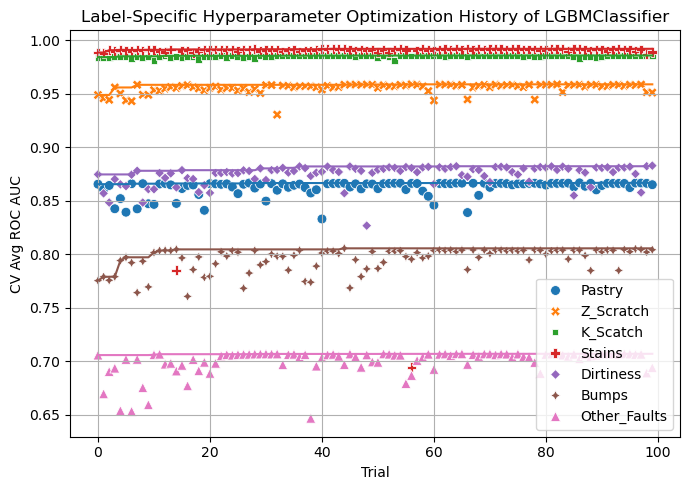

In [158]:
title = 'Label-Specific Hyperparameter Optimization History of LGBMClassifier'
figsize = (7, 5)
plot_optimization_history(lgb, by_label=True, title=title, figsize=figsize)

In [72]:
# Evaluate the model on the training set using the label-specific best params
base_estimator_cross_val_score(lgb, X_train, y_train, by_label=True)

weights; [1165, 921, 2735, 446, 389, 3794, 5276]
Mean ROC AUC Score on Training Set: 0.8263


0.8262890840926398

In [159]:
# Evaluate the model on the validation set using the label-specific best params
evaluate(lgb, by_label=True)

Training model for label: 'Pastry'...
ROC AUC Score for label 'Pastry': 0.8618

Training model for label: 'Z_Scratch'...
ROC AUC Score for label 'Z_Scratch': 0.9621

Training model for label: 'K_Scatch'...
ROC AUC Score for label 'K_Scatch': 0.9831

Training model for label: 'Stains'...
ROC AUC Score for label 'Stains': 0.9940

Training model for label: 'Dirtiness'...
ROC AUC Score for label 'Dirtiness': 0.9009

Training model for label: 'Bumps'...
ROC AUC Score for label 'Bumps': 0.8119

Training model for label: 'Other_Faults'...
ROC AUC Score for label 'Other_Faults': 0.7027

Weighted ROC AUC Score on Validation Set: 0.8280117196198541


0.8280117196198541

[LightGBM] [Info] Number of positive: 1165, number of negative: 14210
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3108
[LightGBM] [Info] Number of data points in the train set: 15375, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.075772 -> initscore=-2.501225
[LightGBM] [Info] Start training from score -2.501225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

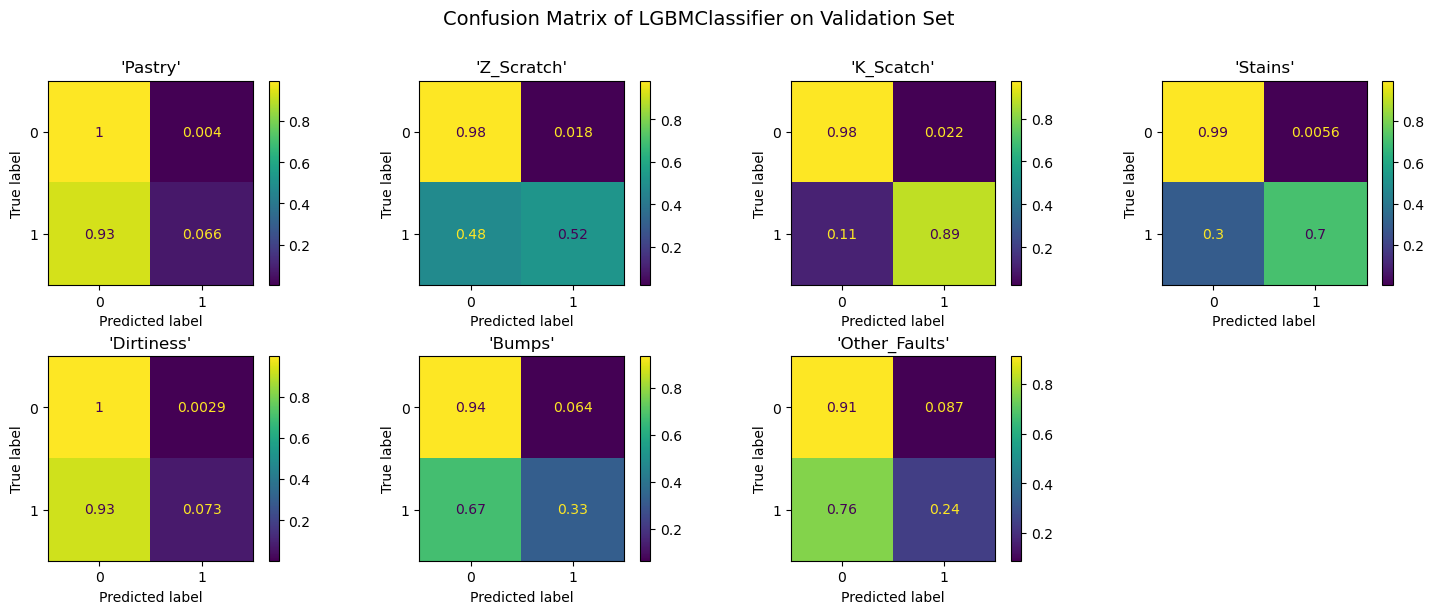

In [227]:
y_pred, y_pred_proba = get_pred_proba(lgb, by_label=True)
plot_confusion_matrix(y_val, y_pred, 4, 'Confusion Matrix of LGBMClassifier on Validation Set')

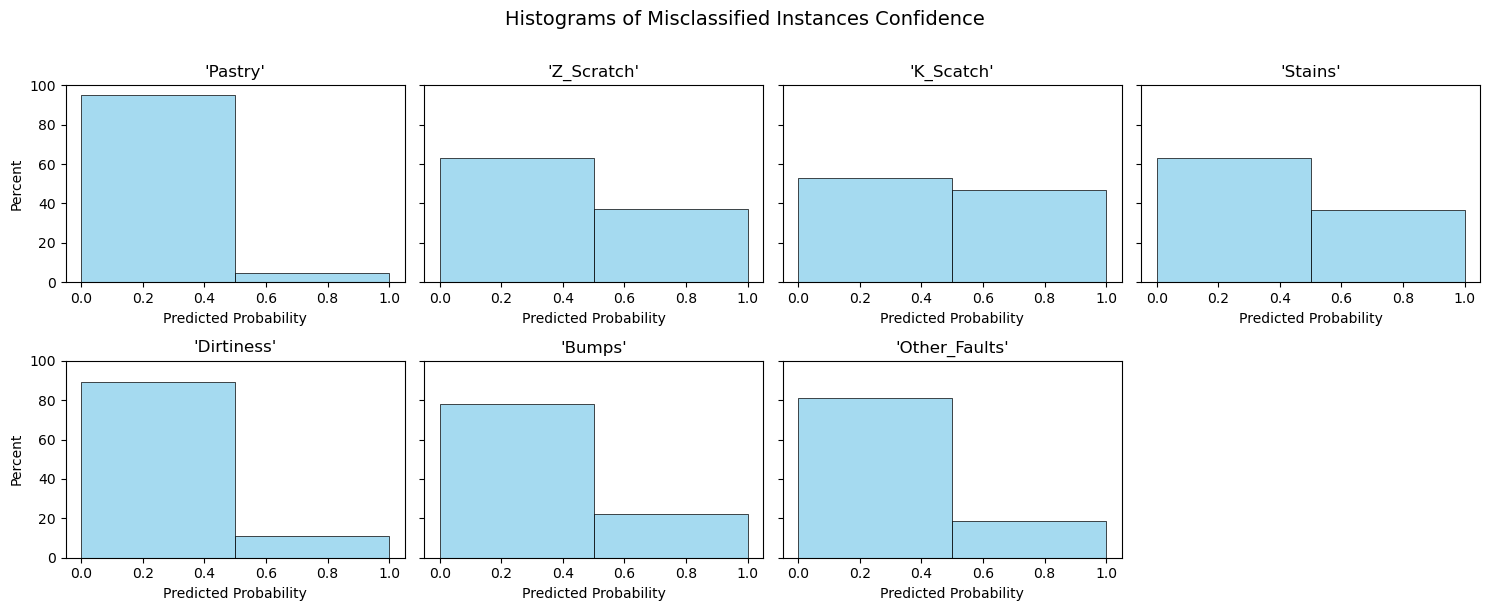

In [228]:
mid_df = get_misclassified_pred_proba(y_val, y_pred, y_pred_proba)
plot_misclassified_model_confidence_hist(mid_df, 4)

#### 4.4. Label-specific Hyperparameter Tuning Using Balanced Dataset

In [320]:
# Tune the hyperparameters for each label
optimize(
    base_model=lgb,
    param_space=lgb_param_space,
    X=X_train,
    y=y_train,
    by_label=True,
    n_trials=50,
    n_splits=5,
    n_jobs=-1,
    suffix = '_comb_samp',
    sampled = True
)

Best Parameters for label Pastry: {'n_estimators': 763, 'num_leaves': 71, 'learning_rate': 0.10861858253082597, 'max_depth': 10, 'pos_bagging_fraction': 0.6831147583921645, 'neg_bagging_fraction': 0.7283028025774836, 'reg_alpha': 0.012788725848793014, 'reg_lambda': 0.03549125402597582}
Best AUC Score for label Pastry: 0.9956829555864243
Best Parameters for label Z_Scratch: {'n_estimators': 1497, 'num_leaves': 40, 'learning_rate': 0.09958277635305304, 'max_depth': 6, 'pos_bagging_fraction': 0.8294328717512796, 'neg_bagging_fraction': 0.7159196506397432, 'reg_alpha': 0.05226325134762685, 'reg_lambda': 0.010077770554473129}
Best AUC Score for label Z_Scratch: 0.9985345128400144
Best Parameters for label K_Scatch: {'n_estimators': 355, 'num_leaves': 62, 'learning_rate': 0.16034928799019563, 'max_depth': 2, 'pos_bagging_fraction': 0.5003516743108256, 'neg_bagging_fraction': 0.5807355995274803, 'reg_alpha': 0.10180487445947851, 'reg_lambda': 0.016346175141530965}
Best AUC Score for label K_S

{'Pastry': <optuna.study.study.Study at 0x23b28dfb9b0>,
 'Z_Scratch': <optuna.study.study.Study at 0x23b5bc1a900>,
 'K_Scatch': <optuna.study.study.Study at 0x23b4071fbc0>,
 'Stains': <optuna.study.study.Study at 0x23b401bcb00>,
 'Dirtiness': <optuna.study.study.Study at 0x23b389242c0>,
 'Bumps': <optuna.study.study.Study at 0x23b402a7f80>,
 'Other_Faults': <optuna.study.study.Study at 0x23b3f964200>}

In [324]:
# Evaluation on the training set using the label-specific best params
base_estimator_cross_val_score(lgb, X_train, y_train, by_label=True, suffix='_comb_samp', sampled=True)

weights; [10474, 11137, 10949, 12558, 12235, 6479, 3726]
Mean ROC AUC Score on Training Set: 0.9934


0.993438401667196

In [328]:
evaluate(lgb, X_train, y_train, by_label=True, suffix='_comb_samp', sampled=True)

Training model for label: 'Pastry'...
ROC AUC Score for label 'Pastry': 0.8322

Training model for label: 'Z_Scratch'...
ROC AUC Score for label 'Z_Scratch': 0.9488

Training model for label: 'K_Scatch'...
ROC AUC Score for label 'K_Scatch': 0.9768

Training model for label: 'Stains'...
ROC AUC Score for label 'Stains': 0.9931

Training model for label: 'Dirtiness'...
ROC AUC Score for label 'Dirtiness': 0.8476

Training model for label: 'Bumps'...
ROC AUC Score for label 'Bumps': 0.7778

Training model for label: 'Other_Faults'...
ROC AUC Score for label 'Other_Faults': 0.6594

Weighted ROC AUC Score on Validation Set: 0.7982083694208659


0.7982083694208659

### 5. CatBoost

#### 5.0. Basice Model
Similar to `XGBoostClassifier`, the `CatBoostClassifier` can support multiclass problems. However, since the model by itself returns the results in a shape that is incompatible with `cross_val_predict`, it is wrapped in `OneVsRestClassifier`.

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

cat = CatBoostClassifier(random_seed=7, loss_function='MultiLogloss', verbose=0)
cat.fit(X_train, y_train)

y_pred_proba = cat.predict_proba(X_val)
print(f"'y_pred_proba' is of type {type(y_pred_proba)} of size {y_pred_proba.shape}\n")

print(f"ROC AUC Score on Validation Set: {roc_auc_score(y_val, y_pred_proba, average=None).round(3)}")
print(f"Weighted Average ROC AUC Score on Validation Set: {roc_auc_score(y_val, y_pred_proba, average='weighted').round(3)}")

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

cat = CatBoostClassifier(random_seed=7, loss_function='MultiLogloss', verbose=0)
cat_ = OneVsRestClassifier(cat)

cv = KFold(n_splits=3, shuffle=True, random_state=7)
y_pred_proba = cross_val_predict(cat_, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1)

In [188]:
y_pred_proba.shape

(15375, 7)

In [193]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

cat = CatBoostClassifier(random_seed=7, loss_function='MultiLogloss', verbose=0)
cat_ = OneVsRestClassifier(cat)

cv = KFold(n_splits=3, shuffle=True, random_state=7)
y_pred_proba = cross_val_predict(cat_, X_train, y_train['Pastry'], cv=cv, method='predict_proba', n_jobs=-1)
print(y_pred_proba.shape)

y_pred_proba_positive = y_pred_proba[:, 1]

score = roc_auc_score(y_train['Pastry'], y_pred_proba_positive)

(15375, 2)


#### 5.1. Define Model and Parameter Space

In [26]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

cat = CatBoostClassifier()


# The following custom metric cause issue with the optimization process
# 'cross_val_predict' cannot clone the model with the custom metric
# Solution: (1) removing the custom metric, (2) wrapping the model in a custom class, (3) using manual 'cross_val_predict'

# def custom_multilabel_auc(y_true, y_pred):
#     auc_scores = []
#     weights = []
#     for i in range(y_true.shape[1]):
#         try:
#             auc_scores.append(roc_auc_score(y_true[:, i], y_pred[:, i]))
#         except ValueError:
#             # If a label has only one class present in the y_true, skip
#             auc = np.nan
#         auc_scores.append(auc)
#         weights.append(np.sum(y_true[:, i] == 1))
        
#     return np.average(auc_scores, weights=weights)


# def catboost_auc_metric(y_true, y_pred):
#     y_pred_proba = y_pred.reshape(y_true.shape)
#     return custom_multilabel_auc(y_true, y_pred_proba), [] # [] indicates no extra parameters

def cat_param_space(trial) -> dict:
    return {
        "loss_function": "MultiLogloss", # alias: objective
        # "custom_metric": [catboost_auc_metric],
        "iterations": trial.suggest_int("iterations", 100, 2000, step=25), # alias: n_estimators
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True), # alias: eta
        "depth": trial.suggest_int("depth", 2, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10, log=True), # alias: reg_lambda
        "border_count": trial.suggest_int("border_count", 2, 255), # alias: max_bin
        "random_strength": trial.suggest_float("random_strength", 0.0, 1.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "random_seed": 7,
        "verbose": 0
    }

#### 5.2. Multilabel Hyperparameter Tuning

In [168]:
# Tune the hyperparameters for multilabel
optimize(
    base_model=cat,
    param_space=cat_param_space,
    by_label=False,
    n_trials=100,
    n_splits=5,
    n_jobs=-1
)

[I 2024-11-14 21:24:53,928] A new study created in RDB with name: CatBoostClassifier_multi
[I 2024-11-14 21:25:11,960] Trial 0 finished with value: 0.8080276776234417 and parameters: {'iterations': 525, 'learning_rate': 0.13985976817557957, 'depth': 7, 'l2_leaf_reg': 3.518201296395949, 'border_count': 151, 'random_strength': 0.175450957718714, 'bagging_temperature': 0.1480650415751641}. Best is trial 0 with value: 0.8080276776234417.
[I 2024-11-14 21:26:00,404] Trial 1 finished with value: 0.8066508615396585 and parameters: {'iterations': 1900, 'learning_rate': 0.02769763713477537, 'depth': 9, 'l2_leaf_reg': 2.7923737111686084, 'border_count': 12, 'random_strength': 0.696200760517653, 'bagging_temperature': 0.18809256078547076}. Best is trial 0 with value: 0.8080276776234417.
[I 2024-11-14 21:26:14,151] Trial 2 finished with value: 0.8123499554969876 and parameters: {'iterations': 775, 'learning_rate': 0.25300071420888853, 'depth': 3, 'l2_leaf_reg': 5.932721571433124, 'border_count': 1

Best Parameters: {'iterations': 925, 'learning_rate': 0.012629850943456767, 'depth': 6, 'l2_leaf_reg': 8.586784873135196, 'border_count': 32, 'random_strength': 0.36319985219517625, 'bagging_temperature': 0.8641655060548328}
Best AUC Score: 0.8272551384477739


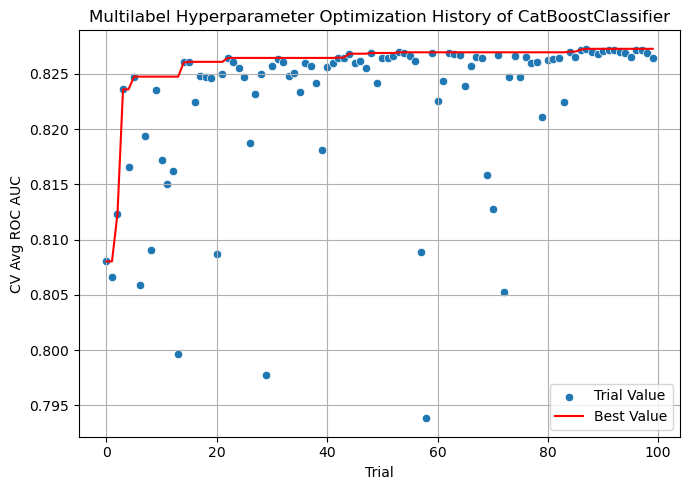

In [169]:
title = 'Multilabel Hyperparameter Optimization History of CatBoostClassifier'
plot_optimization_history(cat, by_label=False, title=title, figsize=(7, 5))

In [78]:
# Evaluate the model on the training set using the multilabel best params
base_estimator_cross_val_score(cat, X_train, y_train, by_label=False)


Weighted ROC AUC Score on Training Set: 0.8265


0.8265347373805005

In [170]:
# Evaluate the model on the validation set using the multilabel best params
evaluate(cat, by_label=False)

Weighted ROC AUC Score on Validation Set: 0.8320411602100263


0.8320411602100263

#### 5.3. Label-Specific Hyperparameter Tuning

In [195]:
# Tune the hyperparameters for each label
optimize(
    base_model=cat,
    param_space=cat_param_space,
    by_label=True,
    n_trials=100,
    n_splits=5,
    n_jobs=-1
)

Best Parameters for label Pastry: {'iterations': 450, 'learning_rate': 0.013644110199472944, 'depth': 7, 'l2_leaf_reg': 4.481966188592842, 'border_count': 99, 'random_strength': 0.506460136895495, 'bagging_temperature': 0.14753422022338594}
Best AUC Score for label Pastry: 0.8681081146384854
Best Parameters for label Z_Scratch: {'iterations': 875, 'learning_rate': 0.014653299936901723, 'depth': 5, 'l2_leaf_reg': 3.1545906446858605, 'border_count': 250, 'random_strength': 0.9748186221751065, 'bagging_temperature': 0.4952717520830898}
Best AUC Score for label Z_Scratch: 0.9596041476144996
Best Parameters for label K_Scatch: {'iterations': 800, 'learning_rate': 0.016301499773159322, 'depth': 6, 'l2_leaf_reg': 3.455545085957062, 'border_count': 92, 'random_strength': 0.7942535001133769, 'bagging_temperature': 0.4798943112793915}
Best AUC Score for label K_Scatch: 0.985360828917224
Best Parameters for label Stains: {'iterations': 1775, 'learning_rate': 0.010043865441136827, 'depth': 8, 'l2_

{'Pastry': <optuna.study.study.Study at 0x21a090686e0>,
 'Z_Scratch': <optuna.study.study.Study at 0x21a09c5d430>,
 'K_Scatch': <optuna.study.study.Study at 0x21a08b59a30>,
 'Stains': <optuna.study.study.Study at 0x21a0e86e7b0>,
 'Dirtiness': <optuna.study.study.Study at 0x21a0e96ba10>,
 'Bumps': <optuna.study.study.Study at 0x21a0eaae900>,
 'Other_Faults': <optuna.study.study.Study at 0x21a0e97d430>}

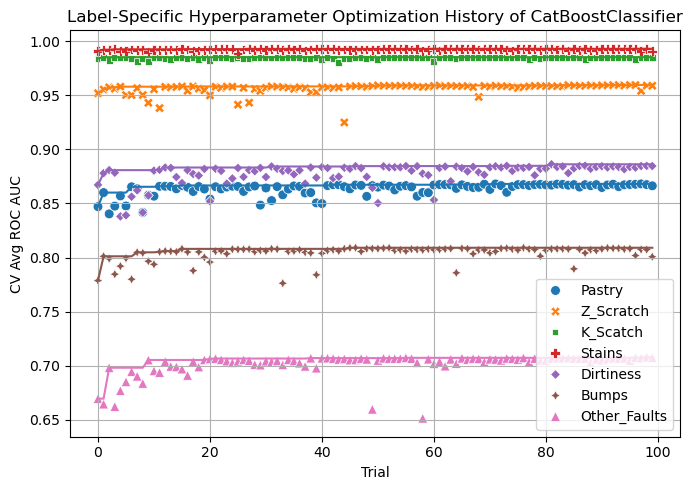

In [196]:
title = 'Label-Specific Hyperparameter Optimization History of CatBoostClassifier'
plot_optimization_history(cat, by_label=True, title=title, figsize=(7, 5))

In [50]:
# Ealuate the model on the training set using the label-specific best params
base_estimator_cross_val_score(cat, X_train, y_train, by_label=True)

weights; [0.07577235772357724, 0.05990243902439024, 0.17788617886178862, 0.029008130081300813, 0.025300813008130082, 0.24676422764227643, 0.34315447154471546]
Mean ROC AUC Score on Training Set: 0.8273


0.8272675094621846

In [ ]:
# Evaluate the model on the validation set using the label-specific best params
evaluate(cat, by_label=True)

Training model for label: 'Pastry'...
0:	learn: 0.6707576	total: 6.33ms	remaining: 2.84s
1:	learn: 0.6503654	total: 11.9ms	remaining: 2.68s
2:	learn: 0.6299764	total: 16.4ms	remaining: 2.44s
3:	learn: 0.6105535	total: 21ms	remaining: 2.34s
4:	learn: 0.5927652	total: 25.4ms	remaining: 2.26s
5:	learn: 0.5745283	total: 29.8ms	remaining: 2.2s
6:	learn: 0.5571296	total: 34.5ms	remaining: 2.18s
7:	learn: 0.5419682	total: 38.8ms	remaining: 2.14s
8:	learn: 0.5267544	total: 43.1ms	remaining: 2.11s
9:	learn: 0.5149444	total: 47.4ms	remaining: 2.08s
10:	learn: 0.5013533	total: 50.8ms	remaining: 2.03s
11:	learn: 0.4903129	total: 55.2ms	remaining: 2.01s
12:	learn: 0.4776894	total: 59.6ms	remaining: 2s
13:	learn: 0.4688301	total: 63.8ms	remaining: 1.99s
14:	learn: 0.4577777	total: 68.3ms	remaining: 1.98s
15:	learn: 0.4490497	total: 72.4ms	remaining: 1.96s
16:	learn: 0.4387454	total: 76.4ms	remaining: 1.95s
17:	learn: 0.4283624	total: 80.7ms	remaining: 1.94s
18:	learn: 0.4191715	total: 85ms	remaining

0.8308507666435682

## Ensamble

In [27]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score


rf_best_params_multi = retrieve_best_params(rf, by_label=False)
xgb_best_params_multi = retrieve_best_params(xgb, by_label=False)
lgb_best_params_multi = retrieve_best_params(lgb, by_label=False)
cat_best_params_multi = retrieve_best_params(cat, by_label=False)

  
rf_best_params_label = retrieve_best_params(rf, by_label=True)
xgb_best_params_label = retrieve_best_params(xgb, by_label=True)
lgb_best_params_label = retrieve_best_params(lgb, by_label=True)
cat_best_params_label = retrieve_best_params(cat, by_label=True)
 
    
# Retrieve the best classifiers for each label
def get_classifiers_for_label(label):
    rf = RandomForestClassifier(**rf_best_params_label[label])
    xgb = XGBClassifier(**xgb_best_params_label[label])
    lgb = LGBMClassifier(**lgb_best_params_label[label])
    cat = CatBoostClassifier(**cat_best_params_label[label])
    return rf, xgb, lgb, cat


# Retrieve the best classifiers for each label
def get_classifiers():
    rf = RandomForestClassifier(**rf_best_params_multi)
    xgb = XGBClassifier(**xgb_best_params_multi)
    lgb = LGBMClassifier(**lgb_best_params_multi)
    cat = CatBoostClassifier(**cat_best_params_multi)
    return rf, xgb, lgb, cat




def generate_ensemble_study_storage_names(ensemble_model:str, ensemble_by_label:bool, base_by_label:bool):
    os.makedirs('models', exist_ok=True)
    
    ensamble_suffix = "_label" if ensemble_by_label else "_multi"
    base_suffix = "_label" if base_by_label else "_multi"
    name = ensemble_model + ensamble_suffix + '_base' + base_suffix
    storage = f'sqlite:///models/{name}.db'
    
    if ensemble_by_label:
        study_names = [name + f"_{label}" for label in y_train.columns]
    else:
        study_names = [name]
        
    return storage, study_names




def retrieve_ensemble_studies(ensemble_model:str, ensemble_by_label:bool, base_by_label:bool):
    storage, study_names = generate_ensemble_study_storage_names(ensemble_model, ensemble_by_label, base_by_label)
    
    if ensemble_by_label:
        studies_by_label = {}
        for i, label in enumerate(y_train.columns):
            study = optuna.load_study(study_name=study_names[i], storage=storage)
            studies_by_label[label] = study
            
        return studies_by_label
    
    else:
        return optuna.load_study(study_name=study_names[0], storage=storage)




def retrieve_best_weights(ensemble_model:str, ensemble_by_label:bool, base_by_label:bool):
    studies = retrieve_ensemble_studies(ensemble_model, ensemble_by_label, base_by_label)
    
    if ensemble_by_label:
        best_weights_by_label = {}
        for label, study in studies.items():
            best_weights_by_label[label] = study.best_params
            
        return best_weights_by_label
    else:
        return studies.best_params
       


def ensemble_cross_val_score(ensemble_model, ensemble_by_label:bool, base_by_label:bool, X, y, n_splits, n_jobs):
    
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=7)
    
    if ensemble_model == 'VotingClassifier':
        if ensemble_by_label:
            weights = retrieve_best_weights(ensemble_model, ensemble_by_label, base_by_label)
            scores_by_label = []
            label_weights = []
            
            for label in y.columns:
                if base_by_label:
                    rf, xgb, lgb, cat = get_classifiers_for_label(label)
                else:
                    rf, xgb, lgb, cat = get_classifiers()
                
                model = VotingClassifier(
                    estimators=[('rf', rf), ('xgb', xgb), ('lgb', lgb), ('cat', cat)],
                    weights=[weights[label][f'weight_rf_{label}'], weights[label][f'weight_xgb_{label}'], weights[label][f'weight_lgb_{label}'], weights[label][f'weight_cat_{label}']],
                    voting='soft', n_jobs=n_jobs)
                
                
                scores = cross_val_score(model, X, y[label], cv=cv, scoring='roc_auc', n_jobs=n_jobs)
            
                print(f"ROC AUC Score for '{label}': {scores.mean()}")
                scores_by_label.append(scores.mean())
                label_weights.append(y[label].value_counts(normalize=True)[1]) # percentage of positive class
                
            mean_roc_auc =  np.average(scores_by_label, weights=label_weights)
            print(f"Mean ROC AUC Score: {mean_roc_auc}")
            return mean_roc_auc
            
        else:
            weights = retrieve_best_weights(ensemble_model, ensemble_by_label, base_by_label)
            
            if base_by_label:
                scores_by_label = []
                label_weights = []
                
                for label in y.columns:
                    rf, xgb, lgb, cat = get_classifiers_for_label(label)
                    voting_clf = VotingClassifier(
                        estimators=[('rf', rf), ('xgb', xgb), ('lgb', lgb), ('cat', cat)],
                        weights=[weights['weight_rf'], weights['weight_xgb'], weights['weight_lgb'], weights['weight_cat']],
                        voting='soft', n_jobs=n_jobs)
                    
                    model = OneVsRestClassifier(voting_clf, n_jobs=n_jobs)
                    
                    scores = cross_val_score(model, X, y[label], cv=cv, scoring='roc_auc', n_jobs=n_jobs)
                    
                    print(f"ROC AUC Score for '{label}': {scores.mean()}")
                    scores_by_label.append(scores.mean())
                    label_weights.append(y[label].value_counts(normalize=True)[1]) # percentage of positive class
                
                mean_roc_auc =  np.average(scores_by_label, weights=label_weights)
                print(f"Mean ROC AUC Score: {mean_roc_auc}")
                return mean_roc_auc
            
            else: 
                rf, xgb, lgb, cat = get_classifiers()
                voting_clf = VotingClassifier(
                    estimators=[('rf', rf), ('xgb', xgb), ('lgb', lgb), ('cat', cat)],
                    weights=[weights['weight_rf'], weights['weight_xgb'], weights['weight_lgb'], weights['weight_cat']],
                    voting='soft', n_jobs=n_jobs)
                
                model = OneVsRestClassifier(voting_clf, n_jobs=n_jobs)
                
                scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc', n_jobs=n_jobs)
                print(f"Mean ROC AUC Score: {scores.mean()}")
                return scores.mean()
            
    elif ensemble_model == 'stacking':
        pass



def generate_ensemble_trial_data(ensemble_model, ensemble_by_label:bool, base_by_label:bool):
    studies = retrieve_ensemble_studies(ensemble_model, ensemble_by_label, base_by_label)
    
    if ensemble_by_label:
        trial_data_frames = []
        for label, study in studies.items():
            trials_df = study.trials_dataframe(attrs=('number', 'value'))
            trials_df['cumulative_max'] = trials_df['value'].cummax()
            trials_df['label'] = label  # Add label column for distinguishing each label's data
            trial_data_frames.append(trials_df)
        
        # Combine all label data into one DataFrame
        combined_trials_df = pd.concat(trial_data_frames, ignore_index=True)
        return combined_trials_df
    
    else:
        trials_df = studies.trials_dataframe(attrs=('number', 'value'))
        trials_df['cumulative_max'] = trials_df['value'].cummax()
        return trials_df
    
    
    
    
def plot_ensemble_optimization_history(ensemble_model, ensemble_by_label:bool, base_by_label:bool, title:str, figsize:tuple):
    trials_df = generate_ensemble_trial_data(ensemble_model, ensemble_by_label, base_by_label)
    
    plt.figure(figsize=figsize)
    
    if ensemble_by_label:
        # Plot all label histories with a different color per label
        sns.scatterplot(data=trials_df, x='number', y='value', hue='label', style='label', s=50, palette='tab10', legend='full')
        sns.lineplot(data=trials_df, x='number', y='cumulative_max', hue='label', palette='tab10', marker='', linestyle='-', linewidth=1.5, legend=None)
    else:
        # Plot a single optimization history for the multilabel case
        sns.scatterplot(data=trials_df, x='number', y='value', label='Trial Value')
        sns.lineplot(data=trials_df, x='number', y='cumulative_max', color='red', marker='', linestyle='-', linewidth=1.5, label='Best Value')
    
    plt.title(title, fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('Trial', fontsize=10)
    plt.ylabel('CV Avg ROC AUC', fontsize=10)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True)
    plt.tight_layout()

    plt.show()

### 1. Voting

The `VotingClassifier` does not support multilabel classifications. Consequently, it must be wrapped with classes that provide such a support, such as `OneVsRestClassifier` whenever it is used for multilabel classification.

#### 1.1. Multilabel Weight-Tuning Using Label-Specific Hyper-Params

In [245]:
import optuna
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict


N_SPLITS = 5
N_TRIALS = 50
N_JOBS = -1



def objective(trial):
    weights = [
        trial.suggest_float("weight_rf", 0.01, 1.0),
        trial.suggest_float("weight_xgb", 0.01, 1.0),
        trial.suggest_float("weight_lgb", 0.01, 1.0),
        trial.suggest_float("weight_cat", 0.01, 1.0)
    ]

    auc_scores = []
    
    for i, label in enumerate(y_train.columns):
        rf, xgb, lgb, cat = get_classifiers_for_label(label)

        voting = VotingClassifier(
            estimators=[('rf', rf), ('xgb', xgb), ('lgb', lgb), ('cat', cat)],
            voting='soft',
            weights=weights,
            n_jobs=N_JOBS
        )

        
        cv = KFold(n_splits=N_SPLITS, shuffle=True, random_state=7)

        y_pred_proba = cross_val_predict(
            voting, X_train, y_train[label],
            cv=cv, method='predict_proba', n_jobs=N_JOBS
        )[:, 1] # positive class probabilities
        
        # Calculate the AUC score for the label
        auc = roc_auc_score(y_train[label], y_pred_proba)
        auc_scores.append(auc)
        
        # Report intermediate AUC score for the pruner
        trial.report(auc, step=i)

        # Check if the trial should be pruned
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    # Return the average AUC score across labels as the optimization objective
    return np.mean(auc_scores)

storage, study_names = generate_ensemble_study_storage_names('VotingClassifier', ensemble_by_label=False, base_by_label=True)

try:
    optuna.delete_study(study_name=study_names[0], storage=storage)
except:
    pass

optuna.logging.set_verbosity(optuna.logging.INFO)
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1, interval_steps=1)
sampler = optuna.samplers.TPESampler(seed=7)
study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner, storage=storage, study_name=study_names[0])
study.optimize(objective, n_trials=N_TRIALS)



print(f"Best weights: {study.best_params}")
print(f"Best average ROC AUC score: {study.best_value}")


[I 2024-11-15 12:03:08,089] A new study created in RDB with name: VotingClassifier_multi_base_label
[I 2024-11-15 12:05:09,331] Trial 0 finished with value: 0.8878850386557859 and parameters: {'weight_rf': 0.0855452064802176, 'weight_xgb': 0.7821196043177134, 'weight_lgb': 0.44402513912648456, 'weight_cat': 0.7262305260526318}. Best is trial 0 with value: 0.8878850386557859.
[I 2024-11-15 12:07:04,364] Trial 1 finished with value: 0.8863638702994965 and parameters: {'weight_rf': 0.9782096168766367, 'weight_xgb': 0.5431109117063293, 'weight_lgb': 0.5061092590233385, 'weight_cat': 0.08133062202616392}. Best is trial 0 with value: 0.8878850386557859.
[I 2024-11-15 12:08:56,670] Trial 2 finished with value: 0.8877923643240084 and parameters: {'weight_rf': 0.2757545903008525, 'weight_xgb': 0.5048836758173043, 'weight_lgb': 0.682437696159731, 'weight_cat': 0.8057016457433317}. Best is trial 0 with value: 0.8878850386557859.
[I 2024-11-15 12:10:50,578] Trial 3 finished with value: 0.887366960

Best weights: {'weight_rf': 0.0855452064802176, 'weight_xgb': 0.7821196043177134, 'weight_lgb': 0.44402513912648456, 'weight_cat': 0.7262305260526318}
Best average ROC AUC score: 0.8878850386557859


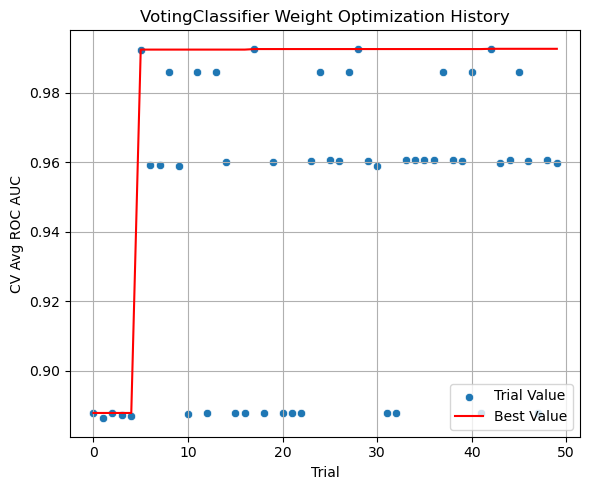

In [247]:
title = "Multilabel Weight Optimization History of VotingClassifier (using label-specific best params)"
plot_ensemble_optimization_history('VotingClassifier', ensemble_by_label=False, base_by_label=True, title=title, figsize=(7, 5))

In [283]:
score = ensemble_cross_val_score('VotingClassifier', ensemble_by_label=False, base_by_label=True, X=X_train, y=y_train, n_splits=5, n_jobs=-1)

ROC AUC Score for 'Pastry': 0.870231336631576
ROC AUC Score for 'Z_Scratch': 0.9610431669329242
ROC AUC Score for 'K_Scatch': 0.9863601318875237
ROC AUC Score for 'Stains': 0.9929751609369261
ROC AUC Score for 'Dirtiness': 0.891357586134578
ROC AUC Score for 'Bumps': 0.8101161475314264
ROC AUC Score for 'Other_Faults': 0.7090839815457517
Mean ROC AUC Score: 0.8285310333958458


In [257]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score


best_weights = retrieve_best_weights('VotingClassifier', ensemble_by_label=False, base_by_label=True)

auc_scores = []
weights = []

for label in y_val.columns:

    rf, xgb, lgb, cat = get_classifiers_for_label(label)
    
    voting_clf = VotingClassifier(
        estimators=[('rf', rf), ('xgb', xgb), ('lgb', lgb), ('cat', cat)],
        voting='soft',
        weights=[best_weights['weight_rf'], best_weights['weight_xgb'], best_weights['weight_lgb'], best_weights['weight_cat']],
        n_jobs=N_JOBS
    )

    voting_clf.fit(X_train, y_train[label])

    y_pred_proba = voting_clf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val[label], y_pred_proba)
    auc_scores.append(auc)

    positive_count = y_val[label].sum()
    weights.append(positive_count)

weighted_average_auc_score = np.average(auc_scores, weights=weights)
print(f"Weighted Average ROC AUC Score on Validation Set: {weighted_average_auc_score:.4f}")

Weighted Average ROC AUC Score on Validation Set: 0.8312


#### 1.2. Multilabel Weight-Tuning Using Multilabel Hyper-Params

In [284]:
import optuna
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.multiclass import OneVsRestClassifier

N_SPLITS = 5
N_TRIALS = 50
N_JOBS = -1



def objective(trial):
    weights = [
        trial.suggest_float("weight_rf", 0.01, 1.0),
        trial.suggest_float("weight_xgb", 0.01, 1.0),
        trial.suggest_float("weight_lgb", 0.01, 1.0),
        trial.suggest_float("weight_cat", 0.01, 1.0)
    ]

    
    rf, xgb, lgb, cat = get_classifiers()

    voting_clf = VotingClassifier(
        estimators=[('rf', rf), ('xgb', xgb), ('lgb', lgb), ('cat', cat)],
        voting='soft',
        weights=weights,
        n_jobs=N_JOBS
    )
    
    multilabel_clf = OneVsRestClassifier(voting_clf, n_jobs=N_JOBS)
    
    cv = KFold(n_splits=N_SPLITS, shuffle=True, random_state=7)
    fold_aucs = []
    
    # Iterate over each fold
    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train)):
        # Use .iloc to properly index rows by position
        multilabel_clf.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
        y_pred_proba = multilabel_clf.predict_proba(X_train.iloc[val_idx])

        fold_auc = roc_auc_score(y_train.iloc[val_idx], y_pred_proba, average='weighted')
        fold_aucs.append(fold_auc)
        
        # Report intermediate AUC to Optuna
        trial.report(fold_auc, fold_idx)
        
        # Check if the trial should be pruned
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    # Return the mean AUC across folds
    return np.mean(fold_aucs)

storage, study_names = generate_ensemble_study_storage_names('VotingClassifier', ensemble_by_label=False, base_by_label=False)

try:
    optuna.delete_study(study_name=study_names[0], storage=storage)
except KeyError:
    pass

optuna.logging.set_verbosity(optuna.logging.INFO)
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1, interval_steps=1)
sampler = optuna.samplers.TPESampler(seed=7)
study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner, storage=storage, study_name=study_names[0])
study.optimize(objective, n_trials=N_TRIALS)


print(f"Best weights: {study.best_params}")
print(f"Best average ROC AUC score: {study.best_value}")



[I 2024-11-15 14:14:42,430] A new study created in RDB with name: VotingClassifier_multi_base_multi
[I 2024-11-15 14:17:40,932] Trial 0 finished with value: 0.8278907736055613 and parameters: {'weight_rf': 0.0855452064802176, 'weight_xgb': 0.7821196043177134, 'weight_lgb': 0.44402513912648456, 'weight_cat': 0.7262305260526318}. Best is trial 0 with value: 0.8278907736055613.
[I 2024-11-15 14:20:48,591] Trial 1 finished with value: 0.8263610774304896 and parameters: {'weight_rf': 0.9782096168766367, 'weight_xgb': 0.5431109117063293, 'weight_lgb': 0.5061092590233385, 'weight_cat': 0.08133062202616392}. Best is trial 0 with value: 0.8278907736055613.
[I 2024-11-15 14:23:35,187] Trial 2 finished with value: 0.8278070441202271 and parameters: {'weight_rf': 0.2757545903008525, 'weight_xgb': 0.5048836758173043, 'weight_lgb': 0.682437696159731, 'weight_cat': 0.8057016457433317}. Best is trial 0 with value: 0.8278907736055613.
[I 2024-11-15 14:26:36,094] Trial 3 finished with value: 0.827325617

Best weights: {'weight_rf': 0.04902475203147649, 'weight_xgb': 0.7569581513843786, 'weight_lgb': 0.7935079584416386, 'weight_cat': 0.9913309084726856}
Best average ROC AUC score: 0.8279135121227632


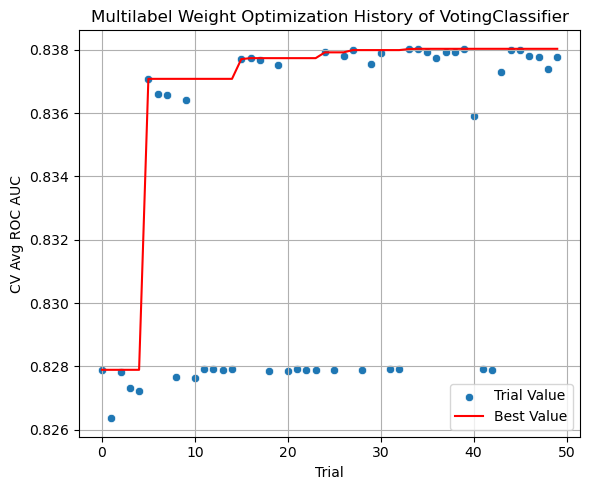

In [294]:
title = "Multilabel Weight Optimization History of VotingClassifier (using multilabel best params)"
plot_ensemble_optimization_history('VotingClassifier', ensemble_by_label=False, base_by_label=False, title=title, figsize=(7, 5))

In [298]:
score = ensemble_cross_val_score('VotingClassifier', ensemble_by_label=False, base_by_label=False, X=X_train, y=y_train, n_splits=5, n_jobs=-1)

In [300]:
print(score)

0.8878772455128784


In [301]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score


best_weights = retrieve_best_weights('VotingClassifier', ensemble_by_label=False, base_by_label=False)

rf, xgb, lgb, cat = get_classifiers()

voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('lgb', lgb), ('cat', cat)],
    voting='soft',
    weights=[best_weights['weight_rf'], best_weights['weight_xgb'], best_weights['weight_lgb'], best_weights['weight_cat']],
    n_jobs=N_JOBS
)

multilabel_clf = OneVsRestClassifier(voting_clf, n_jobs=N_JOBS)
multilabel_clf.fit(X_train, y_train)

y_pred_proba = multilabel_clf.predict_proba(X_val)
weighted_average_auc_score = roc_auc_score(y_val, y_pred_proba, average='weighted')


print(f"Weighted Average ROC AUC Score on Validation Set: {weighted_average_auc_score:.4f}")

Weighted Average ROC AUC Score on Validation Set: 0.8307


#### 1.3. Label-Specific Weight-Tuning Using Label-Specific Hyper-Params

In [302]:
import optuna
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import roc_auc_score


N_SPLITS = 5
N_TRIALS = 50
N_JOBS = -1


# Objective function that accepts a specific label
def objective(trial, label):
    # Define label-specific weights
    weights = [
        trial.suggest_float(f"weight_rf_{label}", 0.01, 1.0),
        trial.suggest_float(f"weight_xgb_{label}", 0.01, 1.0),
        trial.suggest_float(f"weight_lgb_{label}", 0.01, 1.0),
        trial.suggest_float(f"weight_cat_{label}", 0.01, 1.0)
    ]
    
    # Get classifiers for the current label
    rf, xgb, lgb, cat = get_classifiers_for_label(label)

    # Initialize the VotingClassifier with label-specific weights
    voting_clf = VotingClassifier(
        estimators=[('rf', rf), ('xgb', xgb), ('lgb', lgb), ('cat', cat)],
        voting='soft',
        weights=weights,
        n_jobs=N_JOBS
    )

    # Perform cross-validation
    cv = KFold(n_splits=N_SPLITS, shuffle=True, random_state=7)
    auc_scores = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train[label])):
        # Split the data for the current fold
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train[label].iloc[train_idx], y_train[label].iloc[val_idx]
        
        # Fit and predict on the current fold
        voting_clf.fit(X_train_fold, y_train_fold)
        y_pred_proba = voting_clf.predict_proba(X_val_fold)[:, 1]
        
        # Calculate AUC score for the current fold
        auc = roc_auc_score(y_val_fold, y_pred_proba)
        auc_scores.append(auc)
        
        # Report intermediate AUC score for the current fold to the pruner
        trial.report(auc, fold_idx)
        
        # Check if the trial should be pruned
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    # Return the average AUC score across folds as the optimization objective
    return np.mean(auc_scores)


storage, study_names = generate_ensemble_study_storage_names('VotingClassifier', ensemble_by_label=True, base_by_label=True)



# Setting up Optuna for each label
optuna.logging.set_verbosity(optuna.logging.INFO)
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1, interval_steps=1)
sampler = optuna.samplers.TPESampler(seed=7)
label_weights = {}
average_auc_scores = []


# Optimize weights separately for each label
for i, label in enumerate(y_train.columns):

    try:
        optuna.delete_study(study_name=study_names[i], storage=storage)
    except KeyError:
        pass
    
    print(f"Optimizing weights for label: {label}")
    study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner, storage=storage, study_name=study_names[i])
    study.optimize(lambda trial: objective(trial, label), n_trials=N_TRIALS)
    
    # Store the best weights and AUC for each label
    best_trial = study.best_trial
    label_weights[label] = {
        'rf_weight': best_trial.params[f"weight_rf_{label}"],
        'xgb_weight': best_trial.params[f"weight_xgb_{label}"],
        'lgb_weight': best_trial.params[f"weight_lgb_{label}"],
        'cat_weight': best_trial.params[f"weight_cat_{label}"]
    }
    average_auc_scores.append(study.best_value)

print("\nOptimized weights per label:")
for label, weights in label_weights.items():
    print(f"Label {label}: {weights}")

print(f"\nAverage ROC AUC score across labels: {np.mean(average_auc_scores)}")



[I 2024-11-15 17:11:00,393] A new study created in RDB with name: VotingClassifier_label_base_label_Pastry


Optimizing weights for label: Pastry


[I 2024-11-15 17:11:46,768] Trial 0 finished with value: 0.8702406905128622 and parameters: {'weight_rf_Pastry': 0.0855452064802176, 'weight_xgb_Pastry': 0.7821196043177134, 'weight_lgb_Pastry': 0.44402513912648456, 'weight_cat_Pastry': 0.7262305260526318}. Best is trial 0 with value: 0.8702406905128622.
[I 2024-11-15 17:12:30,653] Trial 1 finished with value: 0.8696658993465798 and parameters: {'weight_rf_Pastry': 0.9782096168766367, 'weight_xgb_Pastry': 0.5431109117063293, 'weight_lgb_Pastry': 0.5061092590233385, 'weight_cat_Pastry': 0.08133062202616392}. Best is trial 0 with value: 0.8702406905128622.
[I 2024-11-15 17:13:14,086] Trial 2 finished with value: 0.8701888417305701 and parameters: {'weight_rf_Pastry': 0.2757545903008525, 'weight_xgb_Pastry': 0.5048836758173043, 'weight_lgb_Pastry': 0.682437696159731, 'weight_cat_Pastry': 0.8057016457433317}. Best is trial 0 with value: 0.8702406905128622.
[I 2024-11-15 17:13:57,053] Trial 3 finished with value: 0.8697035426603186 and para

Optimizing weights for label: Z_Scratch


[I 2024-11-15 17:38:40,664] Trial 0 finished with value: 0.9602937618778983 and parameters: {'weight_rf_Z_Scratch': 0.4583145032209364, 'weight_xgb_Z_Scratch': 0.35944858228495075, 'weight_lgb_Z_Scratch': 0.6608254681519606, 'weight_cat_Z_Scratch': 0.37664757215815486}. Best is trial 0 with value: 0.9602937618778983.
[I 2024-11-15 17:39:18,255] Trial 1 finished with value: 0.9606093224953 and parameters: {'weight_rf_Z_Scratch': 0.4645020481125171, 'weight_xgb_Z_Scratch': 0.7221308812839511, 'weight_lgb_Z_Scratch': 0.41886191082269625, 'weight_cat_Z_Scratch': 0.9073590364726953}. Best is trial 1 with value: 0.9606093224953.
[I 2024-11-15 17:39:56,223] Trial 2 finished with value: 0.9608979973113542 and parameters: {'weight_rf_Z_Scratch': 0.1886471030106548, 'weight_xgb_Z_Scratch': 0.7437076841841317, 'weight_lgb_Z_Scratch': 0.42815030320670894, 'weight_cat_Z_Scratch': 0.4321890369580929}. Best is trial 2 with value: 0.9608979973113542.
[I 2024-11-15 17:40:34,244] Trial 3 finished with v

Optimizing weights for label: K_Scatch


[I 2024-11-15 17:59:16,514] Trial 0 finished with value: 0.986312502125414 and parameters: {'weight_rf_K_Scatch': 0.17384638646112957, 'weight_xgb_K_Scatch': 0.4207527548475195, 'weight_lgb_K_Scatch': 0.4536394509276961, 'weight_cat_K_Scatch': 0.777151372055877}. Best is trial 0 with value: 0.986312502125414.
[I 2024-11-15 18:00:12,892] Trial 1 finished with value: 0.9862818160622032 and parameters: {'weight_rf_K_Scatch': 0.798426793774723, 'weight_xgb_K_Scatch': 0.5271662267215957, 'weight_lgb_K_Scatch': 0.4660239932016441, 'weight_cat_K_Scatch': 0.7804314655284577}. Best is trial 0 with value: 0.986312502125414.
[I 2024-11-15 18:01:09,197] Trial 2 finished with value: 0.9863393382035486 and parameters: {'weight_rf_K_Scatch': 0.8884160623342074, 'weight_xgb_K_Scatch': 0.6781695821681198, 'weight_lgb_K_Scatch': 0.802474258508479, 'weight_cat_K_Scatch': 0.9397202401948634}. Best is trial 2 with value: 0.9863393382035486.
[I 2024-11-15 18:02:05,773] Trial 3 finished with value: 0.9863843

Optimizing weights for label: Stains


[I 2024-11-15 18:35:44,770] Trial 0 finished with value: 0.99293148846461 and parameters: {'weight_rf_Stains': 0.23183785057685616, 'weight_xgb_Stains': 0.5791139617132576, 'weight_lgb_Stains': 0.17782848633054707, 'weight_cat_Stains': 0.7844078498105405}. Best is trial 0 with value: 0.99293148846461.
[I 2024-11-15 18:36:54,228] Trial 1 finished with value: 0.9926376334669275 and parameters: {'weight_rf_Stains': 0.8584058698506426, 'weight_xgb_Stains': 0.04333746245781971, 'weight_lgb_Stains': 0.5373183568942369, 'weight_cat_Stains': 0.7989818438691287}. Best is trial 0 with value: 0.99293148846461.
[I 2024-11-15 18:38:02,596] Trial 2 finished with value: 0.9926102040207304 and parameters: {'weight_rf_Stains': 0.9753882843455446, 'weight_xgb_Stains': 0.28151600726247705, 'weight_lgb_Stains': 0.1774100527317295, 'weight_cat_Stains': 0.8779339208798189}. Best is trial 0 with value: 0.99293148846461.
[I 2024-11-15 18:39:12,556] Trial 3 finished with value: 0.992519656794314 and parameters

Optimizing weights for label: Dirtiness


[I 2024-11-15 19:11:00,751] Trial 0 finished with value: 0.8911593957320013 and parameters: {'weight_rf_Dirtiness': 0.020474107868962303, 'weight_xgb_Dirtiness': 0.8323339227338666, 'weight_lgb_Dirtiness': 0.9273468083923561, 'weight_cat_Dirtiness': 0.4640174449702896}. Best is trial 0 with value: 0.8911593957320013.
[I 2024-11-15 19:12:34,539] Trial 1 finished with value: 0.8908041756800319 and parameters: {'weight_rf_Dirtiness': 0.7737279211180454, 'weight_xgb_Dirtiness': 0.8675370437435472, 'weight_lgb_Dirtiness': 0.6135186503512137, 'weight_cat_Dirtiness': 0.8739009113127452}. Best is trial 0 with value: 0.8911593957320013.
[I 2024-11-15 19:14:08,187] Trial 2 finished with value: 0.8912912658887284 and parameters: {'weight_rf_Dirtiness': 0.03366399588090756, 'weight_xgb_Dirtiness': 0.2788792680569682, 'weight_lgb_Dirtiness': 0.2844473868673523, 'weight_cat_Dirtiness': 0.1294261040230966}. Best is trial 2 with value: 0.8912912658887284.
[I 2024-11-15 19:15:42,042] Trial 3 finished w

Optimizing weights for label: Bumps


[I 2024-11-15 20:21:40,343] Trial 0 finished with value: 0.8090411836714712 and parameters: {'weight_rf_Bumps': 0.7544340255307855, 'weight_xgb_Bumps': 0.07104867686816994, 'weight_lgb_Bumps': 0.7473754369449915, 'weight_cat_Bumps': 0.9468131679007036}. Best is trial 0 with value: 0.8090411836714712.
[I 2024-11-15 20:23:23,080] Trial 1 finished with value: 0.8092246279610675 and parameters: {'weight_rf_Bumps': 0.6075239561785316, 'weight_xgb_Bumps': 0.2947041426987012, 'weight_lgb_Bumps': 0.6756455262449935, 'weight_cat_Bumps': 0.7149282989135809}. Best is trial 1 with value: 0.8092246279610675.
[I 2024-11-15 20:25:05,578] Trial 2 finished with value: 0.809274625979258 and parameters: {'weight_rf_Bumps': 0.659885783673216, 'weight_xgb_Bumps': 0.1554610125366081, 'weight_lgb_Bumps': 0.9737408125870038, 'weight_cat_Bumps': 0.9558296173026701}. Best is trial 2 with value: 0.809274625979258.
[I 2024-11-15 20:26:47,706] Trial 3 finished with value: 0.8095229377065147 and parameters: {'weigh

Optimizing weights for label: Other_Faults


[I 2024-11-15 21:21:20,423] Trial 0 finished with value: 0.7084072069938052 and parameters: {'weight_rf_Other_Faults': 0.8484374948553743, 'weight_xgb_Other_Faults': 0.42704117151328064, 'weight_lgb_Other_Faults': 0.8934140826826797, 'weight_cat_Other_Faults': 0.8371138755360594}. Best is trial 0 with value: 0.7084072069938052.
[I 2024-11-15 21:22:46,274] Trial 1 finished with value: 0.7089969714574271 and parameters: {'weight_rf_Other_Faults': 0.1083540390180343, 'weight_xgb_Other_Faults': 0.6497915683543043, 'weight_lgb_Other_Faults': 0.31738962083078504, 'weight_cat_Other_Faults': 0.7565126650133431}. Best is trial 1 with value: 0.7089969714574271.
[I 2024-11-15 21:24:12,458] Trial 2 finished with value: 0.7082842766137134 and parameters: {'weight_rf_Other_Faults': 0.5472053408732541, 'weight_xgb_Other_Faults': 0.46302288590519985, 'weight_lgb_Other_Faults': 0.8964131166916913, 'weight_cat_Other_Faults': 0.06668102420216598}. Best is trial 1 with value: 0.7089969714574271.
[I 2024-1


Optimized weights per label:
Label Pastry: {'rf_weight': 0.0855452064802176, 'xgb_weight': 0.7821196043177134, 'lgb_weight': 0.44402513912648456, 'cat_weight': 0.7262305260526318}
Label Z_Scratch: {'rf_weight': 0.24821700550716191, 'xgb_weight': 0.9032297459030495, 'lgb_weight': 0.6455120448638093, 'cat_weight': 0.5762322757180699}
Label K_Scatch: {'rf_weight': 0.23140518974036045, 'xgb_weight': 0.9878848205723965, 'lgb_weight': 0.5730177460682899, 'cat_weight': 0.35807784596460634}
Label Stains: {'rf_weight': 0.23183785057685616, 'xgb_weight': 0.5791139617132576, 'lgb_weight': 0.17782848633054707, 'cat_weight': 0.7844078498105405}
Label Dirtiness: {'rf_weight': 0.11996422348757452, 'xgb_weight': 0.48777827500878995, 'lgb_weight': 0.5642939916645804, 'cat_weight': 0.5972089463962247}
Label Bumps: {'rf_weight': 0.013564263567457085, 'xgb_weight': 0.5851525392853039, 'lgb_weight': 0.10238768096173456, 'cat_weight': 0.6727771308189932}
Label Other_Faults: {'rf_weight': 0.0105197306573577

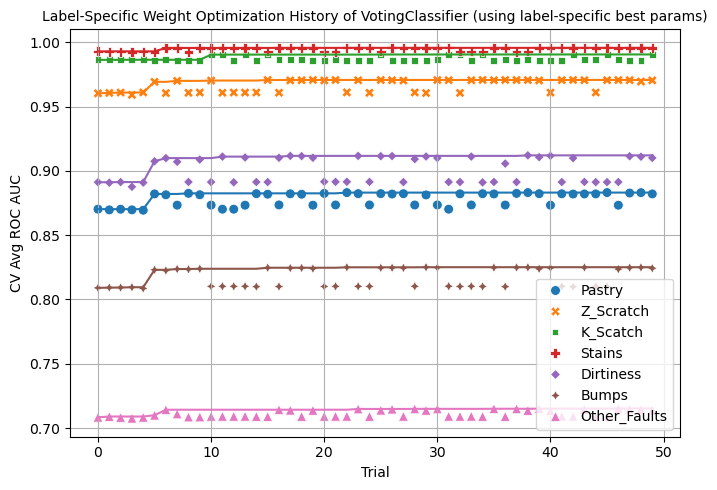

In [326]:
title = "Label-Specific Weight Optimization History of VotingClassifier (using label-specific best params)"
plot_ensemble_optimization_history('VotingClassifier', ensemble_by_label=True, base_by_label=True, title=title, figsize=(7, 5))

In [311]:
score = ensemble_cross_val_score('VotingClassifier', ensemble_by_label=True, base_by_label=True, X=X_train, y=y_train, n_splits=5, n_jobs=-1)

ROC AUC Score for 'Pastry': 0.8702010448292492
ROC AUC Score for 'Z_Scratch': 0.9609668946172562
ROC AUC Score for 'K_Scatch': 0.9864304782618929
ROC AUC Score for 'Stains': 0.9929263571277464
ROC AUC Score for 'Dirtiness': 0.8914403278807372
ROC AUC Score for 'Bumps': 0.8102841541198729
ROC AUC Score for 'Other_Faults': 0.7091713201109132
Mean ROC AUC Score: 0.8286122160583597


In [313]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score

best_weights = retrieve_best_weights('VotingClassifier', ensemble_by_label=True, base_by_label=True)

auc_scores = []
weights = []

for label in y_val.columns:
    # Retrieve label-specific weights
    label_weights = [
        best_weights[label]['weight_rf_' + label],
        best_weights[label]['weight_xgb_' + label],
        best_weights[label]['weight_lgb_' + label],
        best_weights[label]['weight_cat_' + label]
    ]

    # Get classifiers for the current label
    rf, xgb, lgb, cat = get_classifiers_for_label(label)

    # Initialize the VotingClassifier with label-specific weights
    voting_clf = VotingClassifier(
        estimators=[('rf', rf), ('xgb', xgb), ('lgb', lgb), ('cat', cat)],
        voting='soft',
        weights=label_weights,
        n_jobs=N_JOBS
    )

    # Fit the VotingClassifier for the current label
    voting_clf.fit(X_train, y_train[label])

    # Predict probabilities on the validation set
    y_pred_proba = voting_clf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val[label], y_pred_proba)
    auc_scores.append(auc)

    # Get the positive count for weighting
    positive_count = y_val[label].sum()
    weights.append(positive_count)

# Calculate the weighted average AUC score across all labels
weighted_average_auc_score = np.average(auc_scores, weights=weights)
print(f"Weighted Average ROC AUC Score on Validation Set: {weighted_average_auc_score:.4f}")


Weighted Average ROC AUC Score on Validation Set: 0.8313


### 2. Stacking

#### 2.1. Multilabel Weight Tuning Using Multilabel Hyper Params

In [ ]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier


N_SPLITS = 5
N_TRIALS = 50
N_JOBS = -1


def objective(trial):

    param_space = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'random_state': 7,
        'n_jobs': N_JOBS
    }

    
    rf, xgb, lgb, cat = get_classifiers()

    stacking_clf = StackingClassifier(
        estimators=[('rf', rf), ('xgb', xgb), ('lgb', lgb), ('cat', cat)],
        final_estimator = RandomForestClassifier(**param_space),
        cv = KFold(n_splits=N_SPLITS, shuffle=True, random_state=7),
        n_jobs=N_JOBS
    )
    
    multilabel_clf = OneVsRestClassifier(stacking_clf, n_jobs=N_JOBS)
    
    cv = KFold(n_splits=N_SPLITS, shuffle=True, random_state=7)
    fold_aucs = []
    
    # Iterate over each fold
    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train)):
        # Use .iloc to properly index rows by position
        multilabel_clf.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
        y_pred_proba = multilabel_clf.predict_proba(X_train.iloc[val_idx])

        fold_auc = roc_auc_score(y_train.iloc[val_idx], y_pred_proba, average='weighted')
        fold_aucs.append(fold_auc)
        
        # Report intermediate AUC to Optuna
        trial.report(fold_auc, fold_idx)
        
        # Check if the trial should be pruned
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    # Return the mean AUC across folds
    return np.mean(fold_aucs)

storage, study_names = generate_ensemble_study_storage_names('StackingClassifier', ensemble_by_label=False, base_by_label=False)

try:
    optuna.delete_study(study_name=study_names[0], storage=storage)
except KeyError:
    pass

optuna.logging.set_verbosity(optuna.logging.INFO)
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1, interval_steps=1)
sampler = optuna.samplers.TPESampler(seed=7)
study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner, storage=storage, study_name=study_names[0])
study.optimize(objective, n_trials=N_TRIALS)


print(f"Best weights: {study.best_params}")
print(f"Best average ROC AUC score: {study.best_value}")



## Prediction on Test Set

### 1. Use Multilabel Tuned Weights + Label-Specific Tuned Hyper-Params

In [30]:
from sklearn.ensemble import VotingClassifier

best_weights = retrieve_best_weights('VotingClassifier', ensemble_by_label=False, base_by_label=True)

submission = pd.DataFrame(index=test.index, columns=y_val.columns)

for label in y_val.columns:

    rf, xgb, lgb, cat = get_classifiers_for_label(label)
    
    voting_clf = VotingClassifier(
        estimators=[('rf', rf), ('xgb', xgb), ('lgb', lgb), ('cat', cat)],
        voting='soft',
        weights=[best_weights['weight_rf'], best_weights['weight_xgb'], best_weights['weight_lgb'], best_weights['weight_cat']],
    )

    voting_clf.fit(train[features], target[label])

    submission[label] = voting_clf.predict_proba(test[features])[:, 1]
    
    submission.to_csv('submission.csv', index=True)


[LightGBM] [Info] Number of positive: 1466, number of negative: 17753
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3118
[LightGBM] [Info] Number of data points in the train set: 19219, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.076279 -> initscore=-2.494017
[LightGBM] [Info] Start training from score -2.494017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

### 2. Use Multilabel Tuned Weights + Multilabel Tuned Hyper-Params

In [32]:
from sklearn.ensemble import VotingClassifier
from sklearn.multiclass import OneVsRestClassifier

best_weights = retrieve_best_weights('VotingClassifier', ensemble_by_label=False, base_by_label=False)

submission = pd.DataFrame(index=test.index, columns=y_val.columns)

rf, xgb, lgb, cat = get_classifiers()

voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('lgb', lgb), ('cat', cat)],
    voting='soft',
    weights=[best_weights['weight_rf'], best_weights['weight_xgb'], best_weights['weight_lgb'], best_weights['weight_cat']],
)

multilabel_clf = OneVsRestClassifier(voting_clf, n_jobs=-1)
multilabel_clf.fit(train[features], target)

submission[y_val.columns] = multilabel_clf.predict_proba(test[features])

filename = 'submission_multiweights_multiparams_1.csv'
submission.to_csv(filename, index=True)
print(f"Submission file saved as '{filename}'.")

Submission file saved as 'submission_multiweights_multiparams_1.csv'.


### 3. Use Label-Specific Tuned Weights + Label-Specific Tuned Hyper-Params

In [36]:
from sklearn.ensemble import VotingClassifier


best_weights = retrieve_best_weights('VotingClassifier', ensemble_by_label=True, base_by_label=True)

submission = pd.DataFrame(index=test.index, columns=y_val.columns)

for label in y_val.columns:

    rf, xgb, lgb, cat = get_classifiers_for_label(label)
    
    voting_clf = VotingClassifier(
        estimators=[('rf', rf), ('xgb', xgb), ('lgb', lgb), ('cat', cat)],
        voting='soft',
        weights=[best_weights[label][f'weight_rf_{label}'], best_weights[label][f'weight_xgb_{label}'], best_weights[label][f'weight_lgb_{label}'], best_weights[label][f'weight_cat_{label}']],
    )

    voting_clf.fit(train[features], target[label])

    submission[label] = voting_clf.predict_proba(test[features])[:, 1]
    
    filename = 'submission_label_label.csv'
    submission.to_csv(filename, index=True)
    print(f"Submission file saved as '{filename}'.")

[LightGBM] [Info] Number of positive: 1466, number of negative: 17753
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3118
[LightGBM] [Info] Number of data points in the train set: 19219, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.076279 -> initscore=-2.494017
[LightGBM] [Info] Start training from score -2.494017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain